In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.feature_selection import mutual_info_classif, RFE, SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# Pre-load

In [2]:
# Congelar capas desde la capa 0 hasta k
def freeze_layer(model, k, verbose=False):
    layers = list(model.children())
    num_layers = len(layers)
    for i in range(k + 1):
        layer = layers[i]
        if any(param.requires_grad for param in layer.parameters()):
            for param in layer.parameters():
                param.requires_grad = False
            if verbose:
                print(f"Capa {i} ({layer.__class__.__name__}) congelada")
        else:
            if verbose:
                print(f"Capa {i} ({layer.__class__.__name__}) no tiene parámetros y se omite")


# Descongelar todas las capas
def unfreeze_model(model, verbose=False):
    for param in model.parameters():
        param.requires_grad = True
    if verbose:
        print("Todas las capas descongeladas")



In [3]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss  # Usamos la pérdida negativa porque queremos minimizar la pérdida

        if self.best_score is None:
            self.best_score = score
            return False

        if score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                return True
        else:
            self.best_score = score
            self.counter = 0
        return False


In [4]:
import copy

def copy_model(model, verbose=0):
    model_copy = copy.deepcopy(model)
    if verbose > 0:
        print('Modelo copiado')
    return model_copy


In [5]:
def compute_class_weight_2(labels):
    class_sample_count = np.array([sum(labels == t) for t in np.unique(labels)])
    weight = 1. / class_sample_count
    weight = weight / np.sum(weight)
    class_weight = {i: weight[i] for i in range(len(weight))}
    return class_weight


## MLP

In [6]:
class MLP_2(nn.Module):
    def __init__(self, input_size, drop=0.0):
        super(MLP_2, self).__init__()
        self.input_size = input_size
        self.drop = drop

        self.gaussian_noise = GaussianNoise(0.0)
        self.fc1 = nn.Linear(input_size, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 500)
        self.fc4 = nn.Linear(500, 50)
        self.fc5 = nn.Linear(50, 2)
        self.leaky_relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=drop)

    def forward(self, x):
        x = self.gaussian_noise(x)
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.fc2(x)
        x = self.leaky_relu(x)
        x = self.fc3(x)
        x = self.leaky_relu(x)
        x = self.fc4(x)
        x = self.leaky_relu(x)
        x = self.fc5(x)
        return x

class GaussianNoise(nn.Module):
    def __init__(self, sigma):
        super(GaussianNoise, self).__init__()
        self.sigma = sigma

    def forward(self, x):
        if self.training and self.sigma > 0:
            noise = torch.randn_like(x) * self.sigma
            return x + noise
        return x


In [7]:
# Function for the computation of the class weigth
def compute_class_weight_2(lab):
    nb_classes = 2
    weight = 1 / np.sum(lab,axis=0)/len(lab)
    weight = weight/sum(weight)
    class_weight = dict(zip(range(nb_classes),weight))
    return class_weight

# Main

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
file_path = '/content/drive/My Drive/Objetivo3/data_organs.csv'

In [10]:
# Carga de datos
#DATA_PATH = '/data/sespinoza/objetivo3/1-experimento/'
all_cancers = pd.read_csv(file_path, header=0, sep=',', encoding='utf-8')
data_peru = pd.read_csv('data_peru-final.csv', header=0, sep=',', encoding='utf-8')

In [11]:
all_cancers['organ'].value_counts()

organ
blood          2611
bone marrow    1979
breast         1245
liver           491
lung            352
kidney          309
Name: count, dtype: int64

In [12]:
# Transfer from all organ except one to one organ : organ pretrain + frozen

# --- for TCGA data ---
#labels = cancer_label
#organ = disease_label
# Asumiendo que 'all_cancers' es un DataFrame de pandas
labels = all_cancers['labels'].values.astype(np.int64)
organ = all_cancers['organ'].values
data = all_cancers.drop(columns=['labels', 'organ']).values.astype(np.float32)
list_organ = ['liver']

In [13]:
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
print("Organ shape:", organ.shape)
print("Unique organs:", np.unique(organ.astype(str)))
print("Labels:", np.unique(labels))

Data shape: (6987, 19965)
Labels shape: (6987,)
Organ shape: (6987,)
Unique organs: ['blood' 'bone marrow' 'breast' 'kidney' 'liver' 'lung']
Labels: [0 1]


In [14]:
ind_frozen = [0, 1, 2, 3]
list_N = [30, 50, 75, 100, 150, 200, 300]
num_iterations = 10
num_classes = 2
batch_size = 16
num_epochs = 200
result_list = []
seed = 42
torch.manual_seed(seed)


In [15]:
def train_model(model, optimizer, criterion, dataloader, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc.item()


In [16]:
def evaluate_model(model, criterion, dataloader, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc.item()


In [17]:
from torch.utils.data import TensorDataset, DataLoader
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

for k in range(num_iterations):
    print(f'\n\n############## ITERACIÓN {k} ##############\n')

    for i in range(len(list_organ)):  # Organ loop
        organ_to_predict = list_organ[i]

        # Datos fuente (excluyendo el órgano objetivo)
        tmp = all_cancers[all_cancers['organ'] != organ_to_predict]
        tmp_features = tmp.drop(columns=['labels', 'organ']).values.astype(np.float32)
        y_transfer = tmp['labels'].values.astype(np.int64)

        print(f'\n***** {organ_to_predict}\t -- {len(y_transfer)} muestras')

        # Convertir a tensores de PyTorch
        X_transfer = torch.tensor(tmp_features)
        y_transfer_tensor = torch.tensor(y_transfer)

        # Dividir en entrenamiento y validación
        X_train, X_val, y_train, y_val = train_test_split(X_transfer, y_transfer_tensor, test_size=0.1, random_state=seed)

        # Crear DataLoaders
        train_dataset = TensorDataset(X_train, y_train)
        val_dataset = TensorDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Definir el modelo y los parámetros de entrenamiento
        model_transfer = MLP_2(input_size=data.shape[1]).to(device)
        optimizer = optim.SGD(model_transfer.parameters(), lr=0.001, momentum=0.9)
        criterion = nn.CrossEntropyLoss()

        # Entrenamiento del modelo fuente
        print("-- Entrenando modelo fuente")
        early_stopping = EarlyStopping(patience=5, min_delta=0.001)
        for epoch in range(num_epochs):
            train_loss, train_acc = train_model(model_transfer, optimizer, criterion, train_loader, device)
            val_loss, val_acc = evaluate_model(model_transfer, criterion, val_loader, device)

            # Implementar Early Stopping si es necesario
            # ...
            if early_stopping(val_loss):
                print(f"Deteniendo temprano en la época {epoch+1}")
                break

        # Evaluar el modelo fuente
        print(f"  Precisión del modelo fuente: {val_acc:.4f}")

        # Guardar el modelo fuente
        if not os.path.exists('models'):
            os.makedirs('models')
        torch.save(model_transfer.state_dict(), "models/tmp_model_pretrain.pth")

        # Datos del órgano objetivo
        tem = all_cancers[all_cancers['organ'] == organ_to_predict]
        tem_features = tem.drop(columns=['labels', 'organ']).values.astype(np.float32)
        y_organ = tem['labels'].values.astype(np.int64)

        X_organ = torch.tensor(tem_features)
        y_organ_tensor = torch.tensor(y_organ)

        # Dividir en entrenamiento y prueba
        N_organ = len(X_organ)
        N_test = N_organ - 366  # Ajusta este número según tus necesidades
        X_train_organ, X_test_organ, y_train_organ, y_test_organ = train_test_split(
            X_organ, y_organ_tensor, test_size=N_test / N_organ, random_state=seed)

        # Crear DataLoaders para el órgano
        train_organ_dataset_full = TensorDataset(X_train_organ, y_train_organ)
        test_organ_dataset = TensorDataset(X_test_organ, y_test_organ)
        test_organ_loader = DataLoader(test_organ_dataset, batch_size=batch_size, shuffle=False)

        # Evaluar el modelo fuente en los datos del órgano antes del fine-tuning
        model_transfer.eval()
        with torch.no_grad():
            outputs = model_transfer(X_test_organ.to(device))
            _, preds = torch.max(outputs, 1)
            acc_before_ft = torch.sum(preds == y_test_organ.to(device)).double() / len(y_test_organ)
        print(f"  Precisión antes del fine-tuning: {acc_before_ft.item():.4f}")

        for N in list_N:
            # Tomar N muestras de entrenamiento
            if len(X_train_organ) < N:
                N = len(X_train_organ)
            indices = torch.randperm(len(X_train_organ))[:N]
            X_train_organ_N = X_train_organ[indices]
            y_train_organ_N = y_train_organ[indices]

            # Crear DataLoader
            train_organ_dataset = TensorDataset(X_train_organ_N, y_train_organ_N)
            train_organ_loader = DataLoader(train_organ_dataset, batch_size=batch_size, shuffle=True)

            print(f"\nEntrenando con {N} muestras")

            # Modelo base entrenado desde cero
            model_baseline = MLP_2(input_size=data.shape[1]).to(device)
            optimizer_baseline = optim.SGD(model_baseline.parameters(), lr=0.001, momentum=0.9)
            criterion_baseline = nn.CrossEntropyLoss()

            early_stopping = EarlyStopping(patience=5, min_delta=0.001)

            for epoch in range(num_epochs):
                train_loss, train_acc = train_model(model_baseline, optimizer_baseline, criterion_baseline, train_organ_loader, device)
                val_loss, val_acc = evaluate_model(model_baseline, criterion_baseline, test_organ_loader, device)

                # Implementar Early Stopping si es necesario
                if early_stopping(val_loss):
                        print(f"Deteniendo temprano en la época {epoch+1}")
                        break
            print(f"  Precisión del modelo base: {val_acc:.4f}")

            # Fine-tuning con diferentes capas congeladas
            for l, freeze_idx in enumerate(ind_frozen):
                print(f"-- Congelando hasta la capa {freeze_idx}")

                # Cargar el modelo pre-entrenado
                model_ft = MLP_2(input_size=data.shape[1]).to(device)
                model_ft.load_state_dict(torch.load("models/tmp_model_pretrain.pth"))

                # Congelar capas
                unfreeze_model(model_ft)
                freeze_layer(model_ft, freeze_idx)

                # Verificar que hay parámetros entrenables
                trainable_params = list(filter(lambda p: p.requires_grad, model_ft.parameters()))
                if not trainable_params:
                    print("No hay parámetros entrenables después de congelar las capas, omitiendo esta configuración.")
                    continue

                optimizer_ft = optim.SGD(trainable_params, lr=0.001, momentum=0.9)
                criterion_ft = nn.CrossEntropyLoss()

                early_stopping = EarlyStopping(patience=5, min_delta=0.001)
                # Fine-tuning
                for epoch in range(num_epochs):
                    train_loss, train_acc = train_model(model_ft, optimizer_ft, criterion_ft, train_organ_loader, device)
                    val_loss, val_acc = evaluate_model(model_ft, criterion_ft, test_organ_loader, device)

                    if early_stopping(val_loss):
                        print(f"Deteniendo temprano en la época {epoch+1}")
                        break

                print(f"  Precisión después del fine-tuning: {val_acc:.4f}")

                # Guardar el modelo fine-tuneado
                model_filename = f"models/model_fine_tuned_iter_{k}_N_{N}_freeze_{l}.pth"
                torch.save(model_ft.state_dict(), model_filename)

                # Almacenar los resultados
                res = {
                    'iter': k,
                    'organ': i,
                    'N': N,
                    'frozen_layers': l,
                    'acc_source': val_acc,
                    'acc_baseline': val_acc,
                    'acc_transfer': val_acc,
                    'acc_before_ft': acc_before_ft.item()
                }
                result_list.append(res)

Usando dispositivo: cpu


############## ITERACIÓN 0 ##############


***** liver	 -- 6496 muestras
-- Entrenando modelo fuente
Deteniendo temprano en la época 6
  Precisión del modelo fuente: 0.7000
  Precisión antes del fine-tuning: 0.5600

Entrenando con 30 muestras
Deteniendo temprano en la época 7
  Precisión del modelo base: 0.7040
-- Congelando hasta la capa 0


<ipython-input-17-a9662f7f4ebb>:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load("models/tmp_model_pretrain.pth"))


Deteniendo temprano en la época 7
  Precisión después del fine-tuning: 0.7040
-- Congelando hasta la capa 1
Deteniendo temprano en la época 8
  Precisión después del fine-tuning: 0.7040
-- Congelando hasta la capa 2
Deteniendo temprano en la época 9
  Precisión después del fine-tuning: 0.7040
-- Congelando hasta la capa 3
Deteniendo temprano en la época 12
  Precisión después del fine-tuning: 0.7040

Entrenando con 50 muestras
Deteniendo temprano en la época 39
  Precisión del modelo base: 0.9840
-- Congelando hasta la capa 0
Deteniendo temprano en la época 43
  Precisión después del fine-tuning: 0.9840
-- Congelando hasta la capa 1
Deteniendo temprano en la época 7
  Precisión después del fine-tuning: 0.7040
-- Congelando hasta la capa 2
Deteniendo temprano en la época 7
  Precisión después del fine-tuning: 0.7040
-- Congelando hasta la capa 3
Deteniendo temprano en la época 10
  Precisión después del fine-tuning: 0.7040

Entrenando con 75 muestras
Deteniendo temprano en la época 23
 

<ipython-input-17-a9662f7f4ebb>:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load("models/tmp_model_pretrain.pth"))


Deteniendo temprano en la época 6
  Precisión después del fine-tuning: 0.7040
-- Congelando hasta la capa 1
Deteniendo temprano en la época 6
  Precisión después del fine-tuning: 0.7040
-- Congelando hasta la capa 2
Deteniendo temprano en la época 8
  Precisión después del fine-tuning: 0.7040
-- Congelando hasta la capa 3
Deteniendo temprano en la época 13
  Precisión después del fine-tuning: 0.7760

Entrenando con 50 muestras
Deteniendo temprano en la época 11
  Precisión del modelo base: 0.7040
-- Congelando hasta la capa 0
Deteniendo temprano en la época 9
  Precisión después del fine-tuning: 0.7040
-- Congelando hasta la capa 1
Deteniendo temprano en la época 9
  Precisión después del fine-tuning: 0.8000
-- Congelando hasta la capa 2
Deteniendo temprano en la época 7
  Precisión después del fine-tuning: 0.7520
-- Congelando hasta la capa 3
Deteniendo temprano en la época 9
  Precisión después del fine-tuning: 0.7760

Entrenando con 75 muestras
Deteniendo temprano en la época 36
  P

<ipython-input-17-a9662f7f4ebb>:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load("models/tmp_model_pretrain.pth"))


Deteniendo temprano en la época 25
  Precisión después del fine-tuning: 0.9840
-- Congelando hasta la capa 1
Deteniendo temprano en la época 27
  Precisión después del fine-tuning: 0.9200
-- Congelando hasta la capa 2
Deteniendo temprano en la época 52
  Precisión después del fine-tuning: 0.9200
-- Congelando hasta la capa 3
Deteniendo temprano en la época 90
  Precisión después del fine-tuning: 0.9040

Entrenando con 50 muestras
Deteniendo temprano en la época 37
  Precisión del modelo base: 0.9920
-- Congelando hasta la capa 0
Deteniendo temprano en la época 20
  Precisión después del fine-tuning: 0.9840
-- Congelando hasta la capa 1
Deteniendo temprano en la época 15
  Precisión después del fine-tuning: 0.9360
-- Congelando hasta la capa 2
Deteniendo temprano en la época 20
  Precisión después del fine-tuning: 0.8960
-- Congelando hasta la capa 3
Deteniendo temprano en la época 41
  Precisión después del fine-tuning: 0.8880

Entrenando con 75 muestras
Deteniendo temprano en la época

<ipython-input-17-a9662f7f4ebb>:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load("models/tmp_model_pretrain.pth"))


Deteniendo temprano en la época 6
  Precisión después del fine-tuning: 0.7040
-- Congelando hasta la capa 1
Deteniendo temprano en la época 6
  Precisión después del fine-tuning: 0.7040
-- Congelando hasta la capa 2
Deteniendo temprano en la época 8
  Precisión después del fine-tuning: 0.7440
-- Congelando hasta la capa 3
Deteniendo temprano en la época 13
  Precisión después del fine-tuning: 0.8080

Entrenando con 50 muestras
Deteniendo temprano en la época 37
  Precisión del modelo base: 0.9920
-- Congelando hasta la capa 0
Deteniendo temprano en la época 8
  Precisión después del fine-tuning: 0.9200
-- Congelando hasta la capa 1
Deteniendo temprano en la época 12
  Precisión después del fine-tuning: 0.9120
-- Congelando hasta la capa 2
Deteniendo temprano en la época 21
  Precisión después del fine-tuning: 0.8960
-- Congelando hasta la capa 3
Deteniendo temprano en la época 10
  Precisión después del fine-tuning: 0.8480

Entrenando con 75 muestras
Deteniendo temprano en la época 22


<ipython-input-17-a9662f7f4ebb>:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load("models/tmp_model_pretrain.pth"))


Deteniendo temprano en la época 30
  Precisión después del fine-tuning: 0.9520
-- Congelando hasta la capa 1
Deteniendo temprano en la época 8
  Precisión después del fine-tuning: 0.8960
-- Congelando hasta la capa 2
Deteniendo temprano en la época 12
  Precisión después del fine-tuning: 0.9040
-- Congelando hasta la capa 3
Deteniendo temprano en la época 84
  Precisión después del fine-tuning: 0.9120

Entrenando con 50 muestras
Deteniendo temprano en la época 29
  Precisión del modelo base: 0.9840
-- Congelando hasta la capa 0
Deteniendo temprano en la época 11
  Precisión después del fine-tuning: 0.7040
-- Congelando hasta la capa 1
Deteniendo temprano en la época 20
  Precisión después del fine-tuning: 0.9120
-- Congelando hasta la capa 2
Deteniendo temprano en la época 24
  Precisión después del fine-tuning: 0.9360
-- Congelando hasta la capa 3
Deteniendo temprano en la época 35
  Precisión después del fine-tuning: 0.9520

Entrenando con 75 muestras
Deteniendo temprano en la época 

<ipython-input-17-a9662f7f4ebb>:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load("models/tmp_model_pretrain.pth"))


Deteniendo temprano en la época 27
  Precisión después del fine-tuning: 0.9680
-- Congelando hasta la capa 1
Deteniendo temprano en la época 8
  Precisión después del fine-tuning: 0.8800
-- Congelando hasta la capa 2
Deteniendo temprano en la época 10
  Precisión después del fine-tuning: 0.9040
-- Congelando hasta la capa 3
Deteniendo temprano en la época 12
  Precisión después del fine-tuning: 0.9200

Entrenando con 50 muestras
Deteniendo temprano en la época 33
  Precisión del modelo base: 0.9840
-- Congelando hasta la capa 0
Deteniendo temprano en la época 7
  Precisión después del fine-tuning: 0.9840
-- Congelando hasta la capa 1
Deteniendo temprano en la época 18
  Precisión después del fine-tuning: 0.9280
-- Congelando hasta la capa 2
Deteniendo temprano en la época 9
  Precisión después del fine-tuning: 0.8960
-- Congelando hasta la capa 3
Deteniendo temprano en la época 18
  Precisión después del fine-tuning: 0.9280

Entrenando con 75 muestras
Deteniendo temprano en la época 32

<ipython-input-17-a9662f7f4ebb>:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load("models/tmp_model_pretrain.pth"))


Deteniendo temprano en la época 52
  Precisión después del fine-tuning: 0.9920
-- Congelando hasta la capa 1
Deteniendo temprano en la época 10
  Precisión después del fine-tuning: 0.8880
-- Congelando hasta la capa 2
Deteniendo temprano en la época 8
  Precisión después del fine-tuning: 0.8400
-- Congelando hasta la capa 3
Deteniendo temprano en la época 13
  Precisión después del fine-tuning: 0.8880

Entrenando con 50 muestras
Deteniendo temprano en la época 37
  Precisión del modelo base: 0.9920
-- Congelando hasta la capa 0
Deteniendo temprano en la época 20
  Precisión después del fine-tuning: 0.8720
-- Congelando hasta la capa 1
Deteniendo temprano en la época 7
  Precisión después del fine-tuning: 0.7760
-- Congelando hasta la capa 2
Deteniendo temprano en la época 6
  Precisión después del fine-tuning: 0.8000
-- Congelando hasta la capa 3
Deteniendo temprano en la época 8
  Precisión después del fine-tuning: 0.8160

Entrenando con 75 muestras
Deteniendo temprano en la época 18


<ipython-input-17-a9662f7f4ebb>:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load("models/tmp_model_pretrain.pth"))


Deteniendo temprano en la época 26
  Precisión después del fine-tuning: 0.9920
-- Congelando hasta la capa 1
Deteniendo temprano en la época 52
  Precisión después del fine-tuning: 0.9600
-- Congelando hasta la capa 2
Deteniendo temprano en la época 83
  Precisión después del fine-tuning: 0.9520
-- Congelando hasta la capa 3
Deteniendo temprano en la época 195
  Precisión después del fine-tuning: 0.9440

Entrenando con 50 muestras
Deteniendo temprano en la época 23
  Precisión del modelo base: 0.8720
-- Congelando hasta la capa 0
Deteniendo temprano en la época 14
  Precisión después del fine-tuning: 0.9600
-- Congelando hasta la capa 1
Deteniendo temprano en la época 18
  Precisión después del fine-tuning: 0.9200
-- Congelando hasta la capa 2
Deteniendo temprano en la época 34
  Precisión después del fine-tuning: 0.8880
-- Congelando hasta la capa 3
Deteniendo temprano en la época 38
  Precisión después del fine-tuning: 0.8800

Entrenando con 75 muestras
Deteniendo temprano en la époc

<ipython-input-17-a9662f7f4ebb>:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load("models/tmp_model_pretrain.pth"))


Deteniendo temprano en la época 25
  Precisión después del fine-tuning: 0.9920
-- Congelando hasta la capa 1
Deteniendo temprano en la época 68
  Precisión después del fine-tuning: 0.9520
-- Congelando hasta la capa 2
Deteniendo temprano en la época 109
  Precisión después del fine-tuning: 0.9520
-- Congelando hasta la capa 3
  Precisión después del fine-tuning: 0.8960

Entrenando con 50 muestras
Deteniendo temprano en la época 37
  Precisión del modelo base: 0.9840
-- Congelando hasta la capa 0
Deteniendo temprano en la época 6
  Precisión después del fine-tuning: 0.7040
-- Congelando hasta la capa 1
Deteniendo temprano en la época 54
  Precisión después del fine-tuning: 0.9520
-- Congelando hasta la capa 2
Deteniendo temprano en la época 64
  Precisión después del fine-tuning: 0.8880
-- Congelando hasta la capa 3
Deteniendo temprano en la época 16
  Precisión después del fine-tuning: 0.7040

Entrenando con 75 muestras
Deteniendo temprano en la época 23
  Precisión del modelo base: 0.

<ipython-input-17-a9662f7f4ebb>:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ft.load_state_dict(torch.load("models/tmp_model_pretrain.pth"))


Deteniendo temprano en la época 6
  Precisión después del fine-tuning: 0.7040
-- Congelando hasta la capa 1
Deteniendo temprano en la época 6
  Precisión después del fine-tuning: 0.7040
-- Congelando hasta la capa 2
Deteniendo temprano en la época 7
  Precisión después del fine-tuning: 0.7040
-- Congelando hasta la capa 3
Deteniendo temprano en la época 10
  Precisión después del fine-tuning: 0.7040

Entrenando con 50 muestras
Deteniendo temprano en la época 33
  Precisión del modelo base: 0.7760
-- Congelando hasta la capa 0
Deteniendo temprano en la época 22
  Precisión después del fine-tuning: 0.9040
-- Congelando hasta la capa 1
Deteniendo temprano en la época 53
  Precisión después del fine-tuning: 0.9360
-- Congelando hasta la capa 2
Deteniendo temprano en la época 106
  Precisión después del fine-tuning: 0.9200
-- Congelando hasta la capa 3
Deteniendo temprano en la época 53
  Precisión después del fine-tuning: 0.7040

Entrenando con 75 muestras
Deteniendo temprano en la época 3

In [19]:
# Extract labels and features
labels_peru = data_peru['labels'].values.astype(np.int64)
data_peru_features = data_peru.drop(columns=['labels']).values.astype(np.float32)

In [21]:
X_peru = torch.tensor(data_peru_features).to(device)
y_peru = torch.tensor(labels_peru).to(device)

In [22]:
import os
import glob

# Get a list of all saved model filenames
model_files = glob.glob('models/model_fine_tuned_iter_*.pth')

# Initialize variables to track the best model
best_accuracy = 0
best_model_filename = None

for model_file in model_files:
    # Load the model
    model = MLP_2(input_size=X_peru.shape[1]).to(device)
    model.load_state_dict(torch.load(model_file))
    model.eval()
    with torch.no_grad():
        outputs = model(X_peru)
        _, preds = torch.max(outputs, 1)
        correct_predictions = torch.sum(preds == y_peru)
        accuracy = correct_predictions.double() / len(y_peru)
        print(f"Model {model_file} accuracy: {accuracy.item():.4f}")
        # Update the best model if necessary
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_filename = model_file

print(f"\nBest model is {best_model_filename} with accuracy {best_accuracy:.4f}")


<ipython-input-22-c03622a0cafb>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file))


Model models/model_fine_tuned_iter_6_N_300_freeze_3.pth accuracy: 0.9275
Model models/model_fine_tuned_iter_3_N_75_freeze_0.pth accuracy: 0.8261
Model models/model_fine_tuned_iter_5_N_300_freeze_3.pth accuracy: 0.8406
Model models/model_fine_tuned_iter_1_N_50_freeze_1.pth accuracy: 0.5507
Model models/model_fine_tuned_iter_8_N_100_freeze_2.pth accuracy: 0.6377
Model models/model_fine_tuned_iter_4_N_100_freeze_3.pth accuracy: 0.8986
Model models/model_fine_tuned_iter_5_N_100_freeze_0.pth accuracy: 0.7246
Model models/model_fine_tuned_iter_6_N_75_freeze_1.pth accuracy: 0.8696
Model models/model_fine_tuned_iter_3_N_50_freeze_2.pth accuracy: 0.9275
Model models/model_fine_tuned_iter_1_N_75_freeze_3.pth accuracy: 0.5652
Model models/model_fine_tuned_iter_2_N_30_freeze_2.pth accuracy: 0.9275
Model models/model_fine_tuned_iter_5_N_200_freeze_3.pth accuracy: 0.8261
Model models/model_fine_tuned_iter_7_N_150_freeze_2.pth accuracy: 0.8696
Model models/model_fine_tuned_iter_4_N_50_freeze_0.pth ac

In [23]:
# Assuming result_list is a list of dictionaries containing the results
result_df = pd.DataFrame(result_list)

In [24]:
# Find the model with the highest 'acc_transfer'
best_result = result_df.loc[result_df['acc_transfer'].idxmax()]
print(best_result)

iter               0.000
organ              0.000
N                150.000
frozen_layers      0.000
acc_source         0.992
acc_baseline       0.992
acc_transfer       0.992
acc_before_ft      0.560
Name: 16, dtype: float64


In [25]:
import glob
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Listas para almacenar los resultados
results_total = []
confusion_matrices = []

# Obtener la lista de archivos de modelos
model_files = glob.glob('models/model_fine_tuned_iter_*.pth')


In [26]:
for model_file in model_files:
    # Extraer información del nombre del archivo
    import re
    match = re.match(r'models/model_fine_tuned_iter_(\d+)_N_(\d+)_freeze_(\d+).pth', model_file)
    if match:
        iter_num = int(match.group(1))
        N = int(match.group(2))
        frozen_layers = int(match.group(3))
    else:
        continue  # Si el nombre no coincide, se salta

    # Cargar el modelo
    model = MLP_2(input_size=X_peru.shape[1])
    model.load_state_dict(torch.load(model_file, map_location=torch.device('cpu')))
    model.eval()

    # Realizar predicciones
    with torch.no_grad():
        outputs = model(X_peru)
        _, preds = torch.max(outputs, 1)
        preds = preds.numpy()
        y_true = y_peru.numpy()

    # Calcular métricas
    acc = accuracy_score(y_true, preds)
    precision = precision_score(y_true, preds, zero_division=0)
    recall = recall_score(y_true, preds, zero_division=0)
    f1 = f1_score(y_true, preds, zero_division=0)
    cm = confusion_matrix(y_true, preds)

    # Almacenar los resultados
    results_total.append({
        'model_file': model_file,
        'iter': iter_num,
        'N': N,
        'frozen_layers': frozen_layers,
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })
    confusion_matrices.append({
        'model_file': model_file,
        'confusion_matrix': cm
    })


<ipython-input-26-12c94bca4714>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file, map_location=torch.device('cpu')))
<ipython-in

In [27]:
import pandas as pd

results_df_metrics = pd.DataFrame(results_total)


In [28]:
average_metrics = results_df_metrics[['accuracy', 'precision', 'recall', 'f1_score']].mean()
print("Métricas promedio de todos los modelos:")
print(average_metrics)

Métricas promedio de todos los modelos:
accuracy     0.757402
precision    0.636381
recall       0.653571
f1_score     0.614025
dtype: float64


In [29]:
metrics_by_iter = results_df_metrics.groupby('iter')[['accuracy', 'precision', 'recall', 'f1_score']].mean()
print("Métricas promedio por iteración:")
print(metrics_by_iter)

Métricas promedio por iteración:
      accuracy  precision    recall  f1_score
iter                                         
0     0.568323   0.185800  0.295238  0.208087
1     0.713768   0.443561  0.438095  0.427145
2     0.888199   0.856793  0.932143  0.885617
3     0.804865   0.688971  0.719048  0.682155
4     0.898033   0.812276  0.952381  0.874758
5     0.766046   0.799459  0.582143  0.619436
6     0.787785   0.714160  0.675000  0.667000
7     0.812112   0.717787  0.997619  0.830085
8     0.725155   0.705175  0.573810  0.593345
9     0.609731   0.439833  0.370238  0.352625


In [30]:
metrics_by_frozen = results_df_metrics.groupby('frozen_layers')[['accuracy', 'precision', 'recall', 'f1_score']].mean()
print("Métricas promedio por número de capas congeladas:")
print(metrics_by_frozen)

Métricas promedio por número de capas congeladas:
               accuracy  precision    recall  f1_score
frozen_layers                                         
0              0.722360   0.569857  0.834286  0.666962
1              0.754037   0.649012  0.556190  0.562047
2              0.779089   0.681565  0.624762  0.621601
3              0.774120   0.645091  0.599048  0.605491


In [31]:
metrics_by_N = results_df_metrics.groupby('N')[['accuracy', 'precision', 'recall', 'f1_score']].mean()
print("Métricas promedio por tamaño de muestra N:")
print(metrics_by_N)

Métricas promedio por tamaño de muestra N:
     accuracy  precision    recall  f1_score
N                                           
30   0.702536   0.448725  0.445000  0.425762
50   0.734058   0.534850  0.519167  0.499208
75   0.777536   0.612800  0.677500  0.632251
100  0.738043   0.638596  0.605000  0.573973
150  0.774275   0.770314  0.775000  0.726318
200  0.786594   0.695037  0.748333  0.699658
300  0.788768   0.754346  0.805000  0.741006


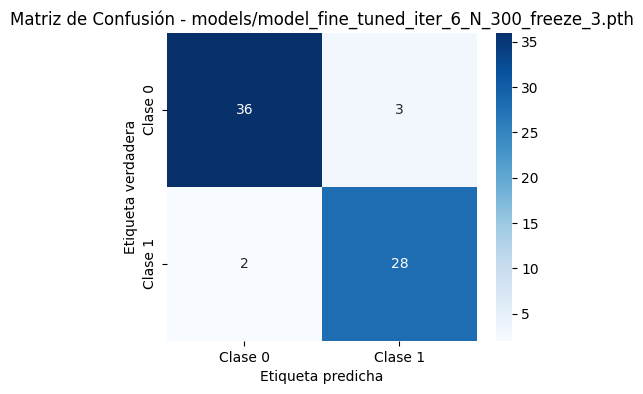

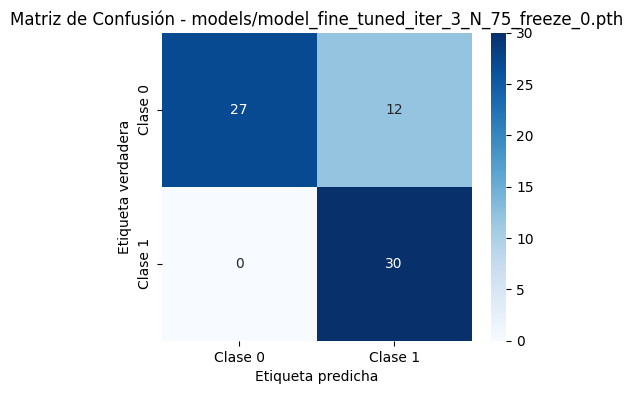

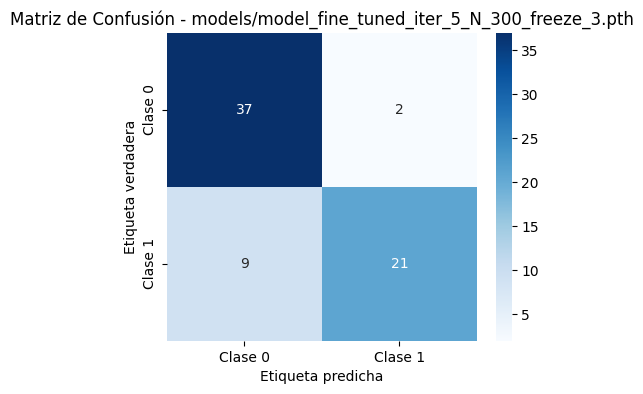

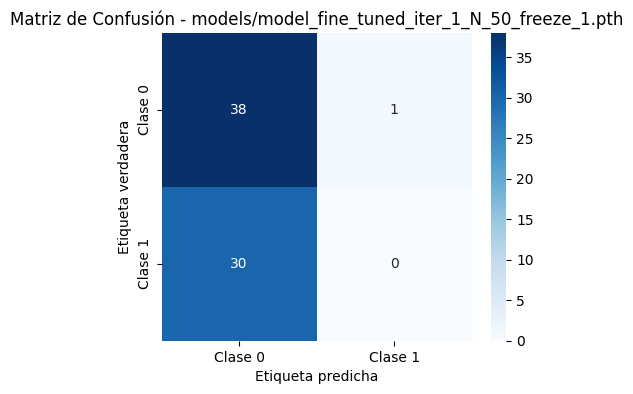

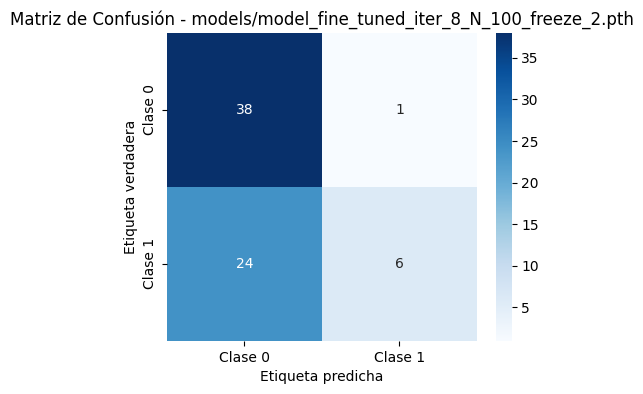

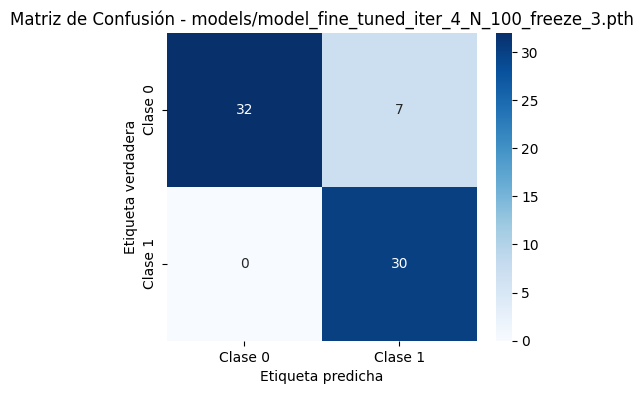

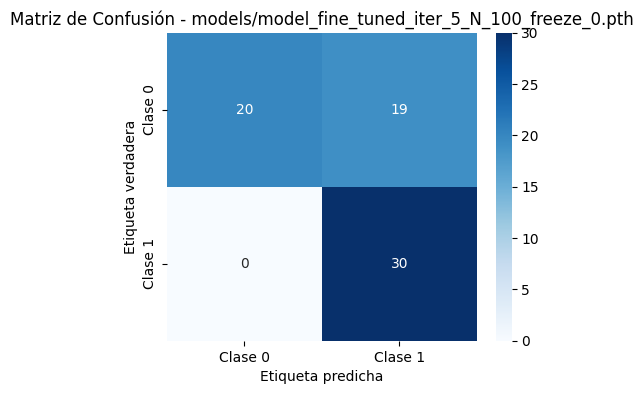

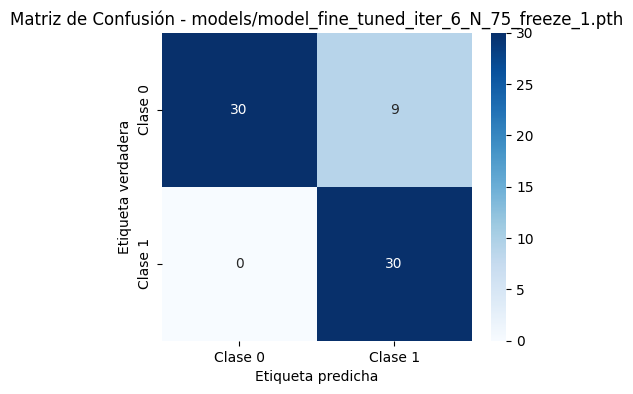

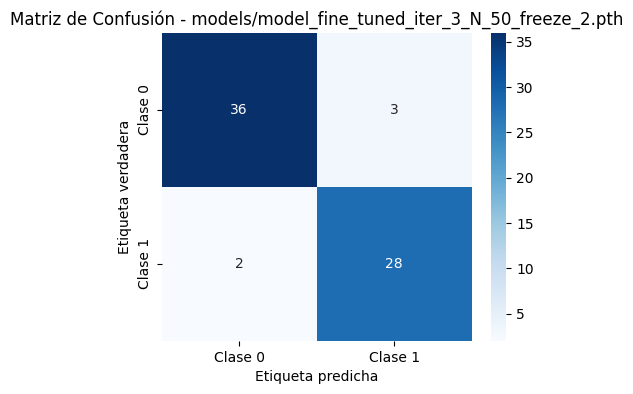

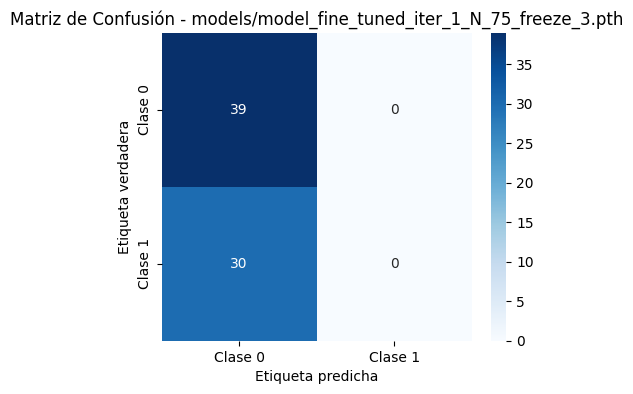

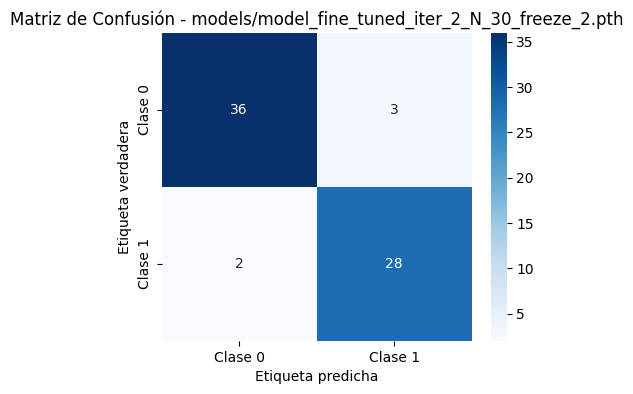

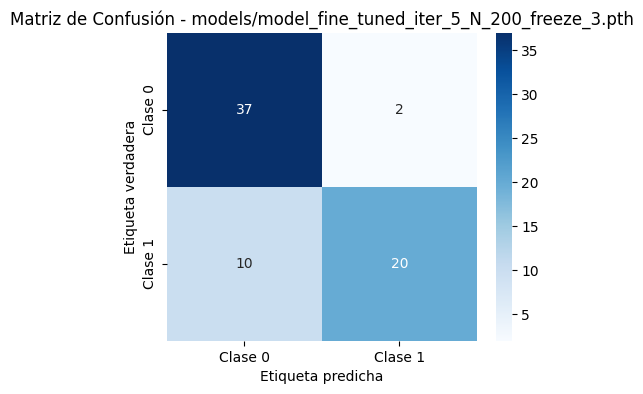

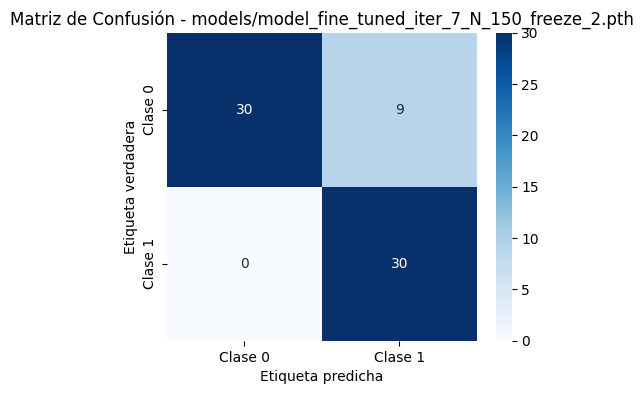

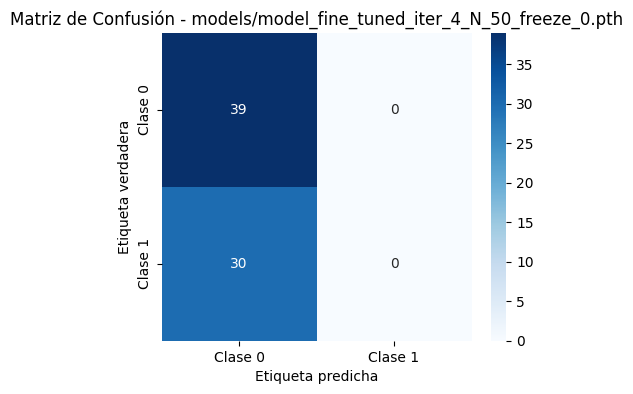

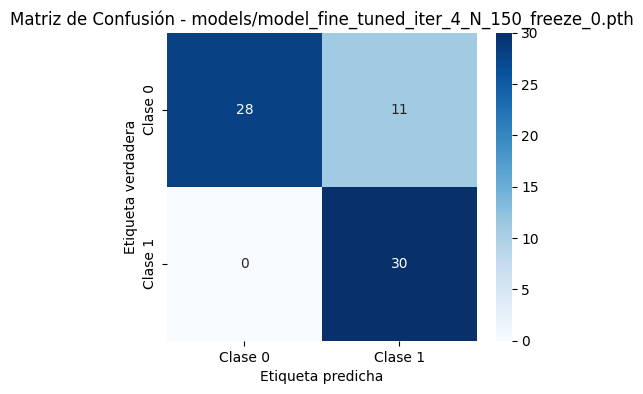

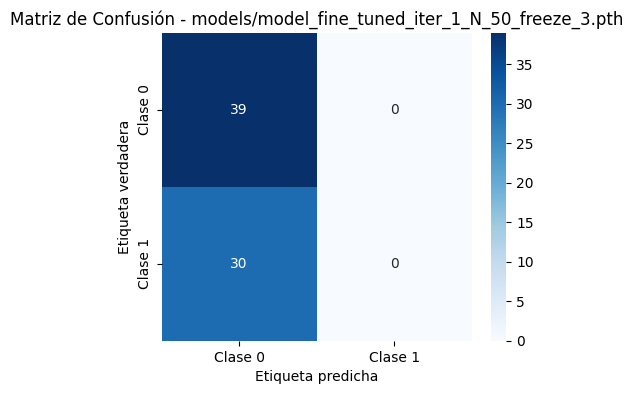

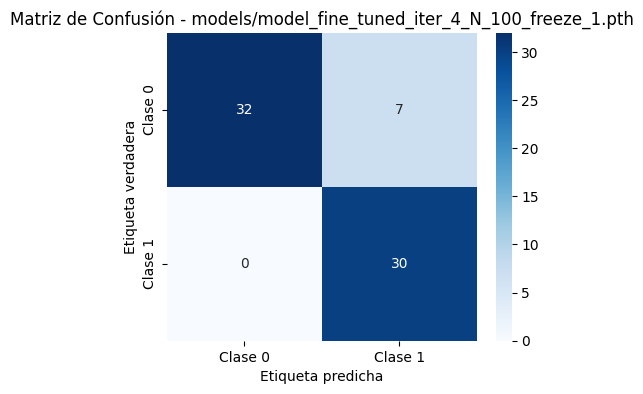

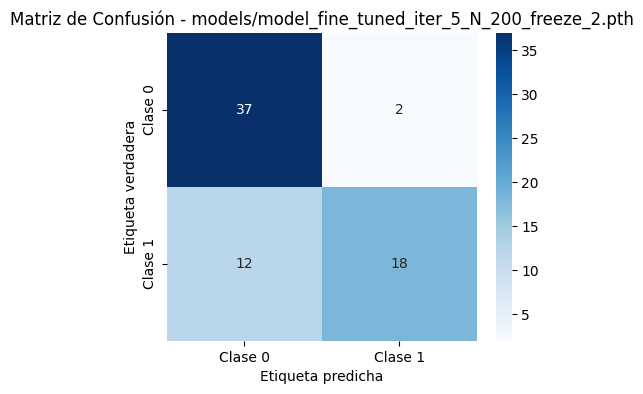

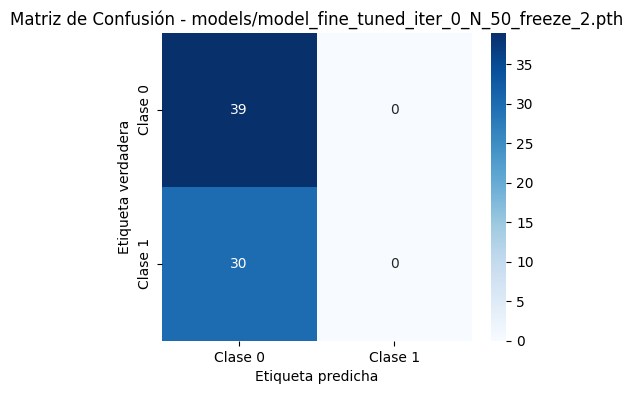

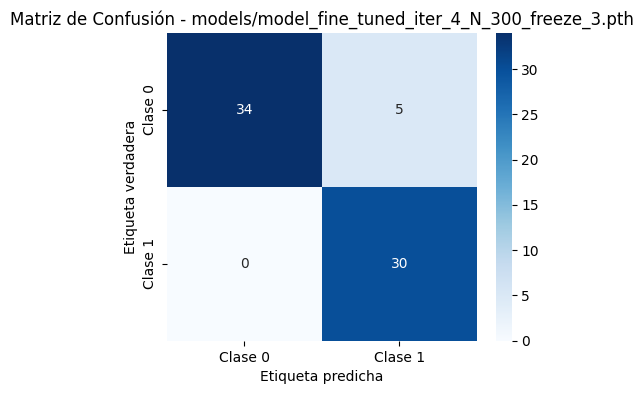

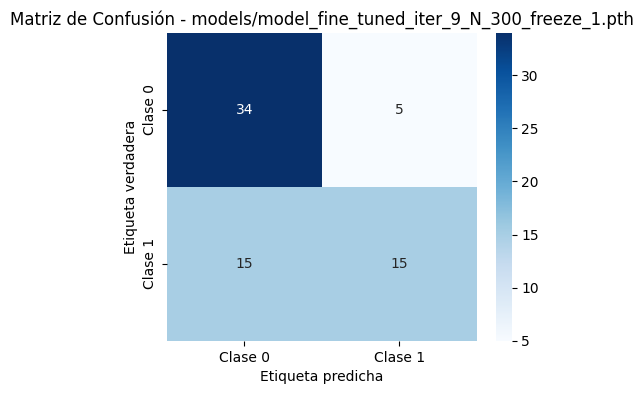

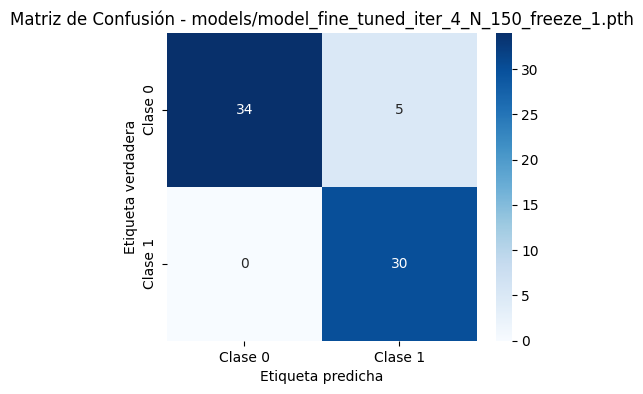

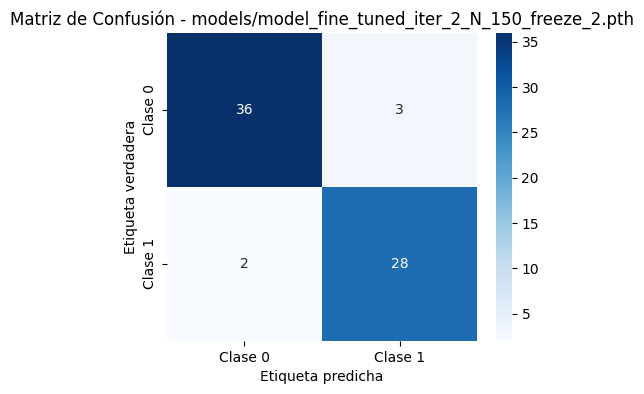

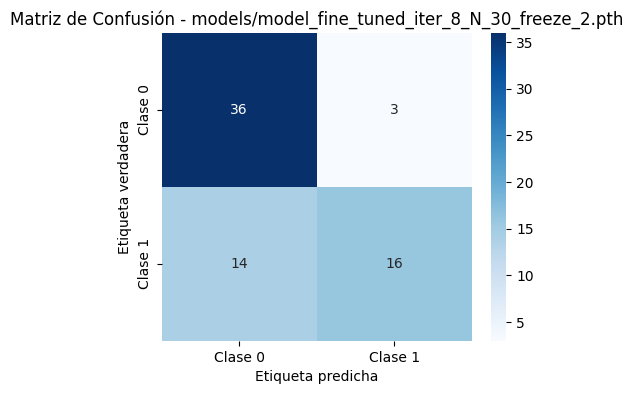

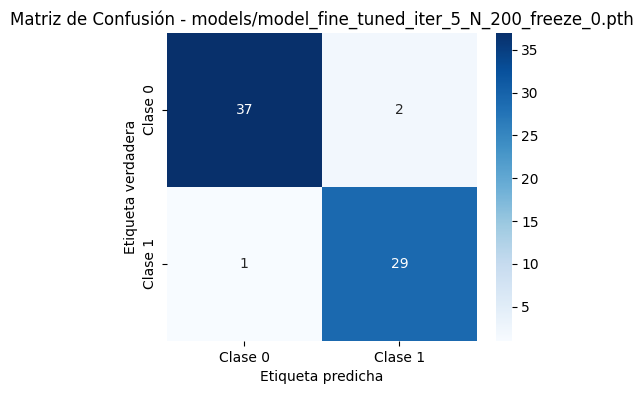

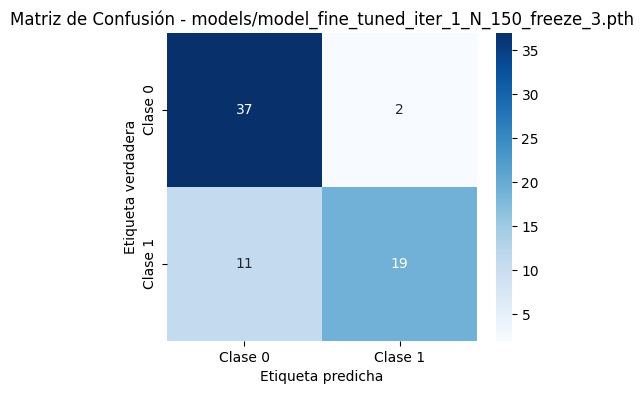

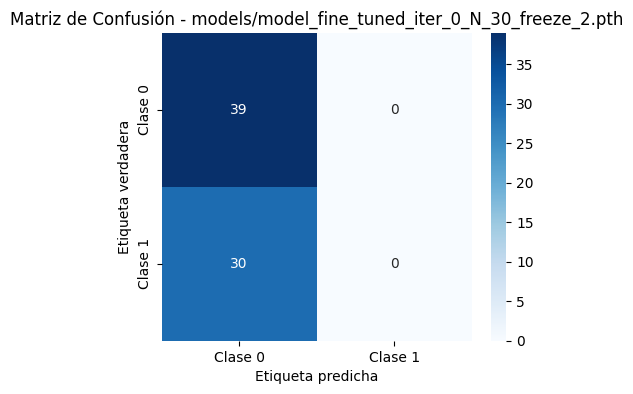

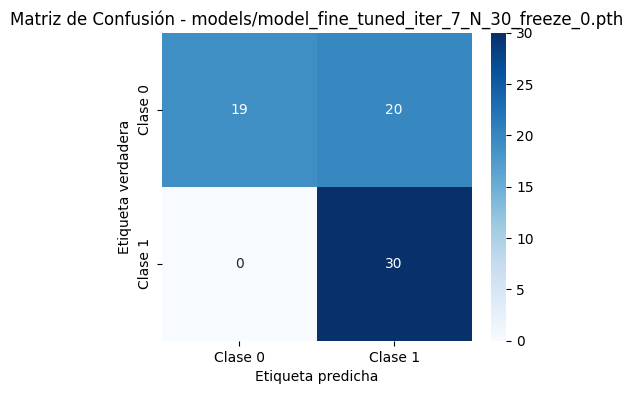

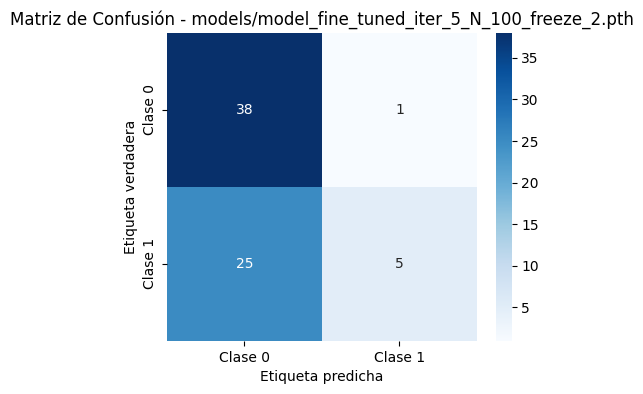

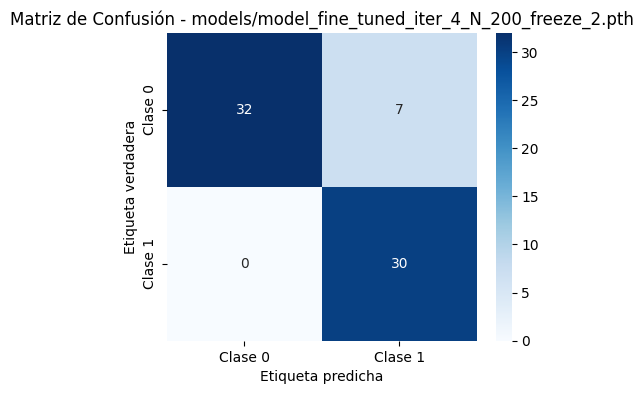

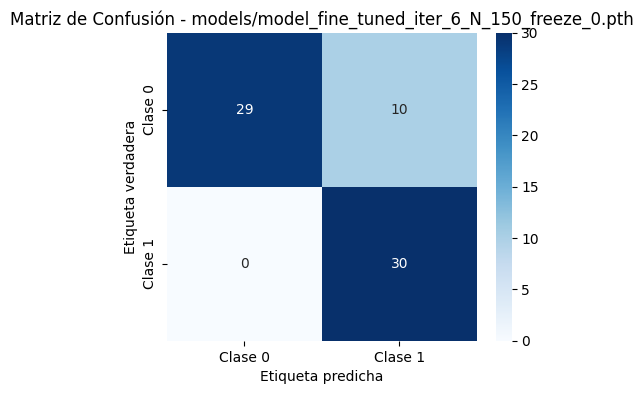

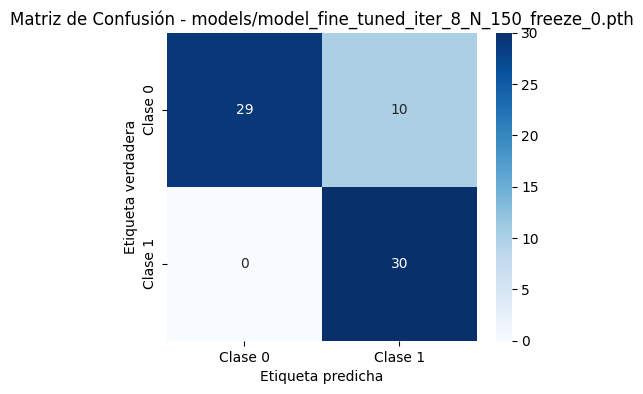

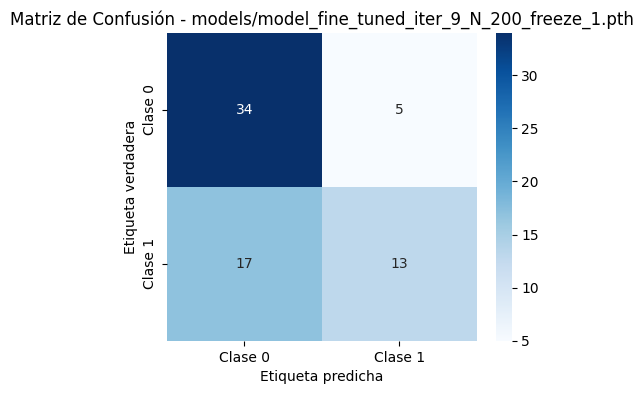

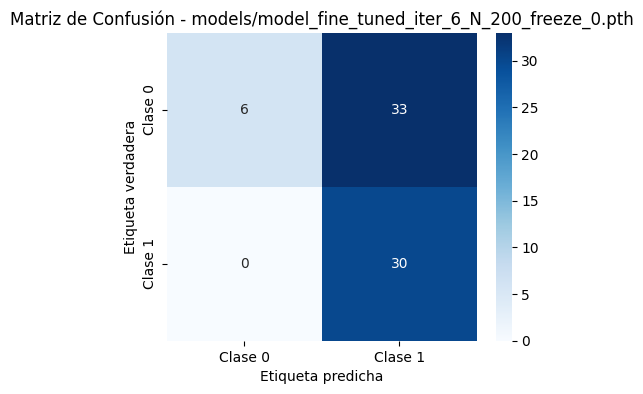

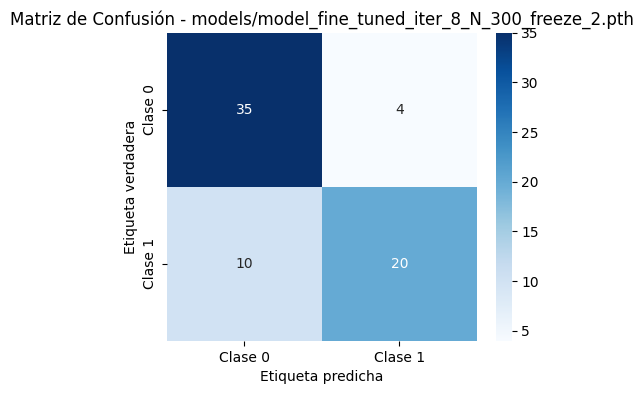

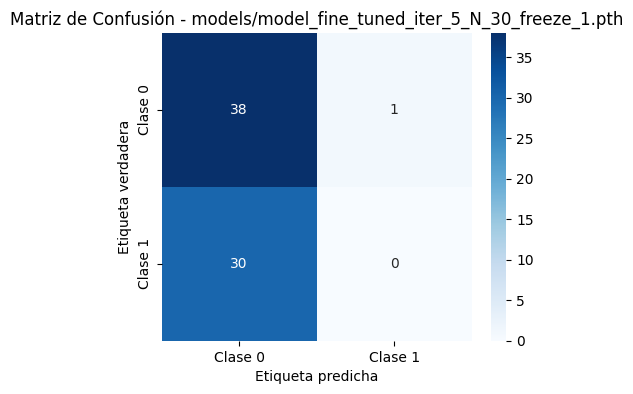

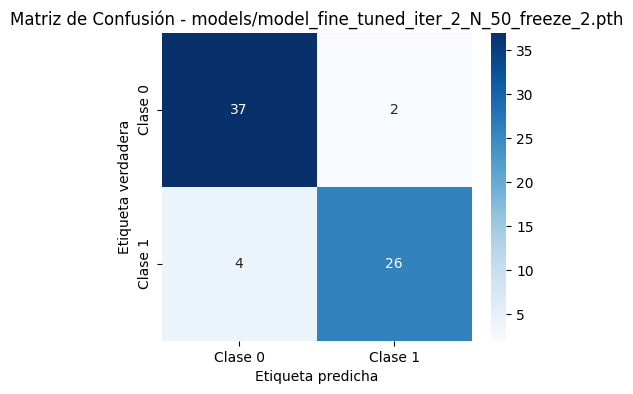

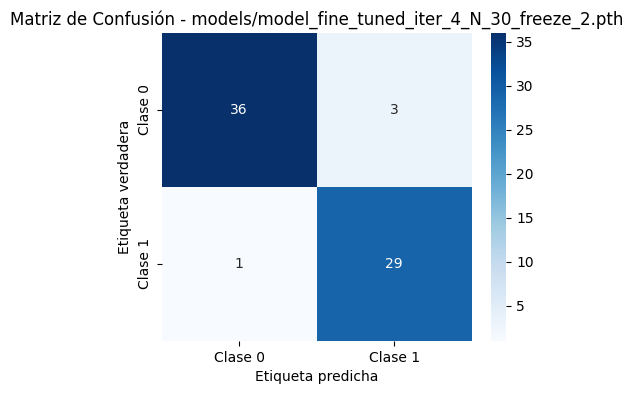

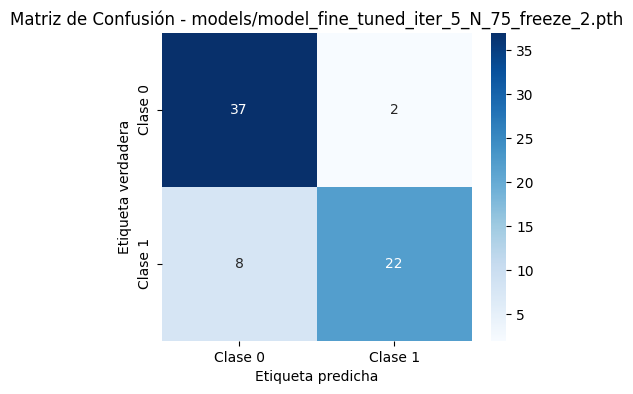

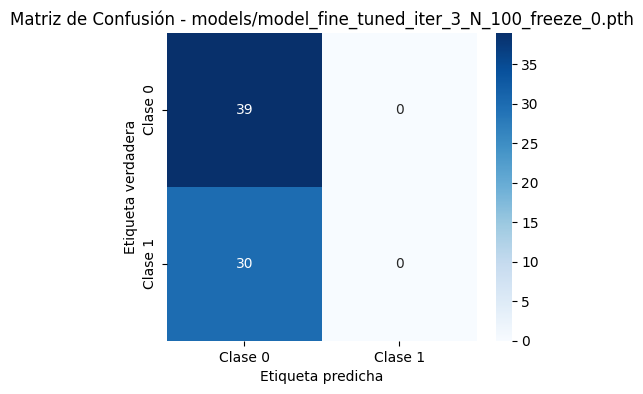

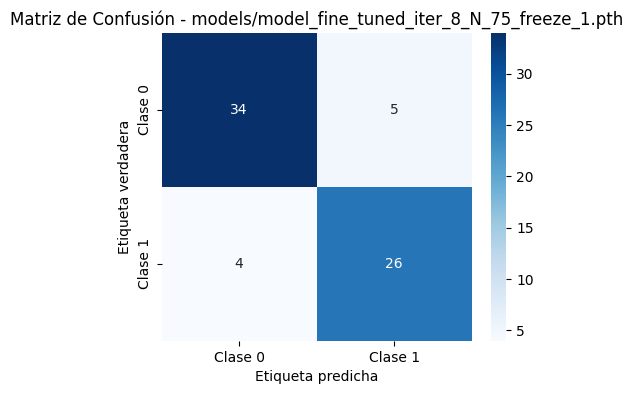

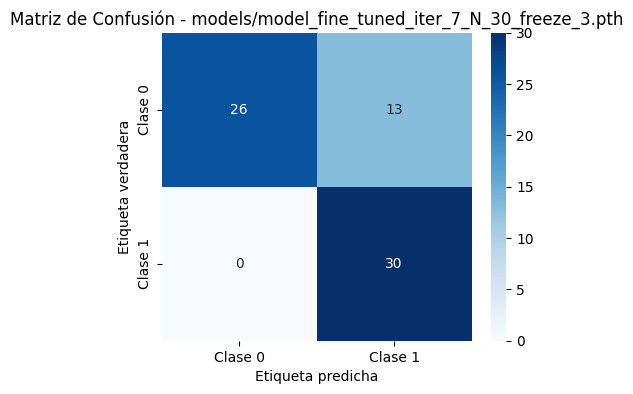

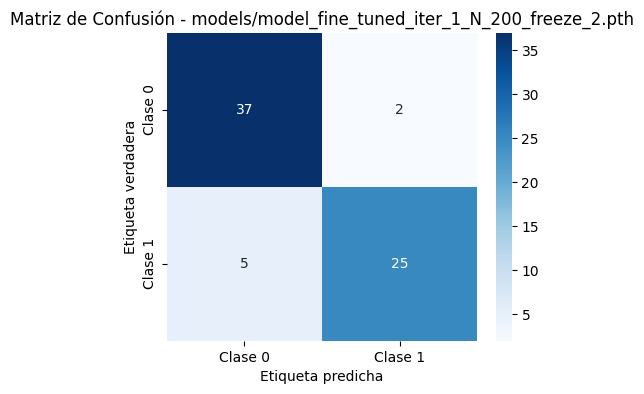

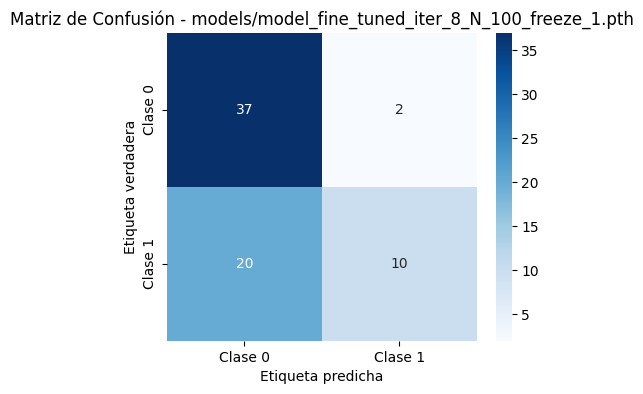

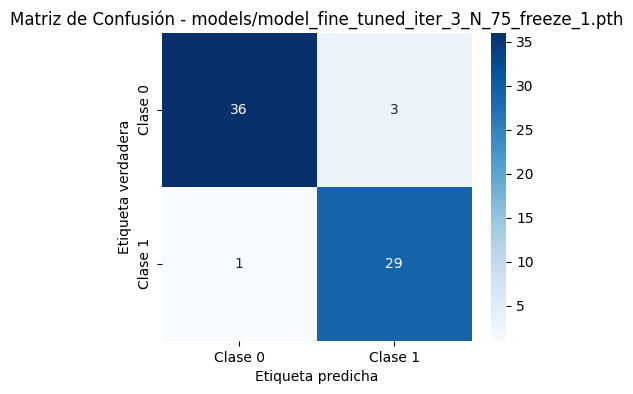

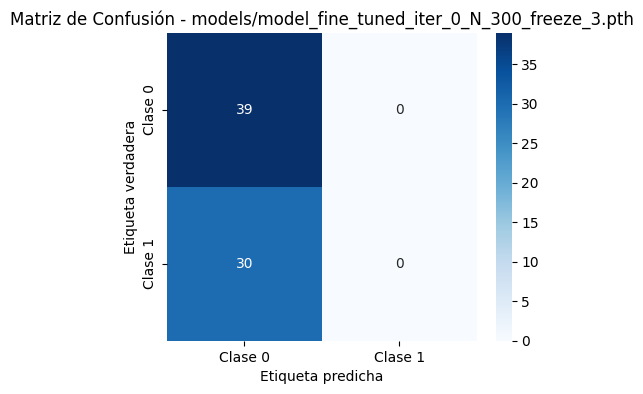

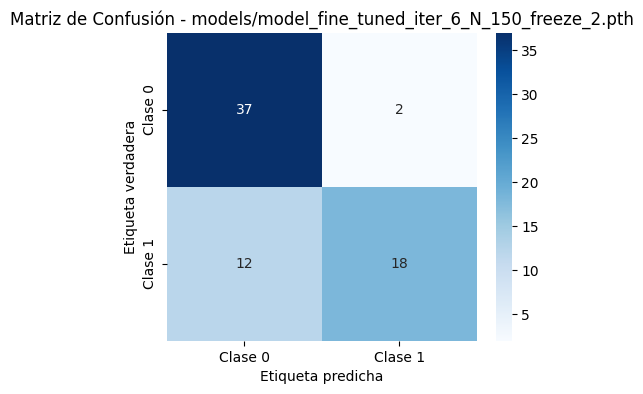

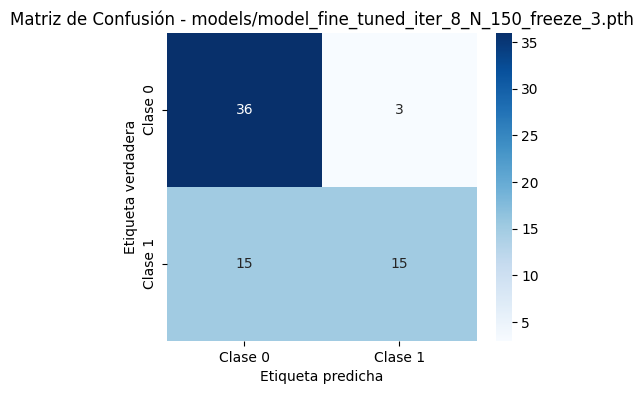

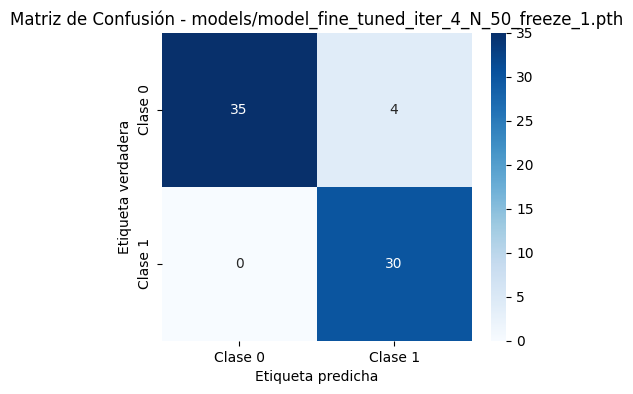

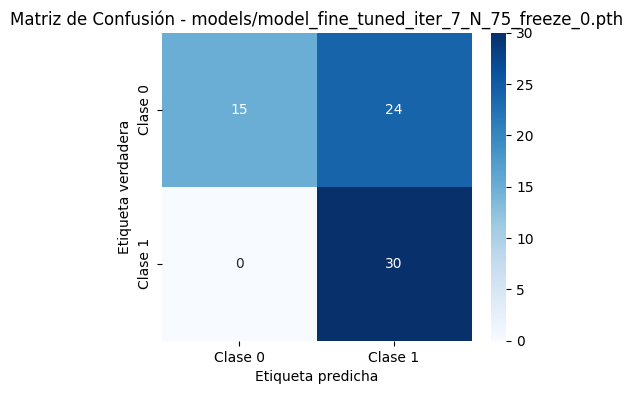

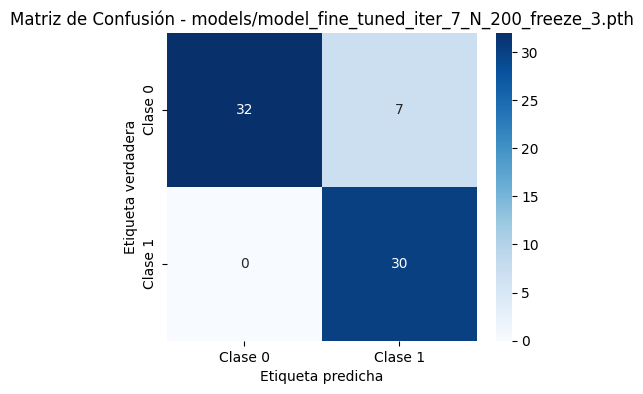

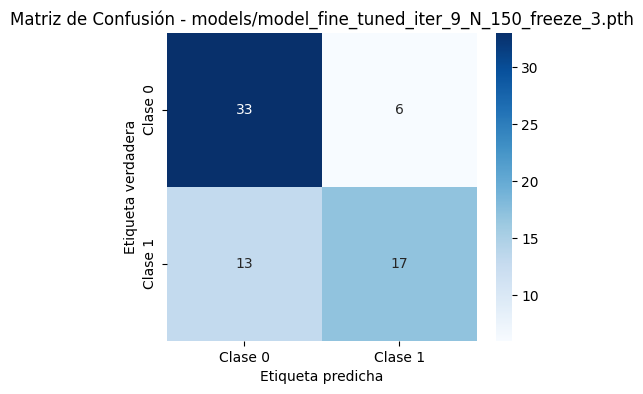

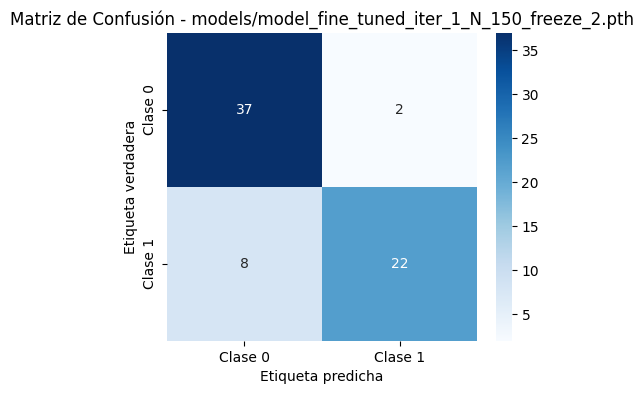

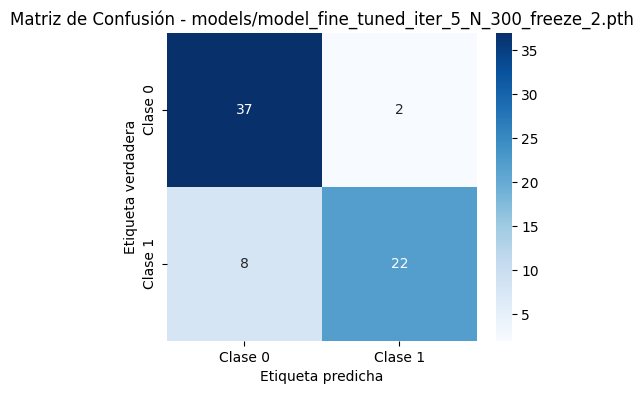

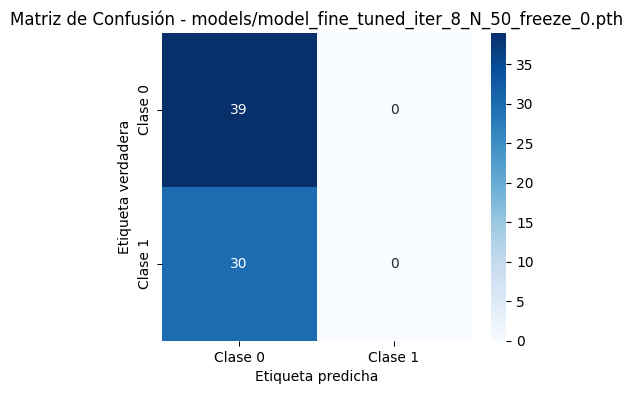

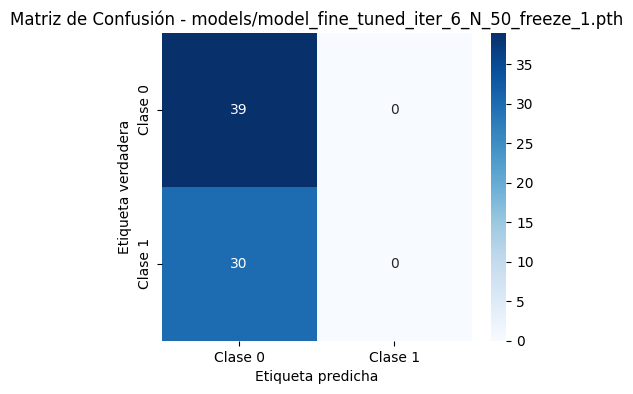

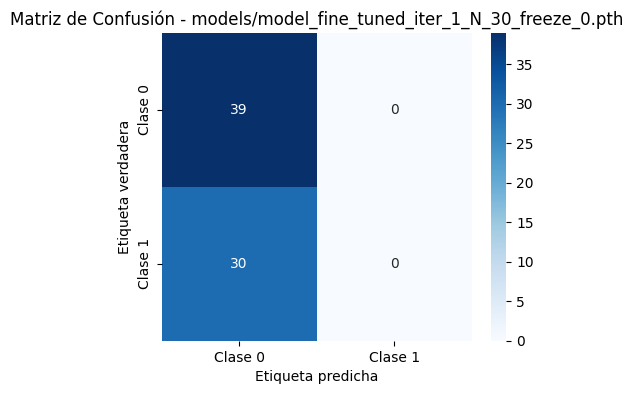

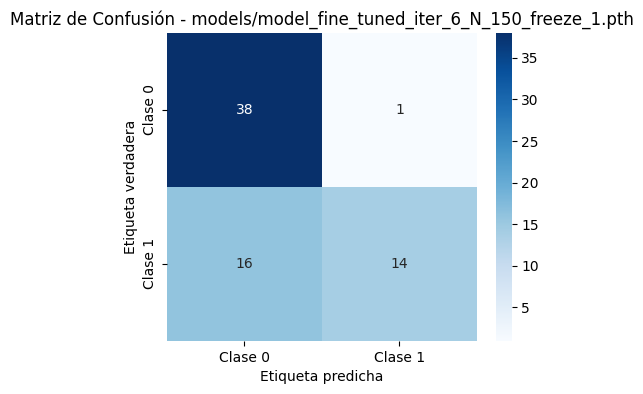

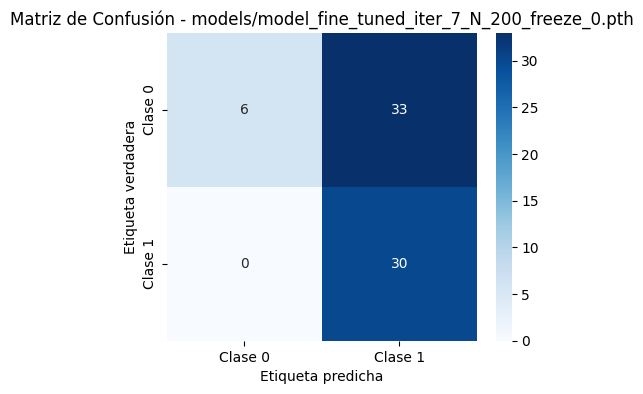

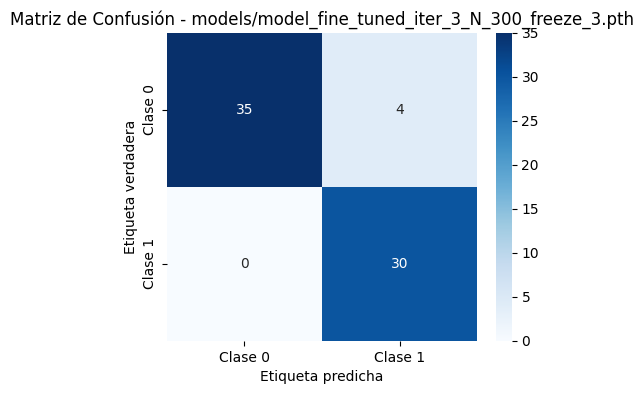

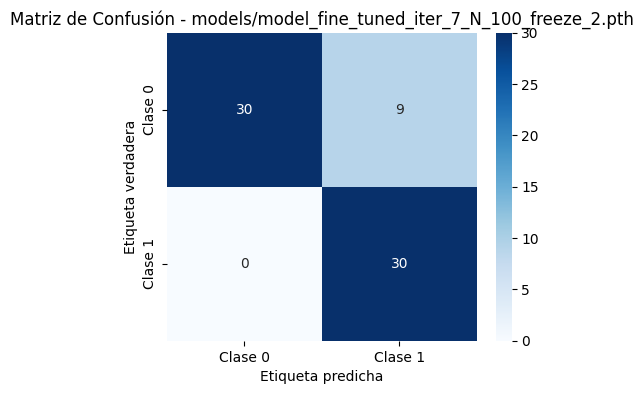

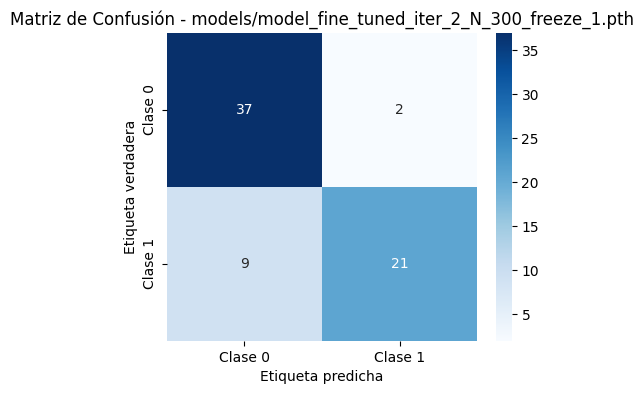

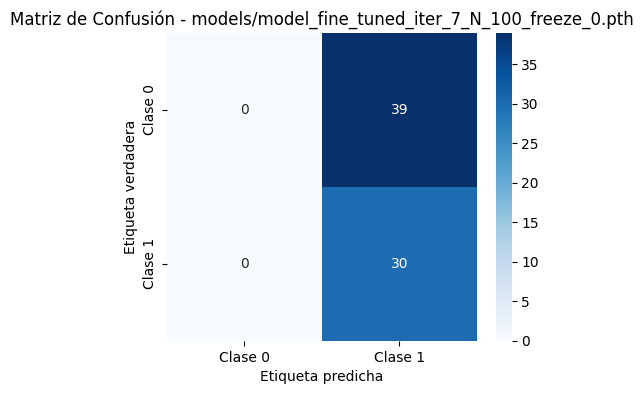

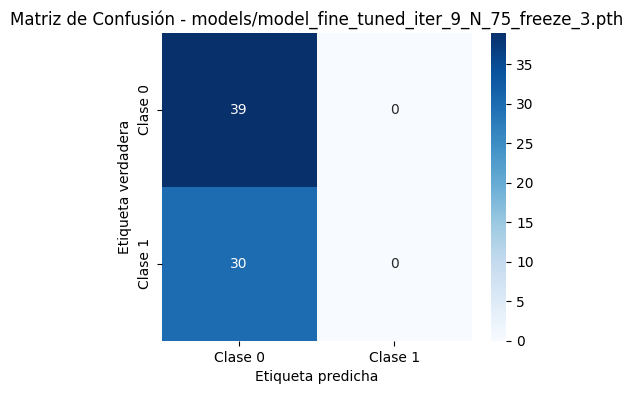

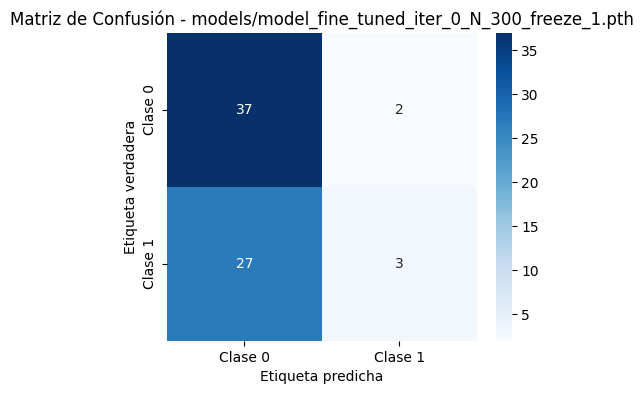

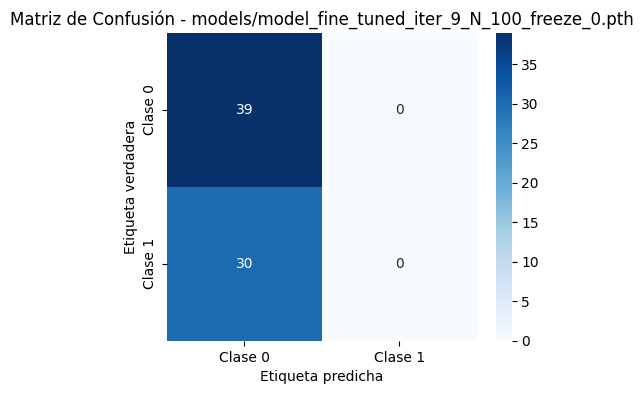

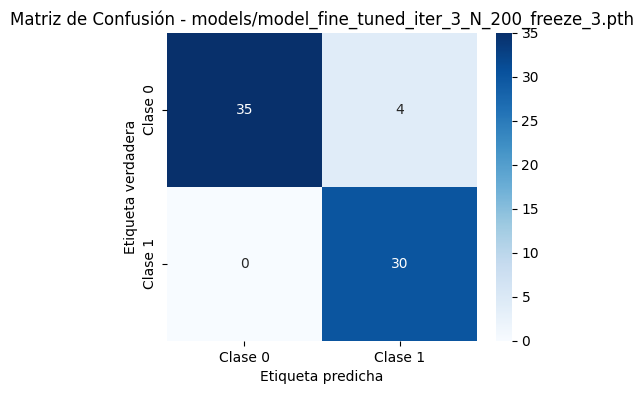

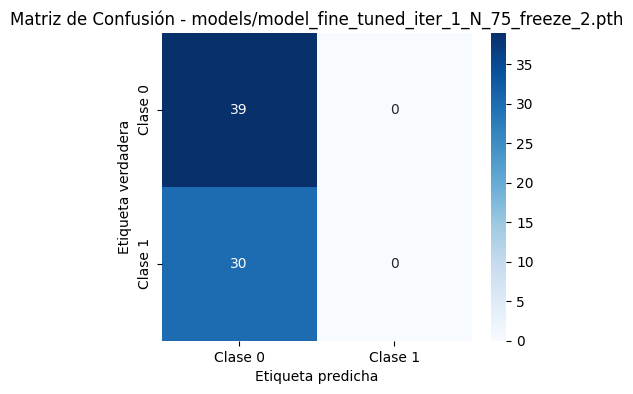

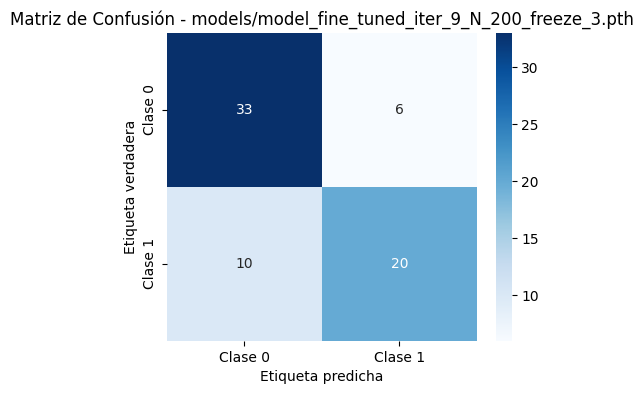

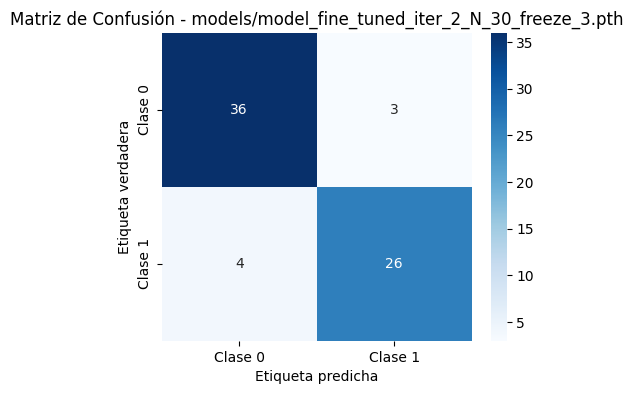

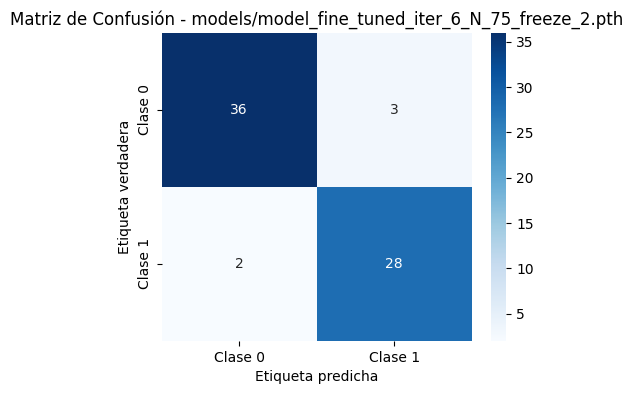

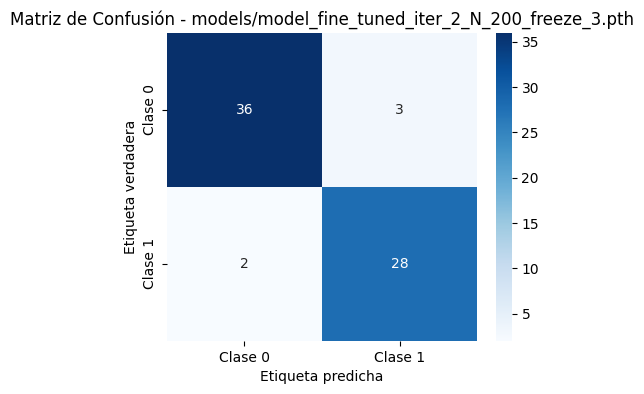

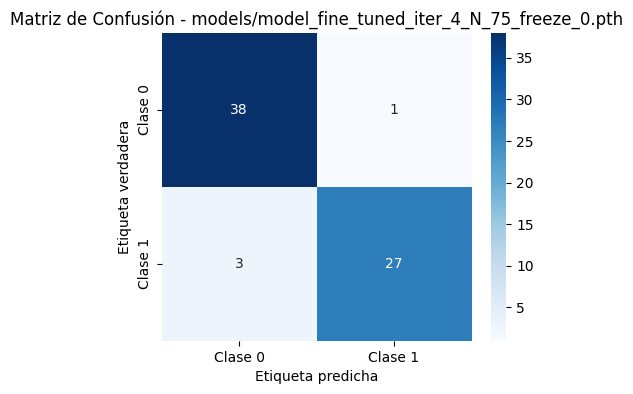

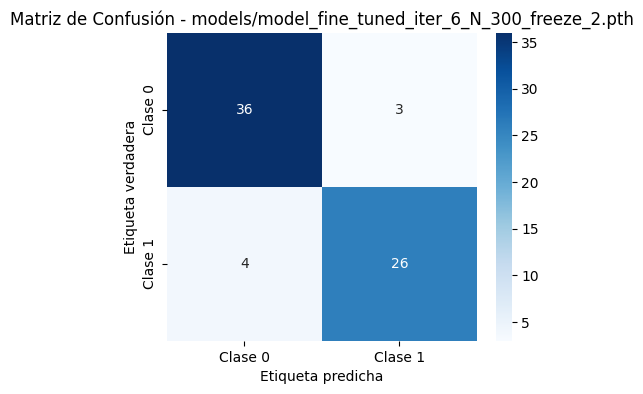

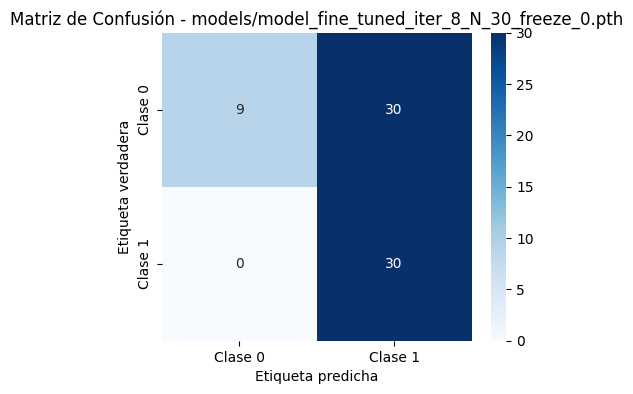

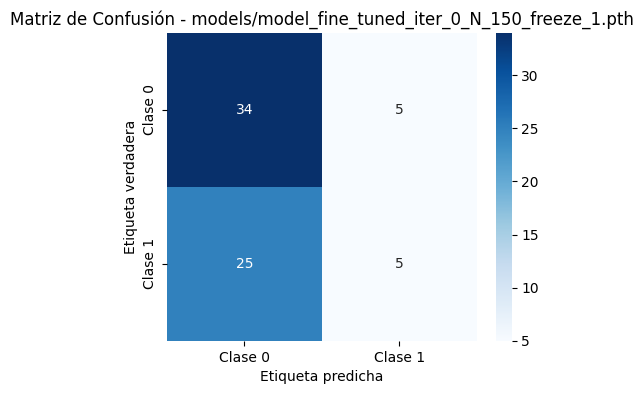

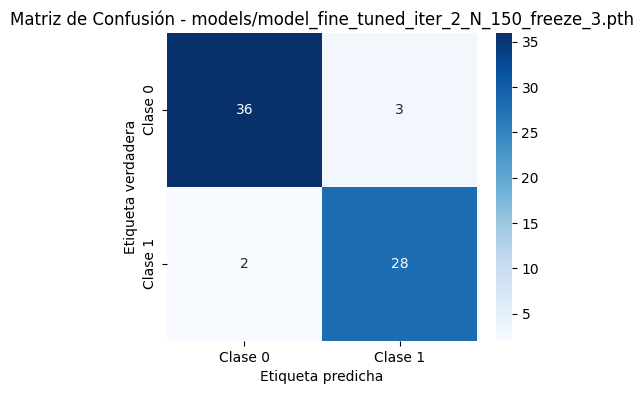

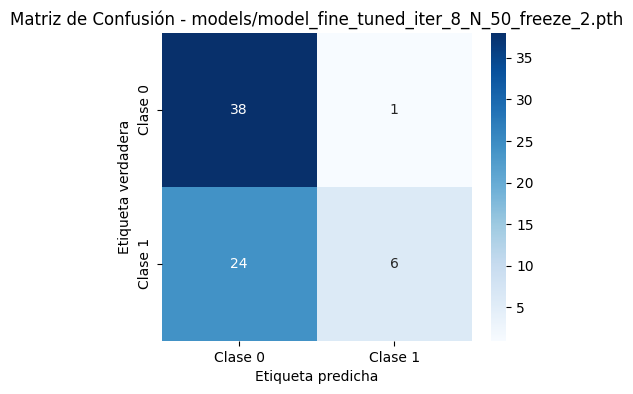

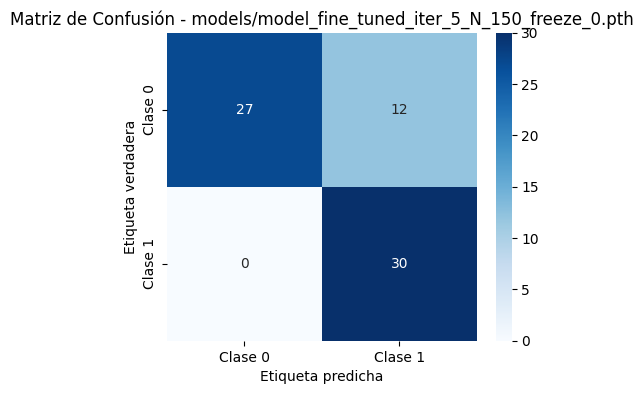

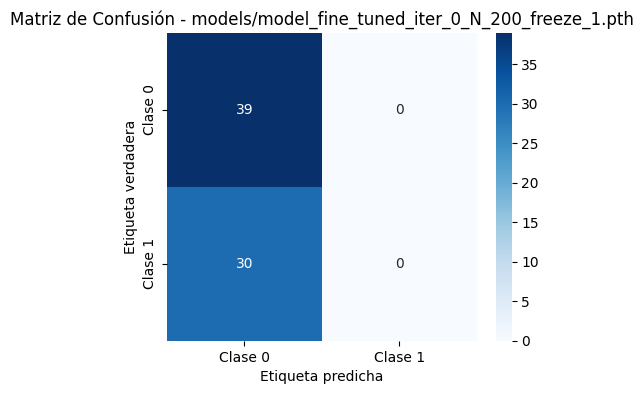

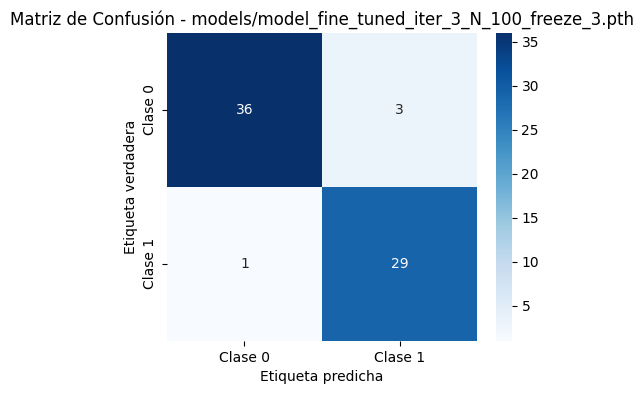

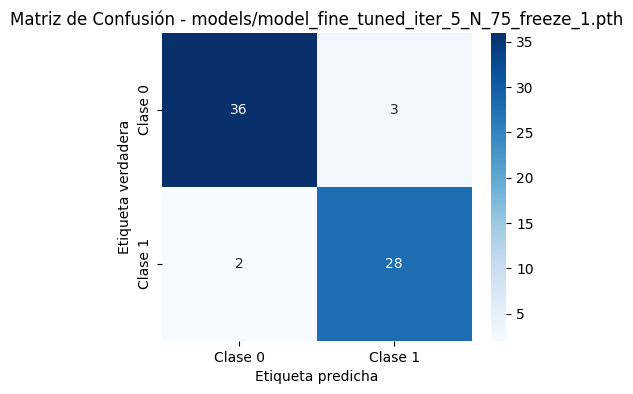

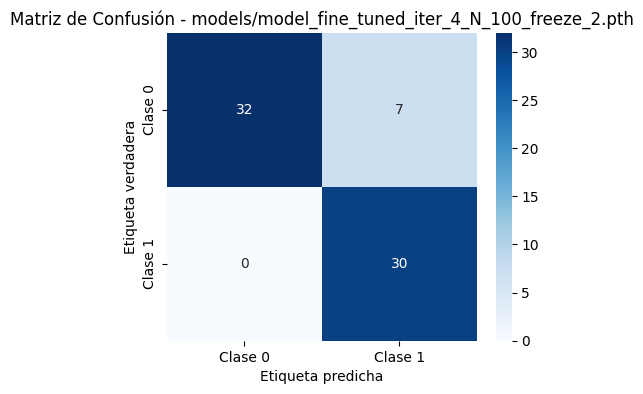

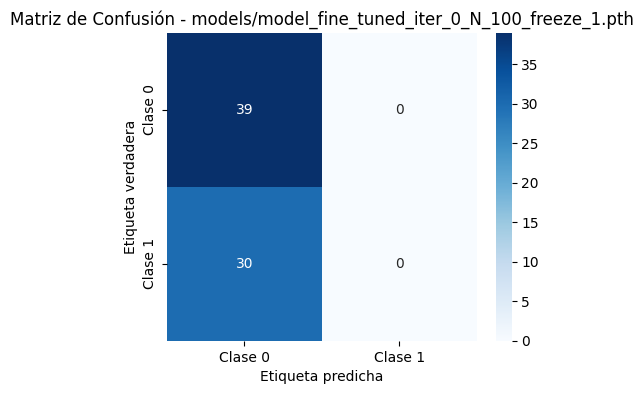

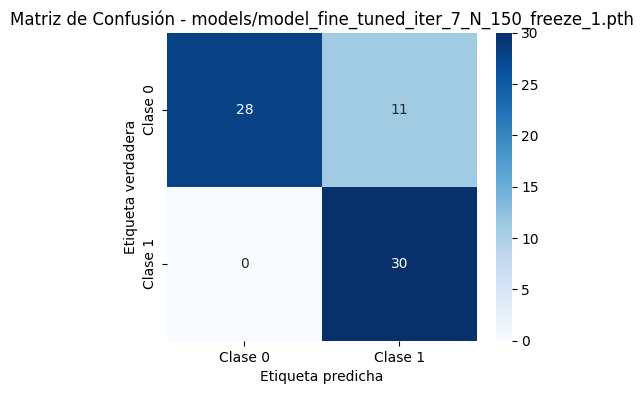

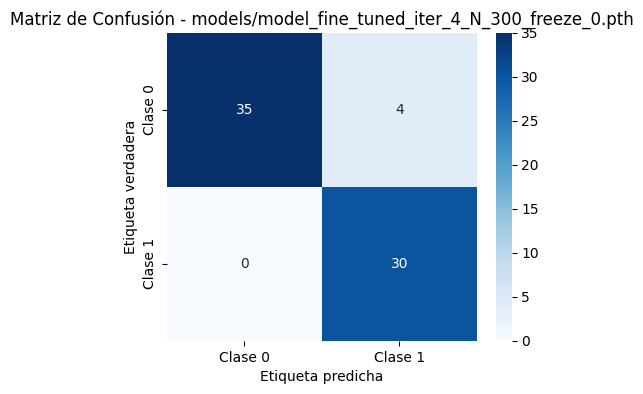

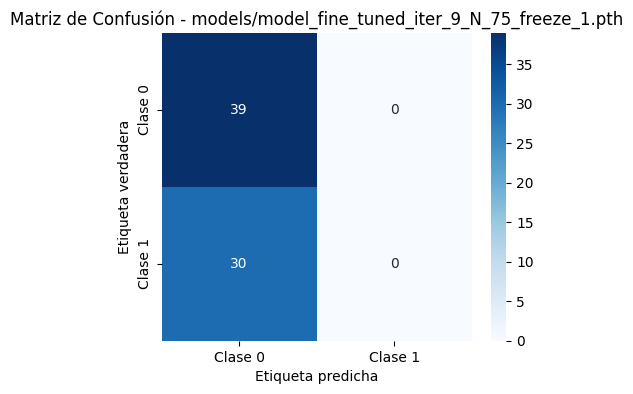

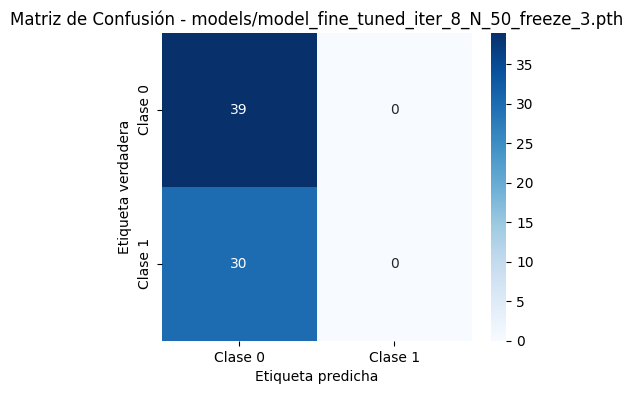

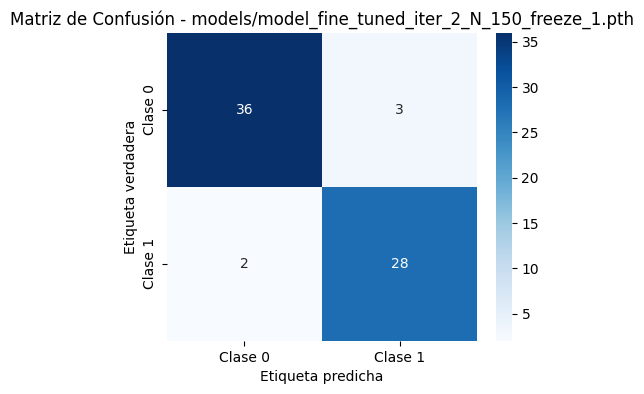

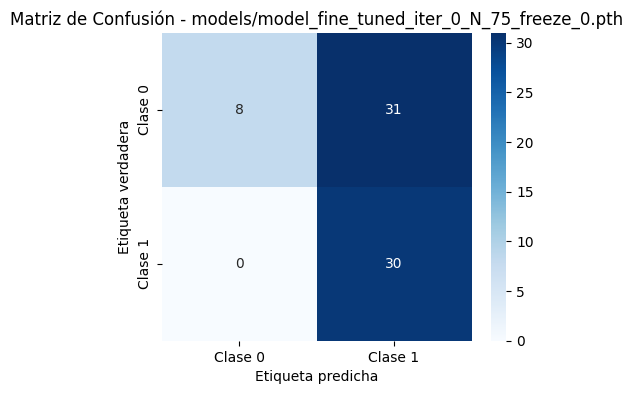

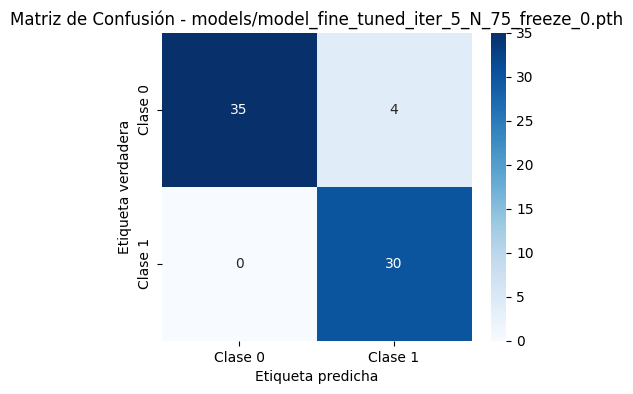

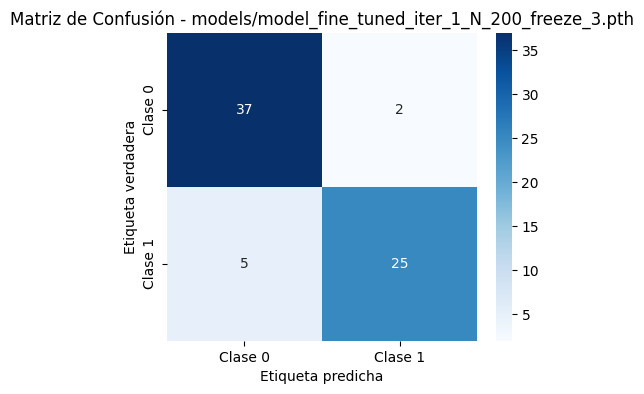

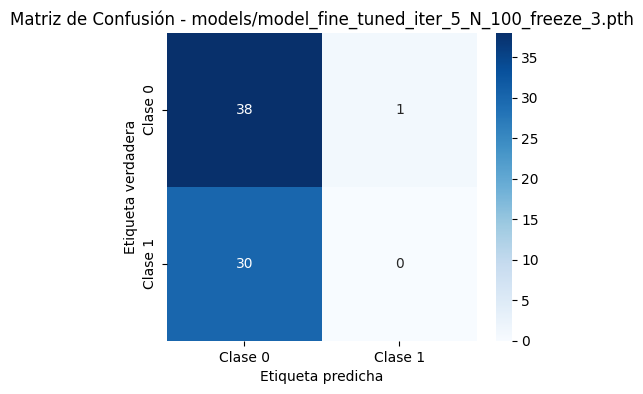

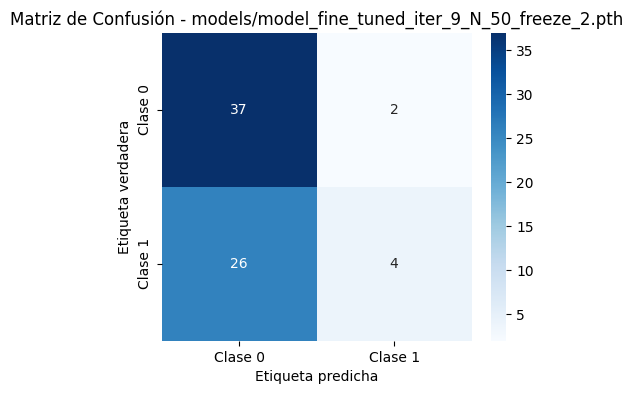

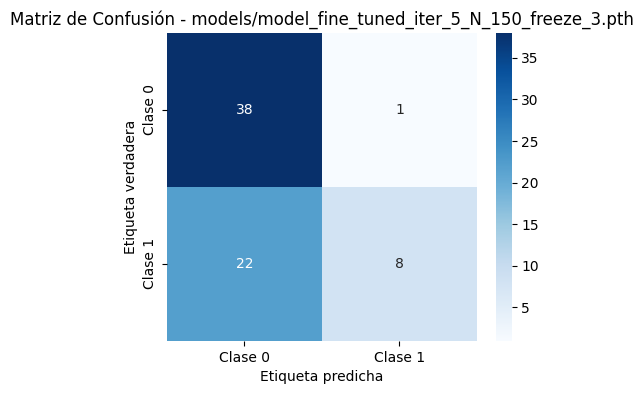

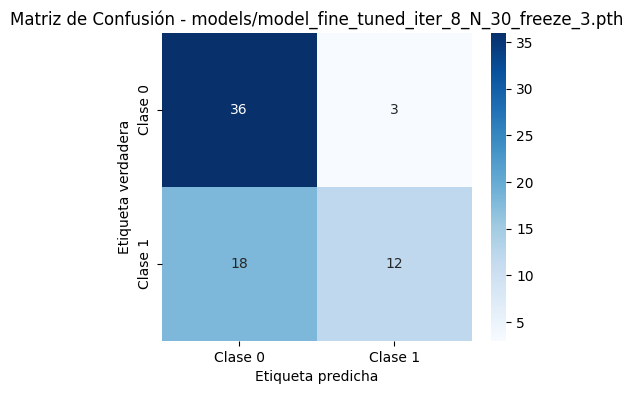

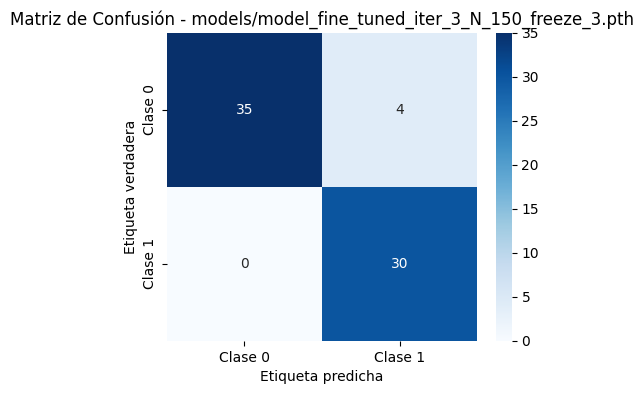

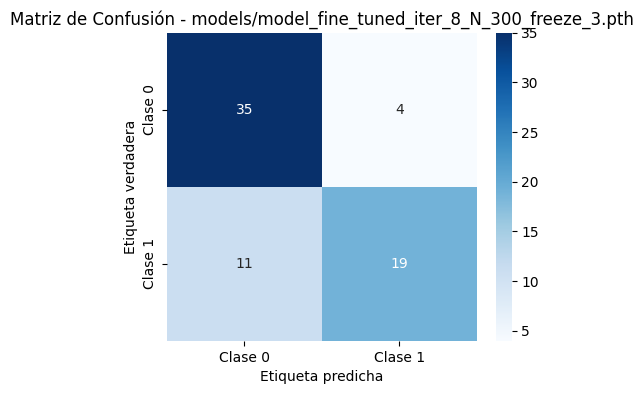

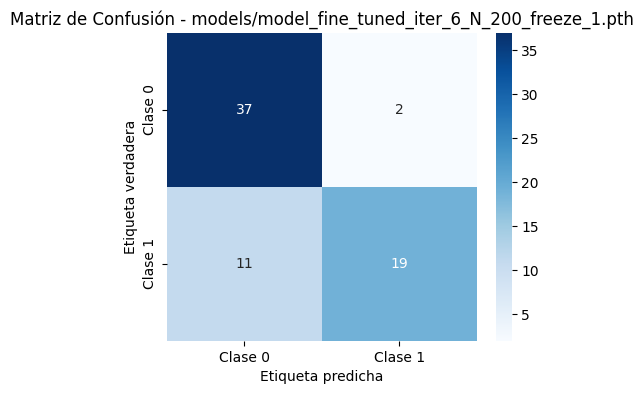

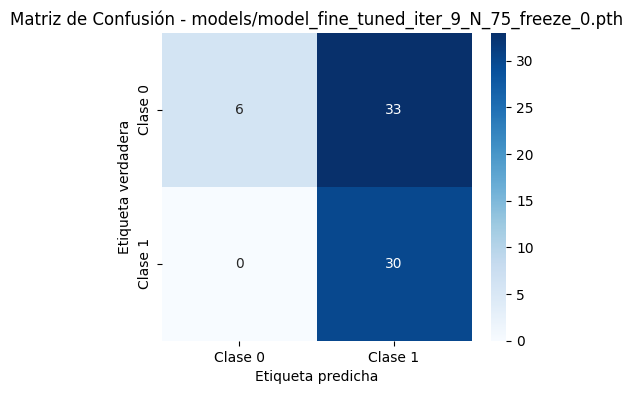

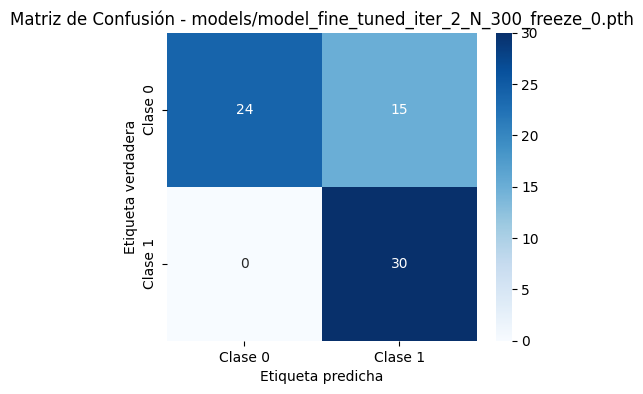

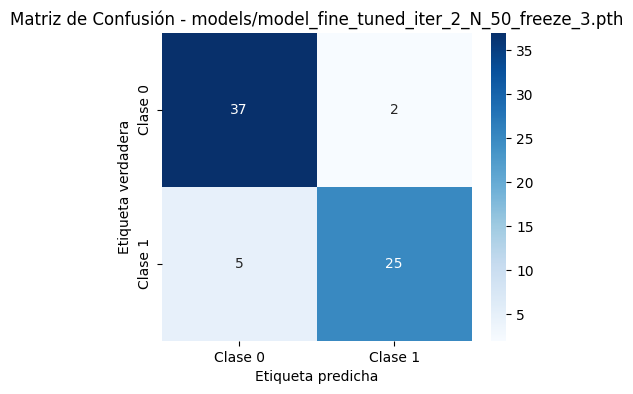

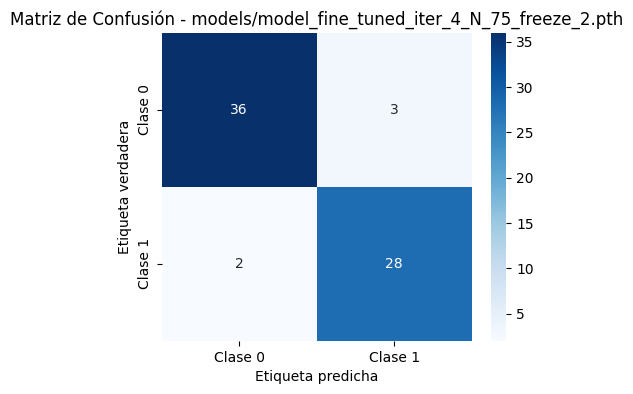

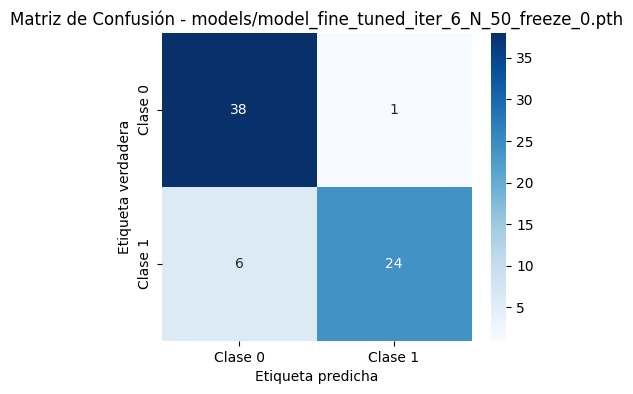

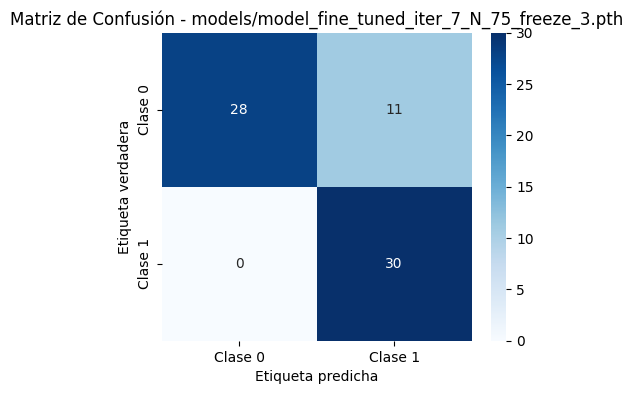

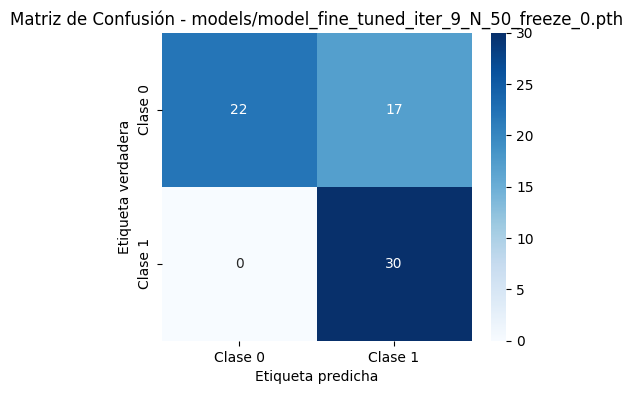

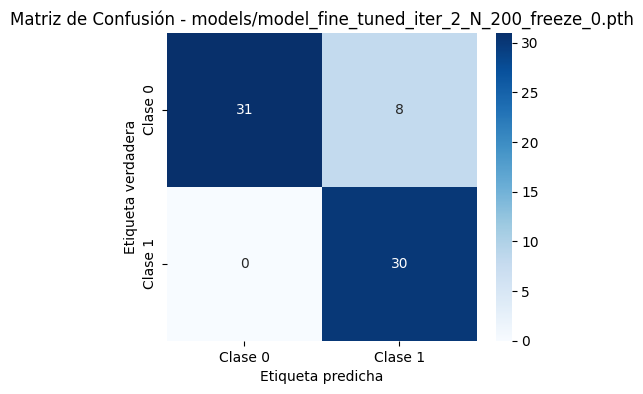

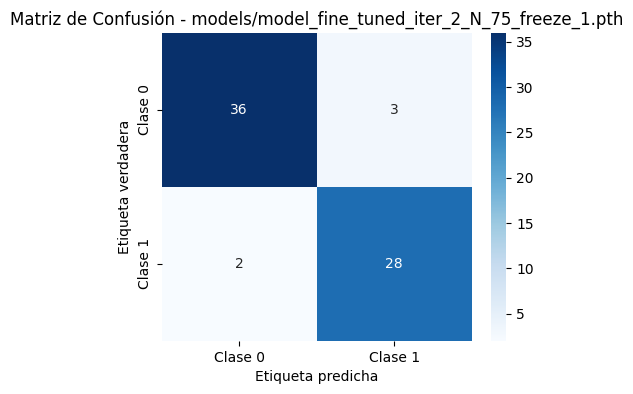

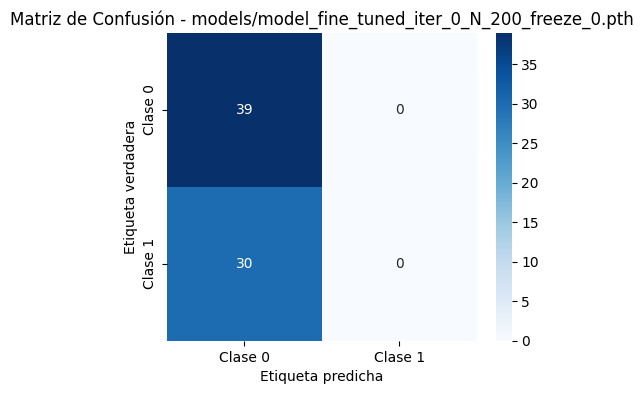

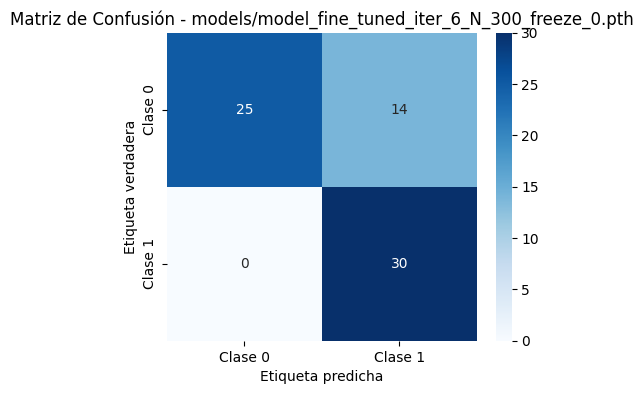

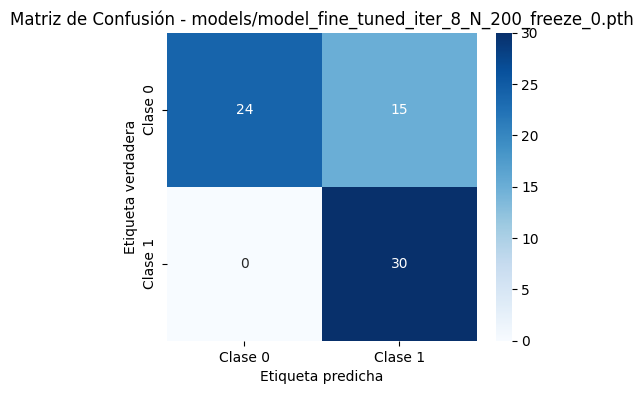

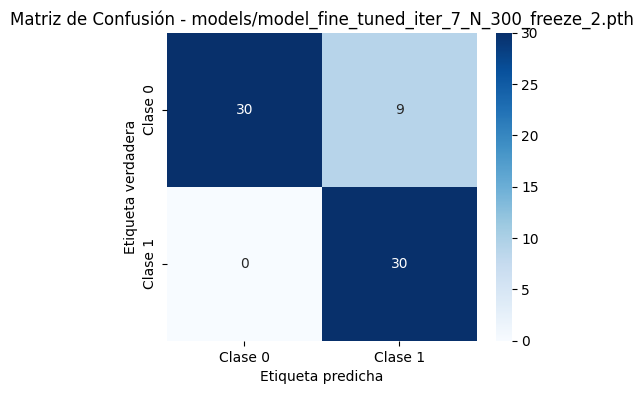

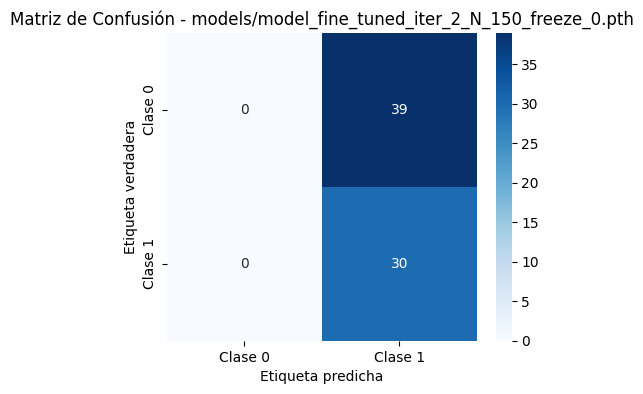

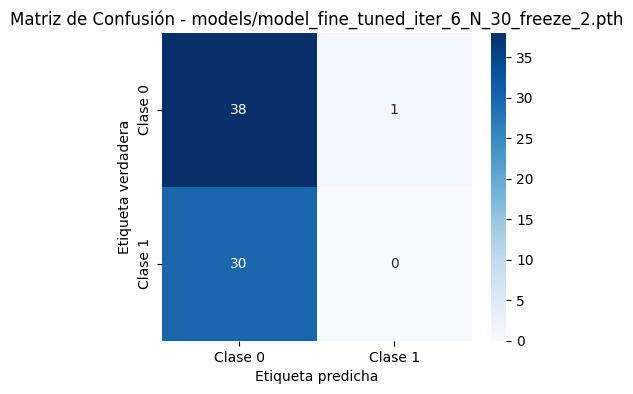

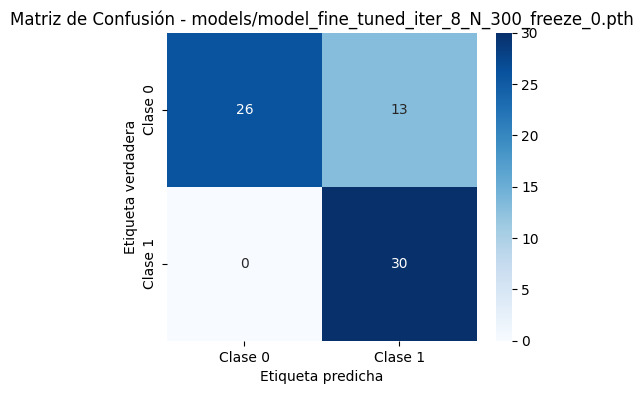

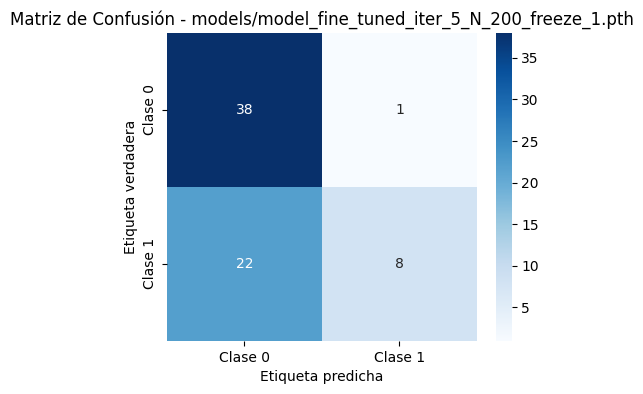

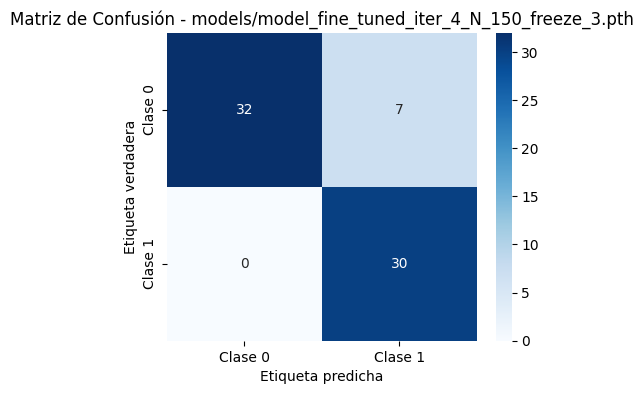

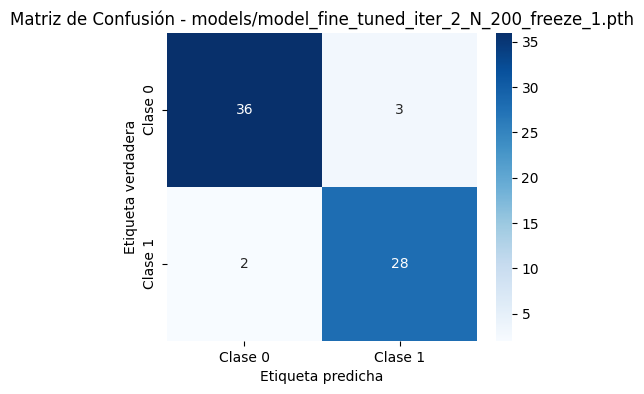

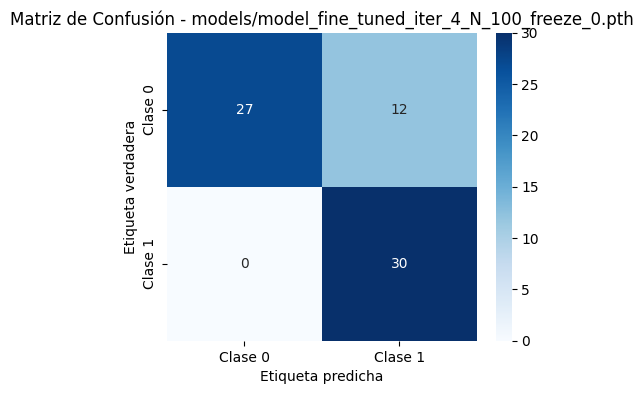

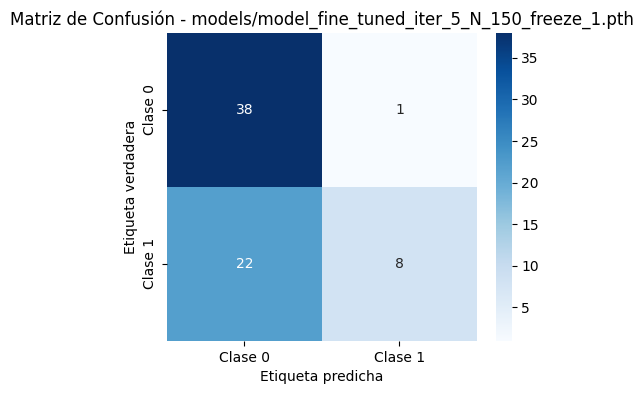

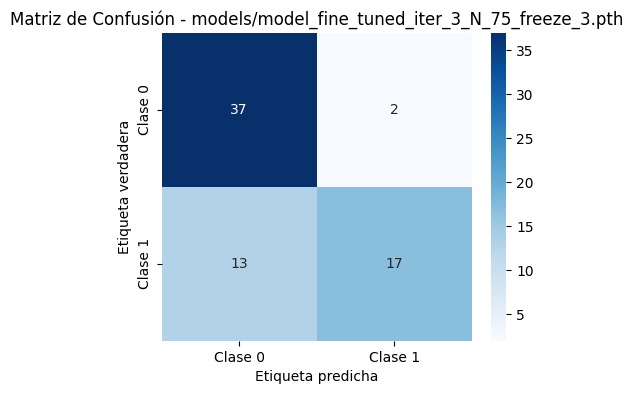

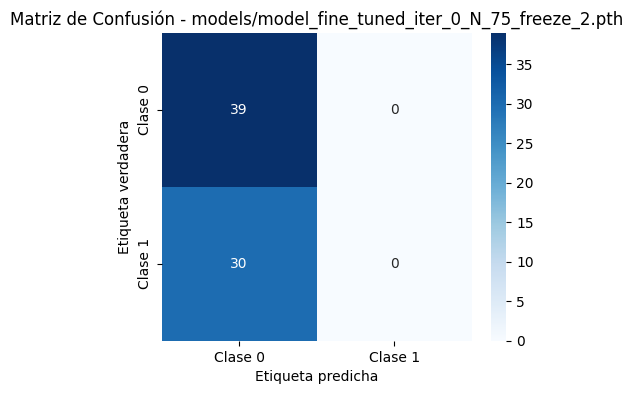

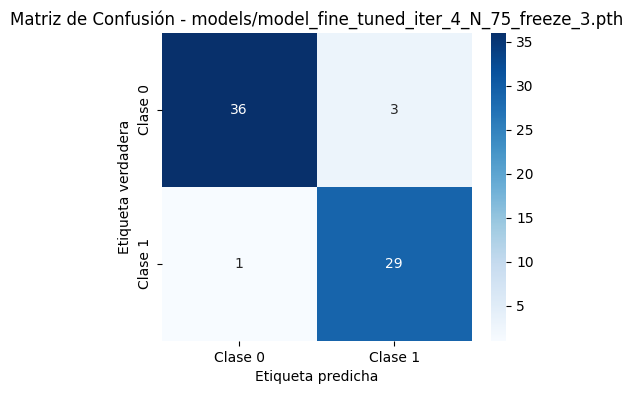

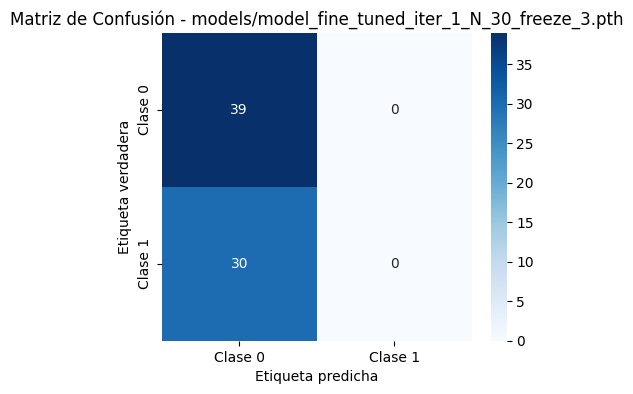

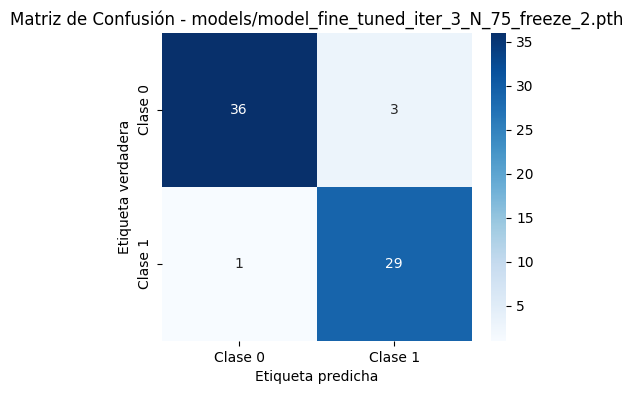

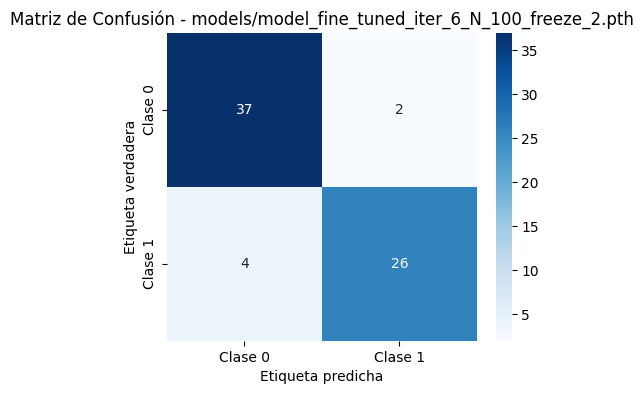

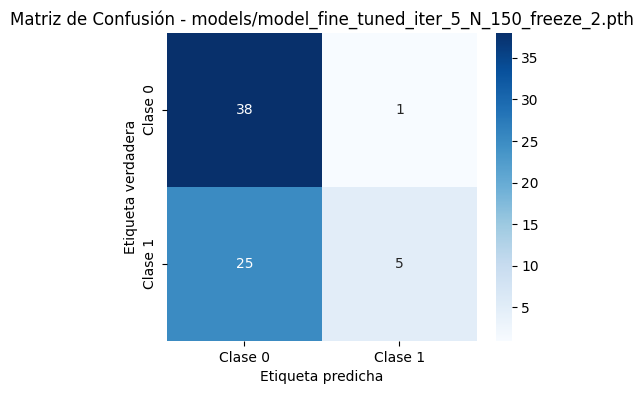

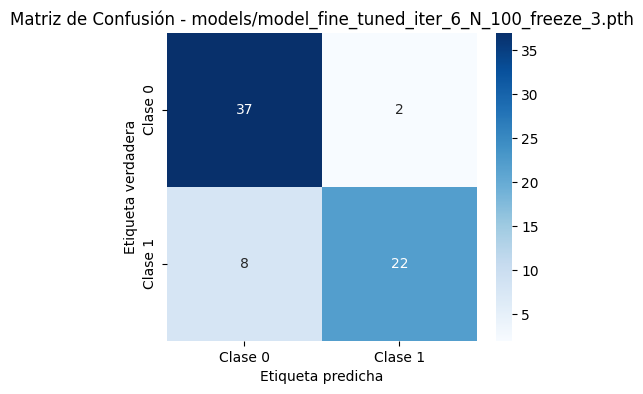

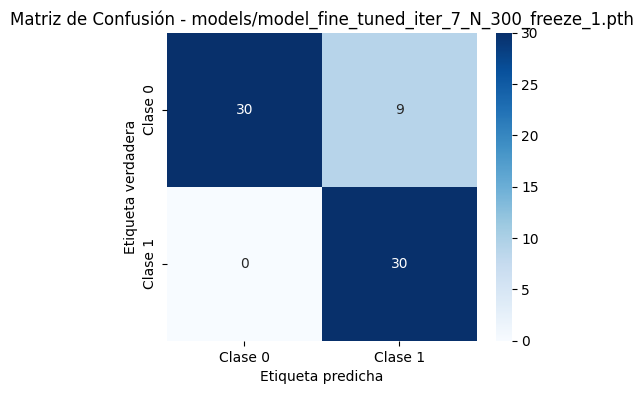

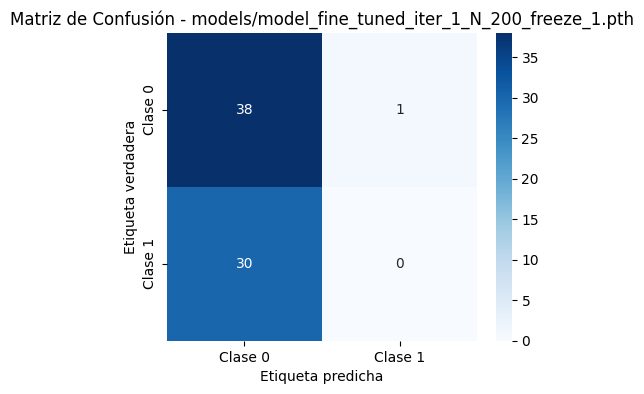

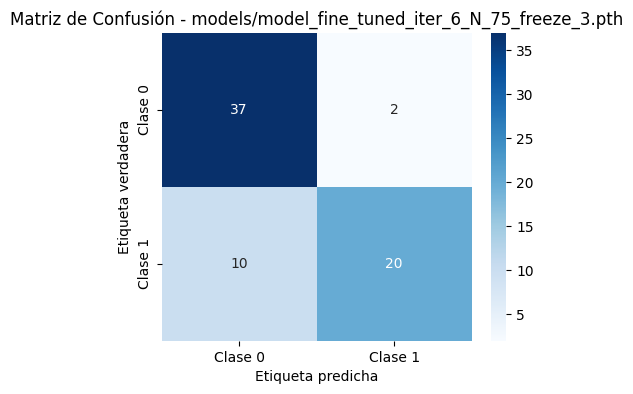

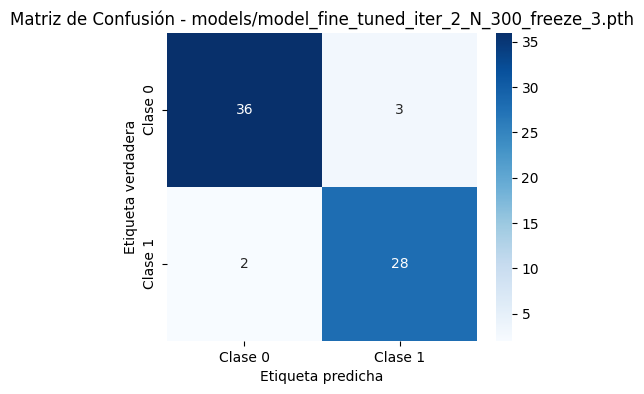

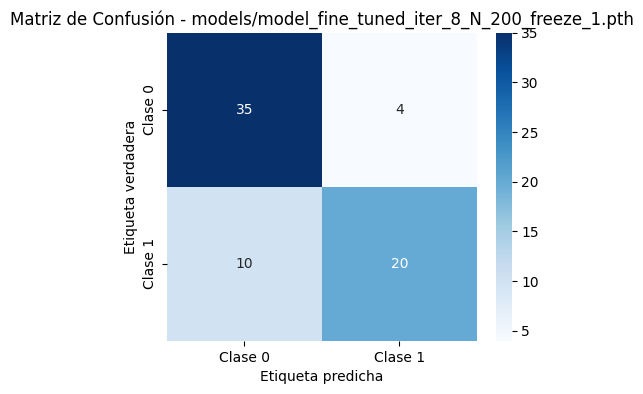

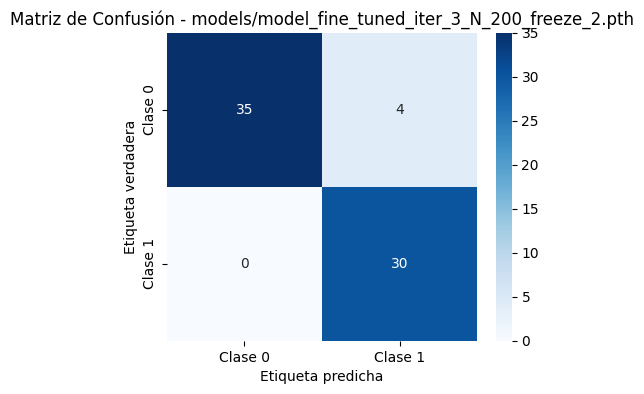

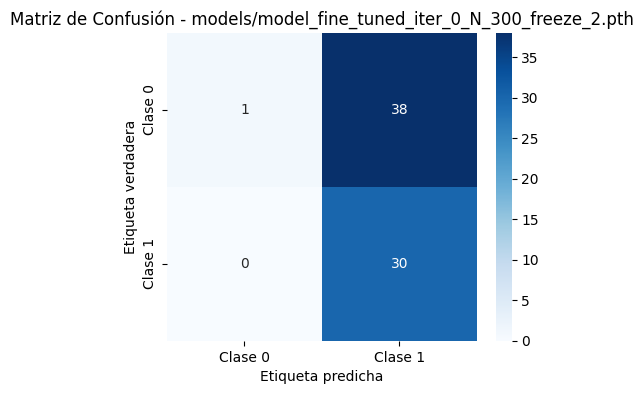

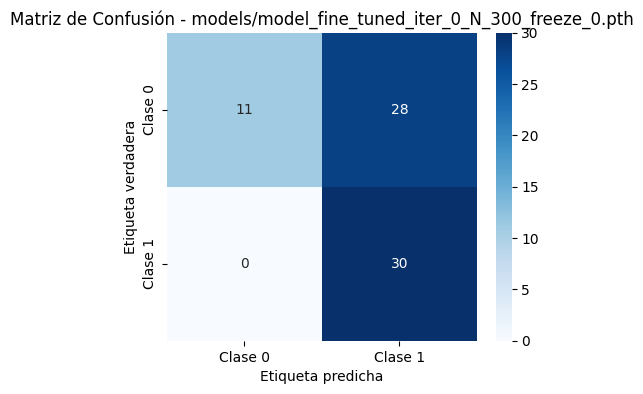

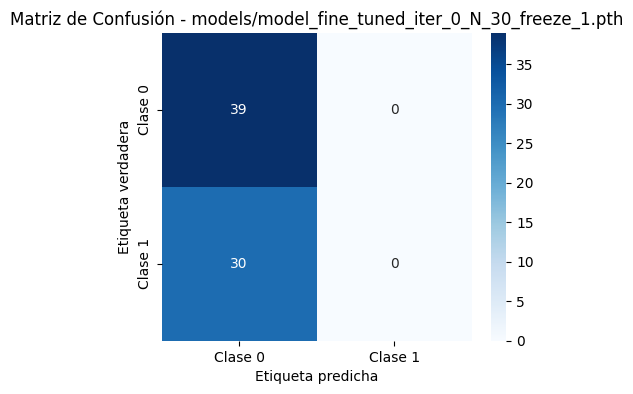

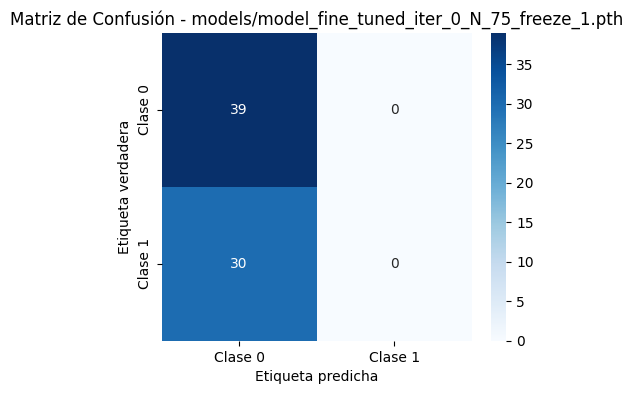

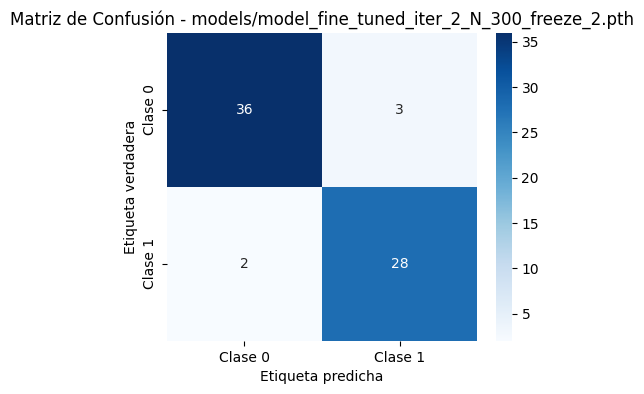

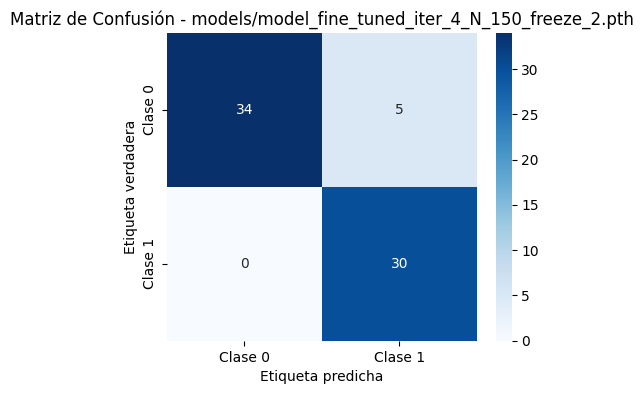

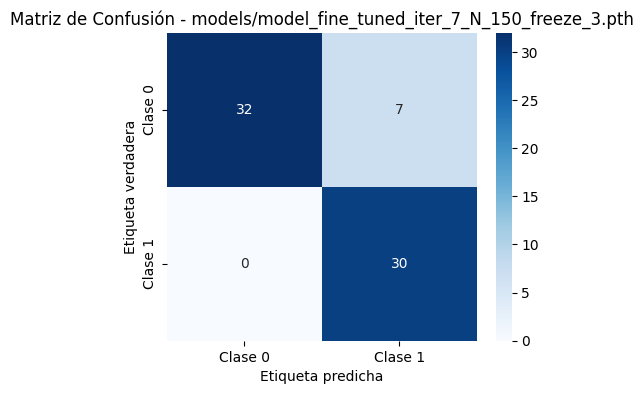

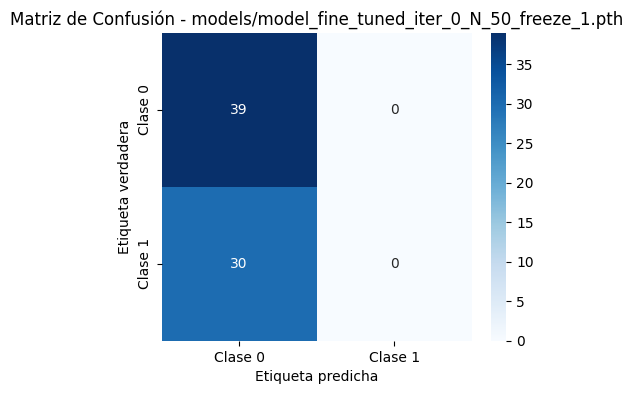

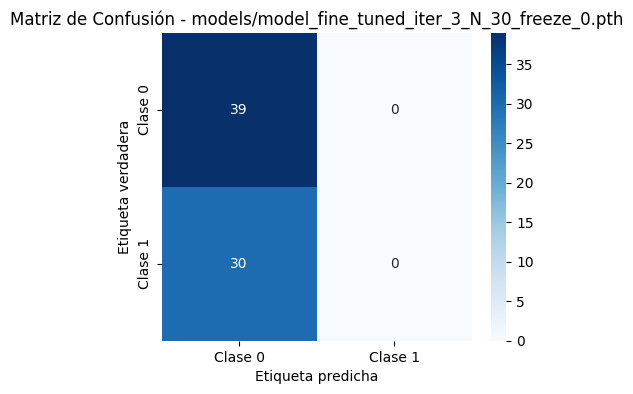

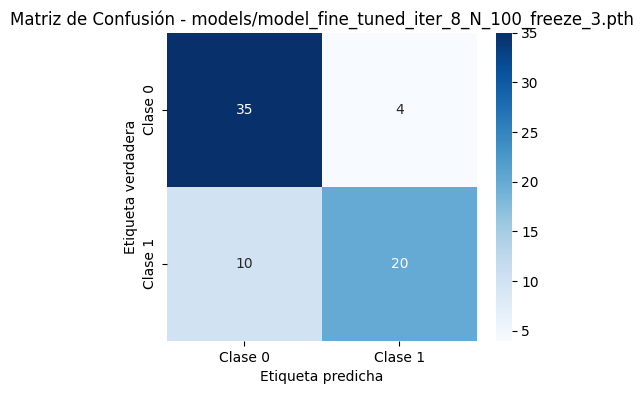

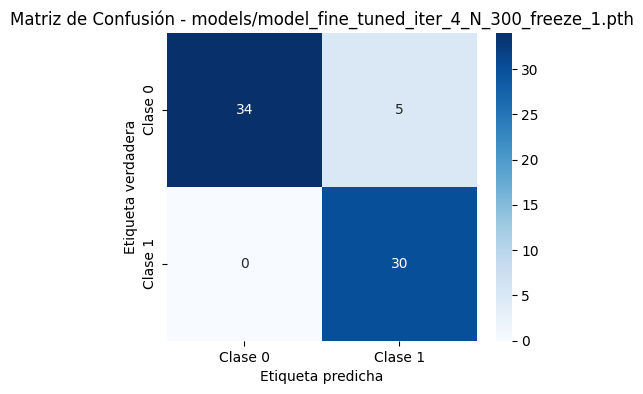

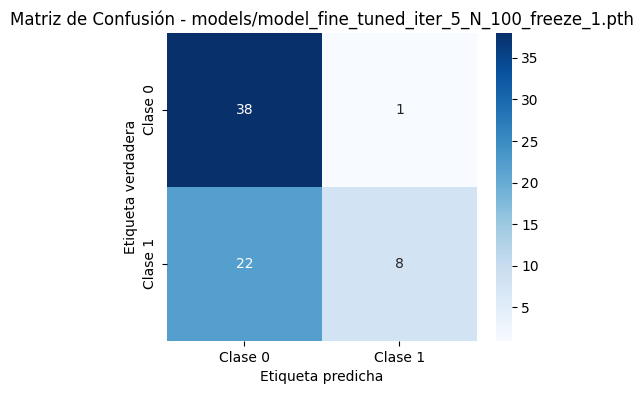

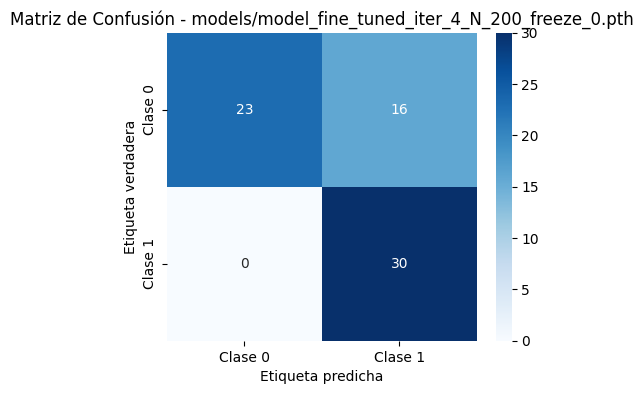

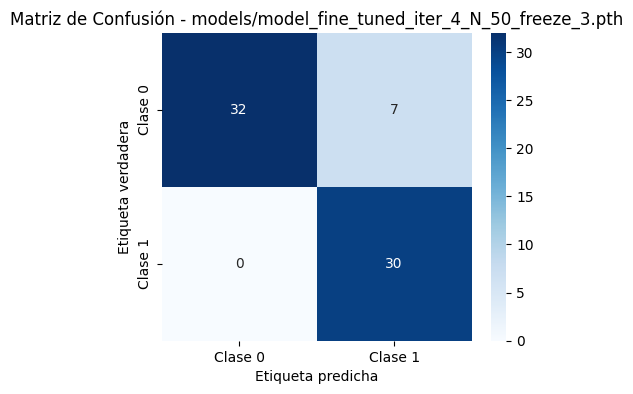

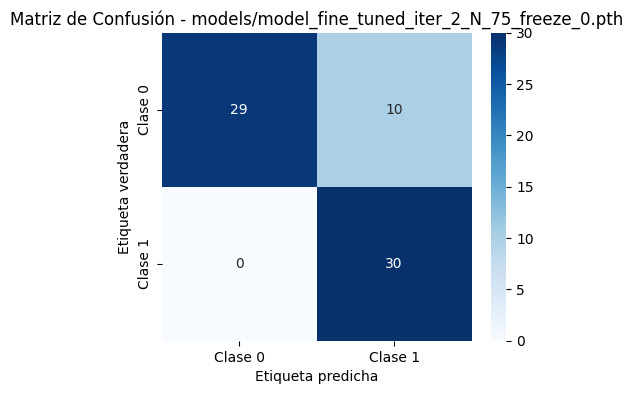

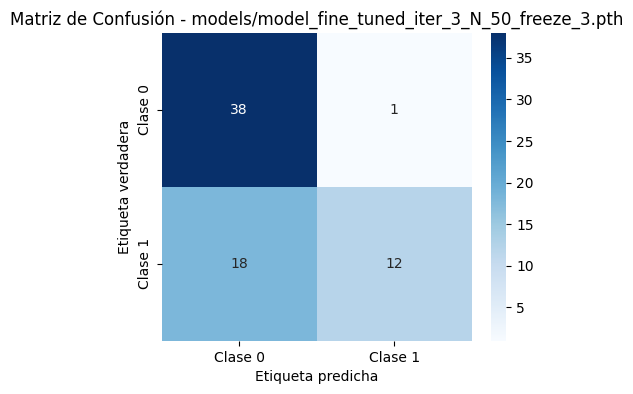

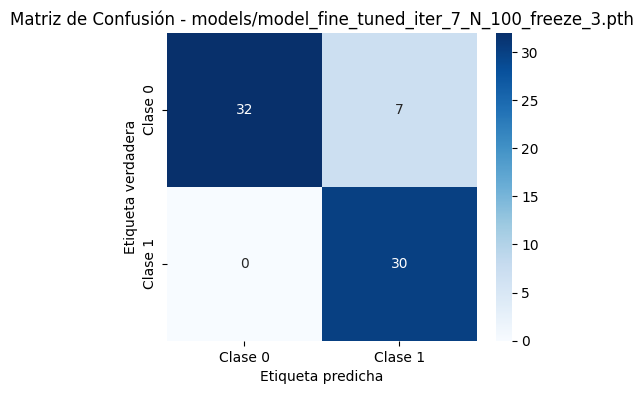

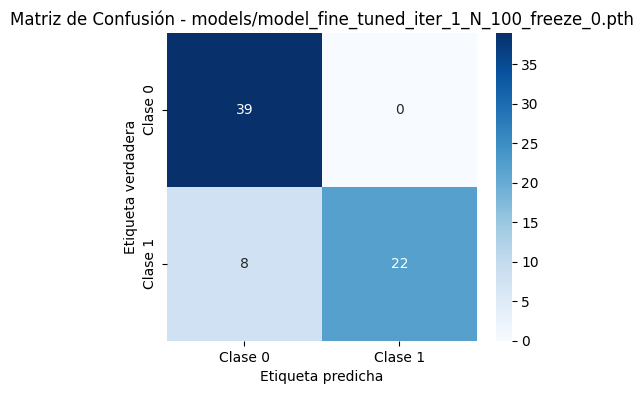

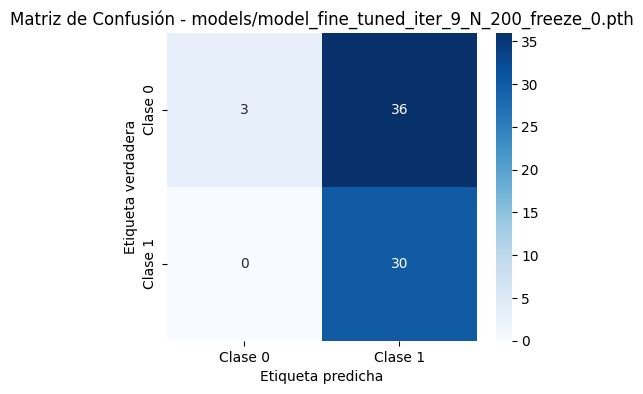

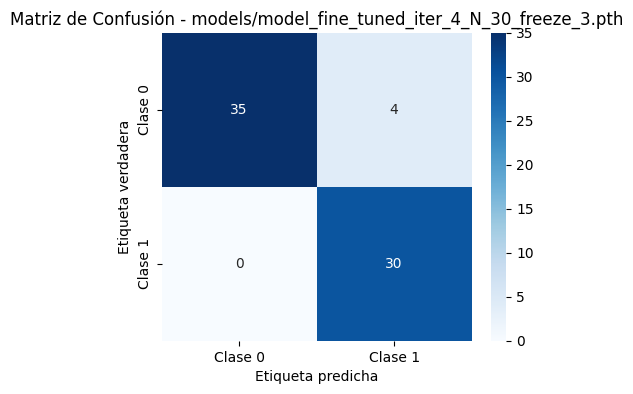

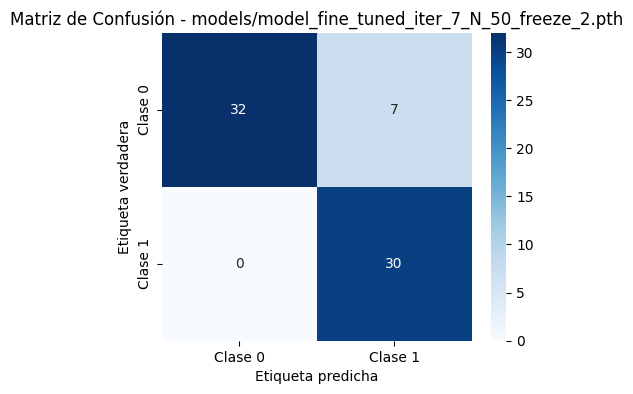

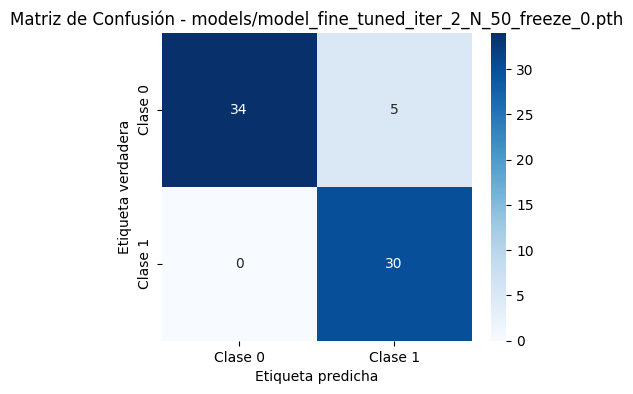

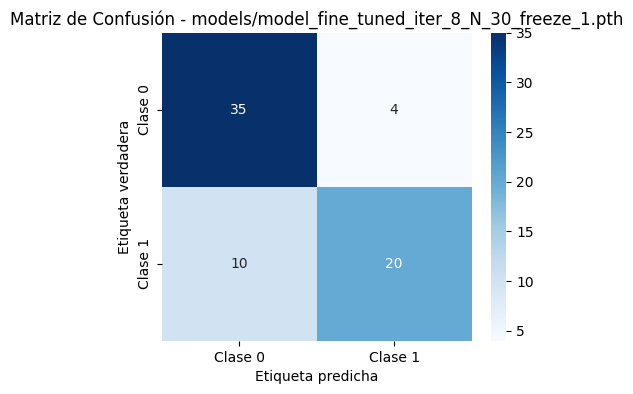

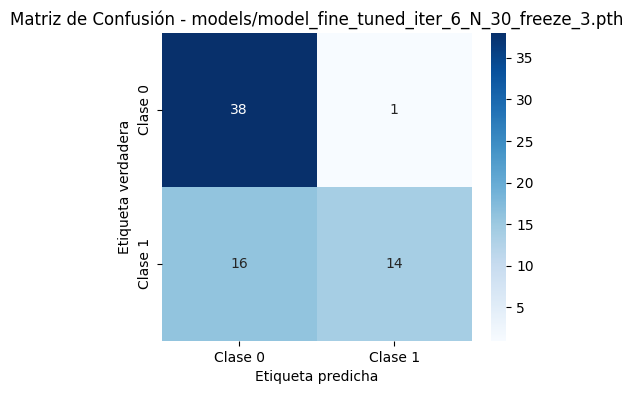

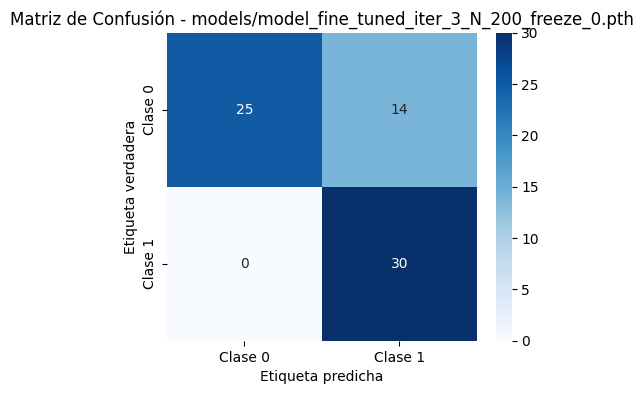

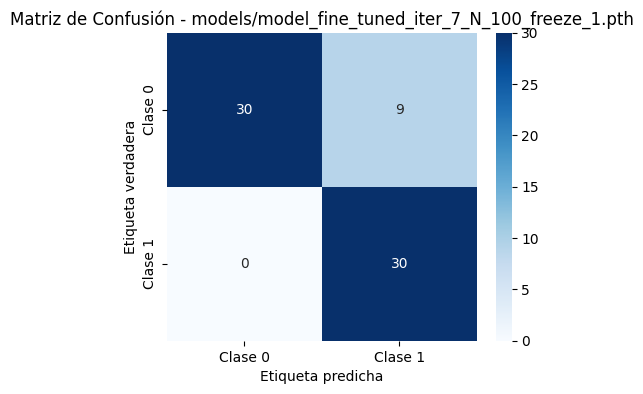

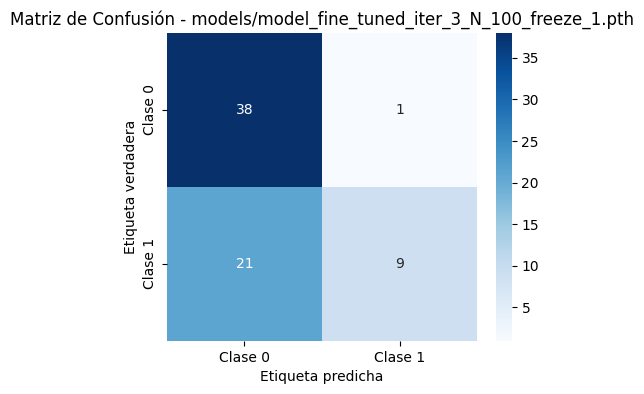

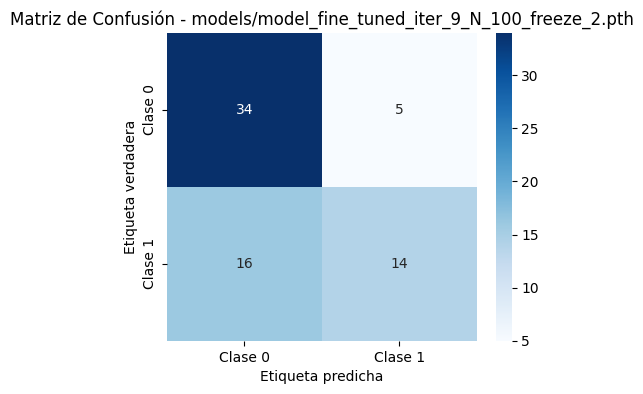

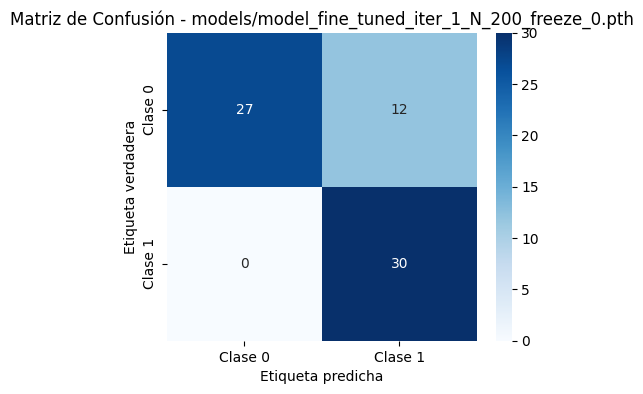

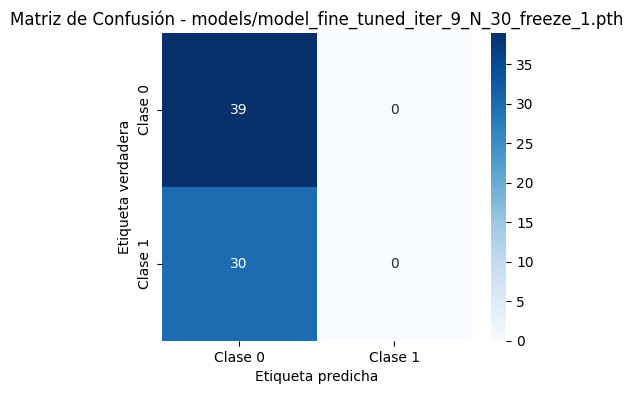

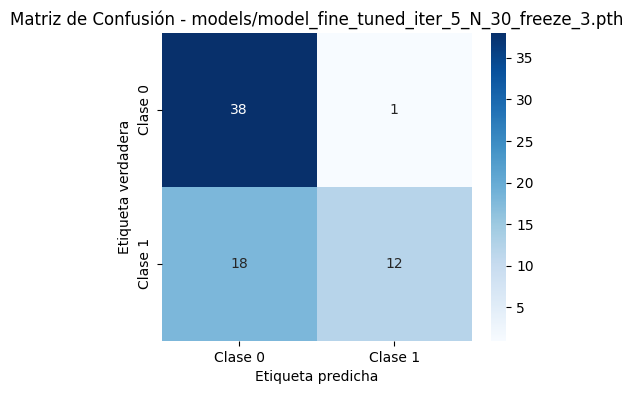

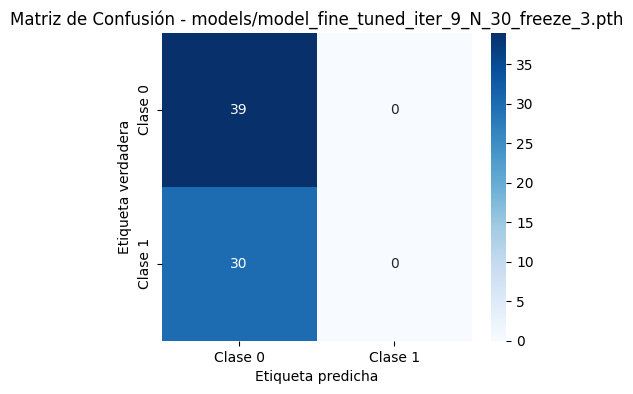

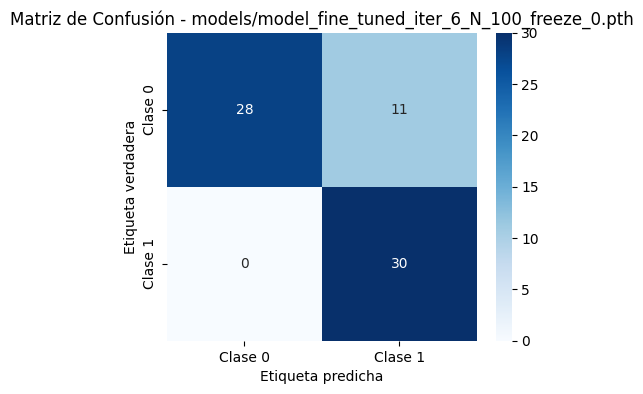

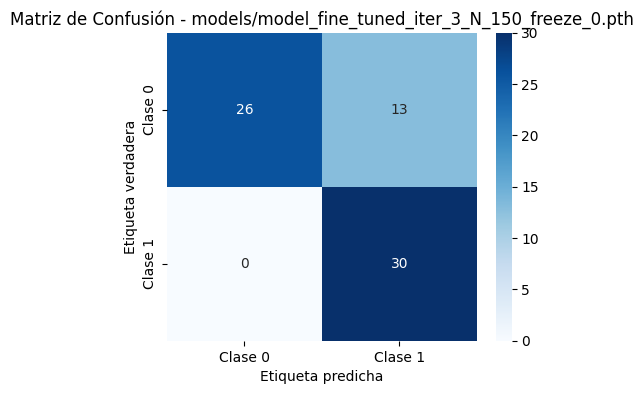

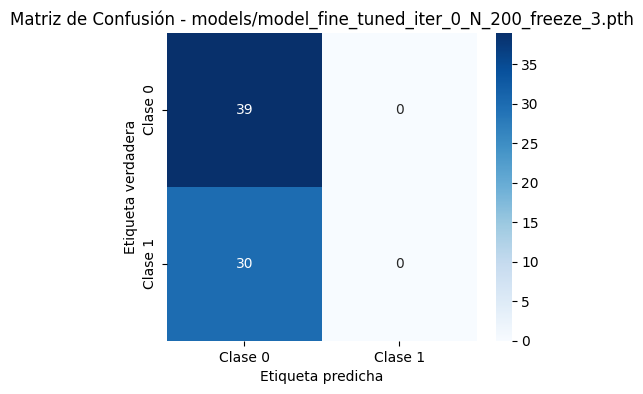

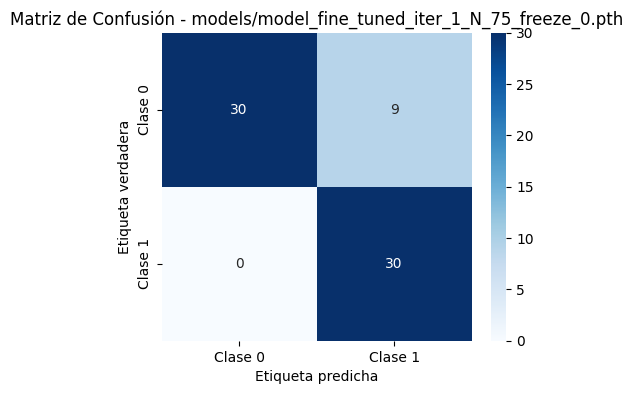

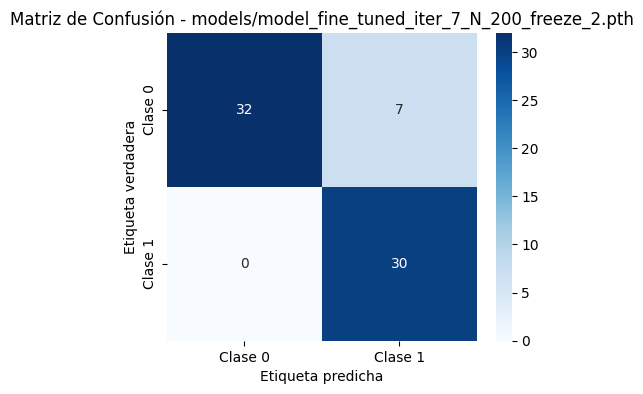

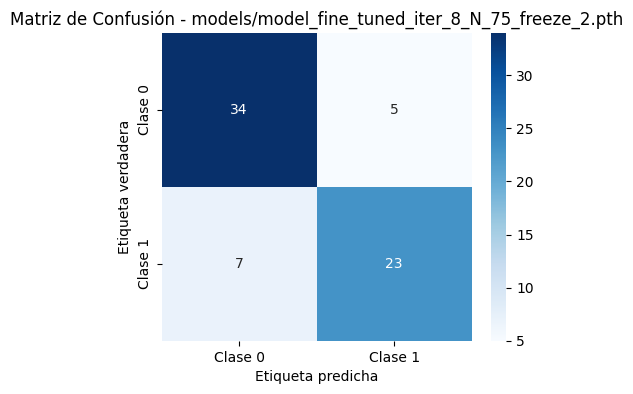

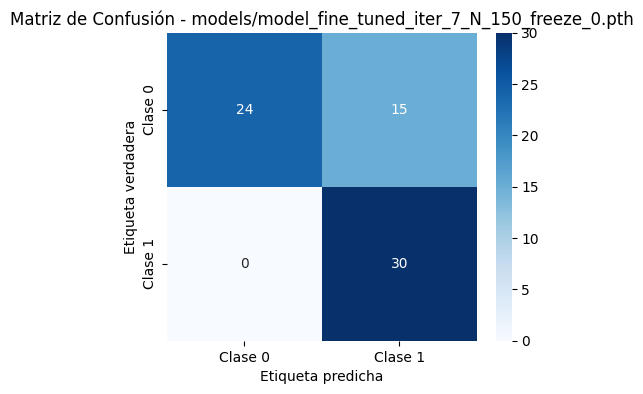

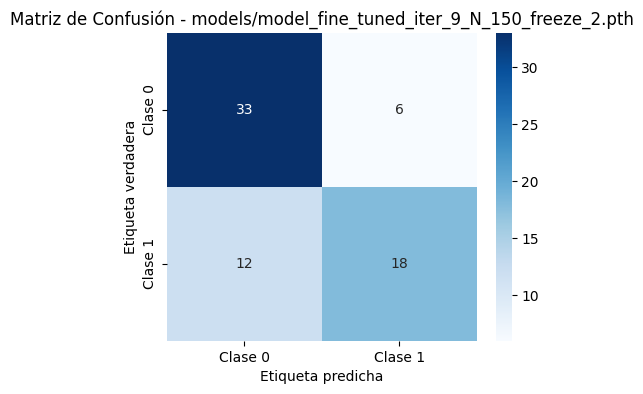

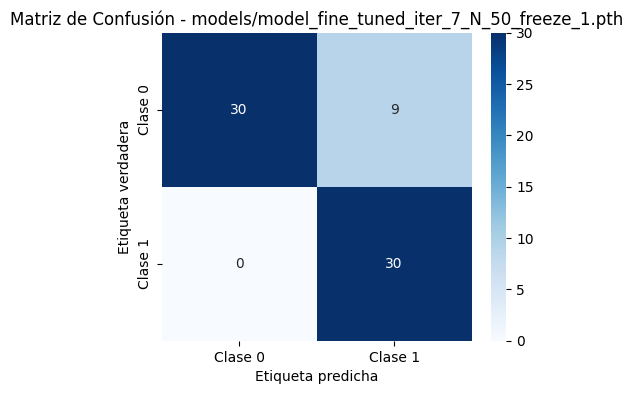

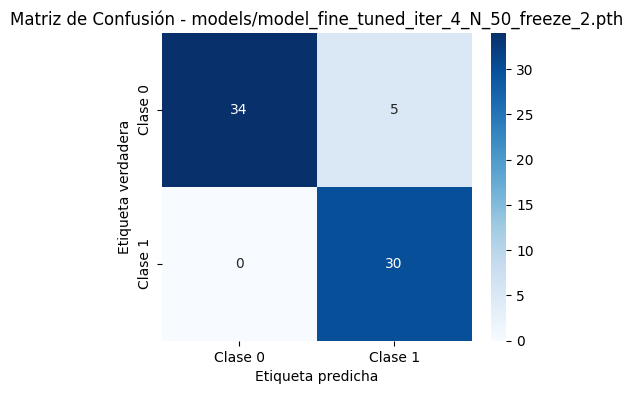

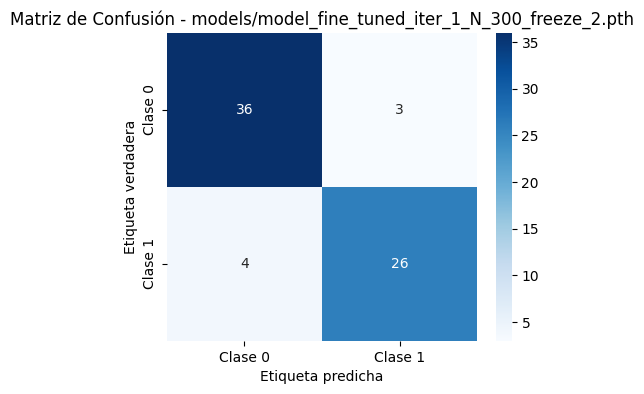

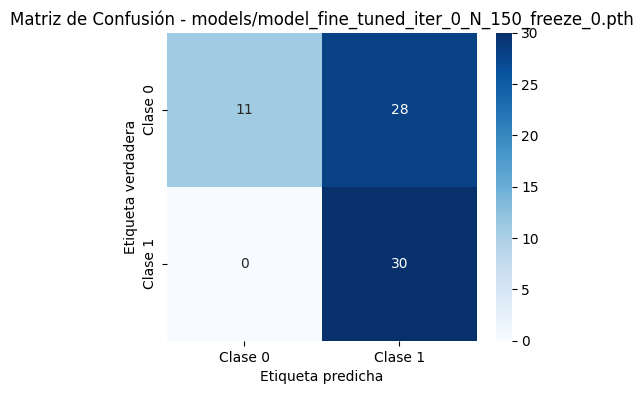

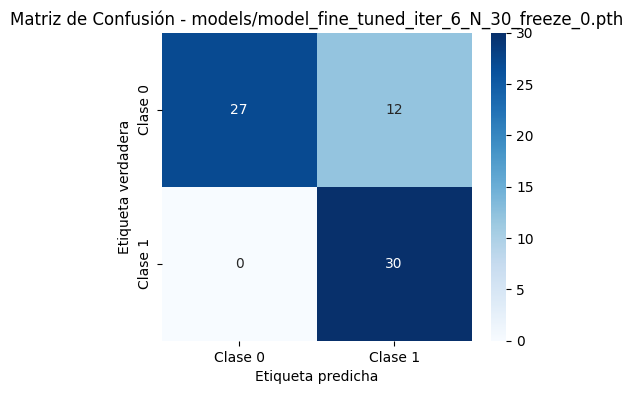

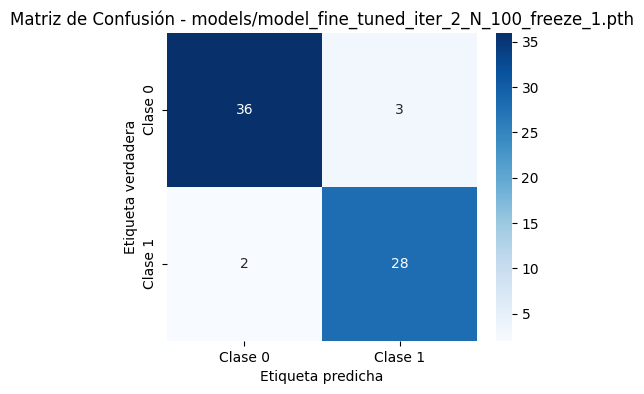

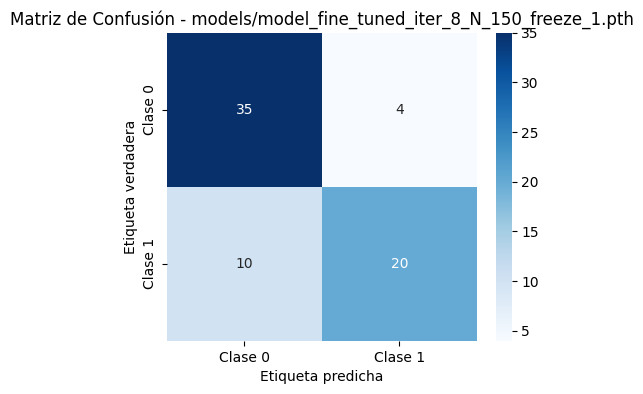

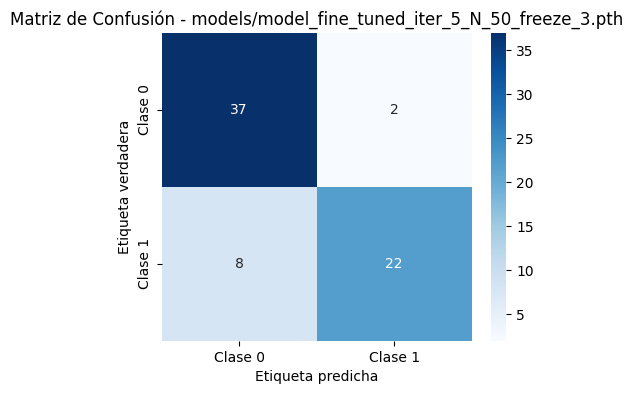

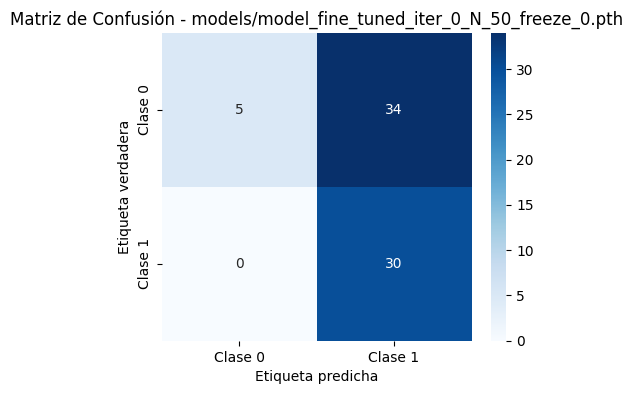

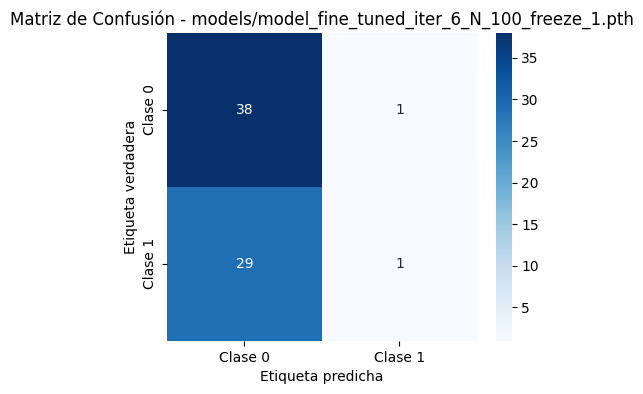

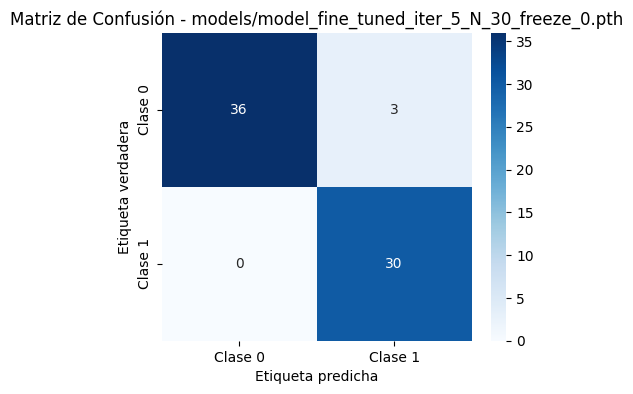

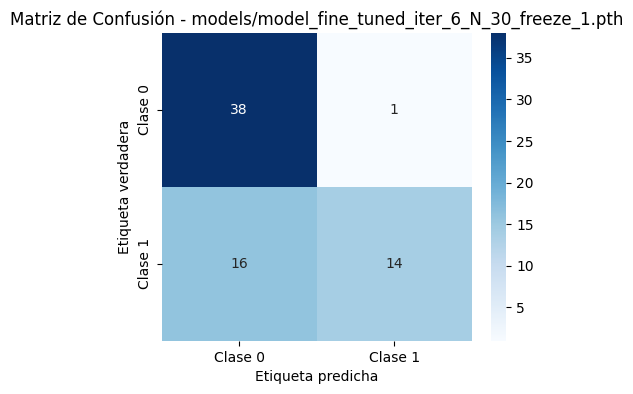

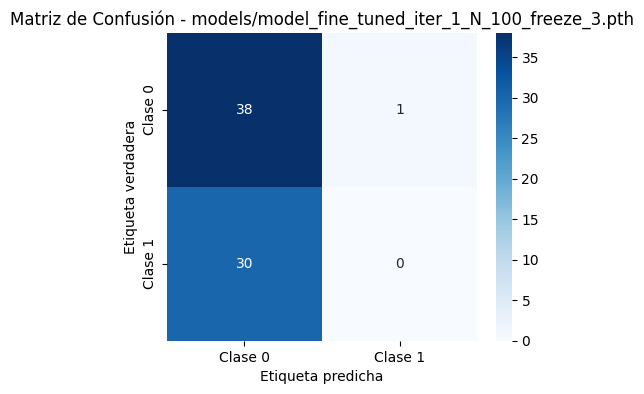

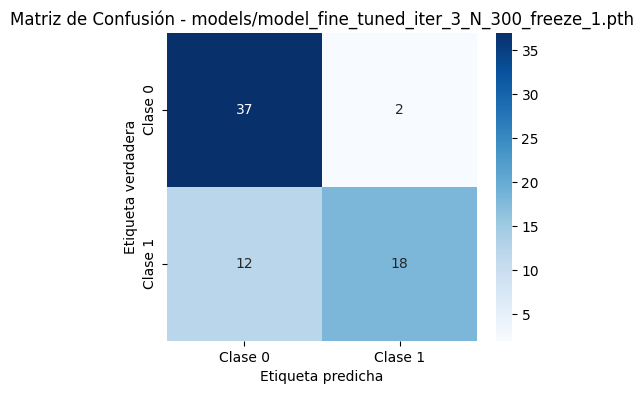

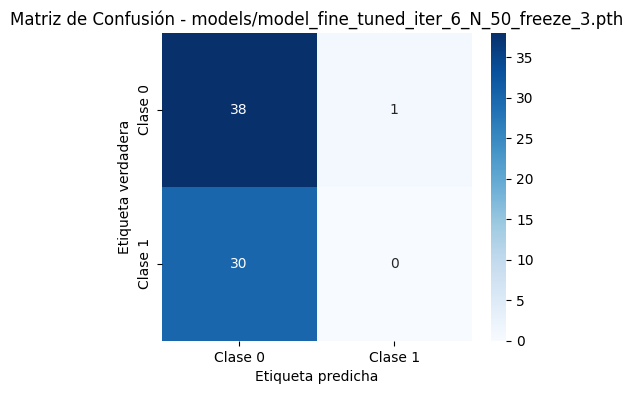

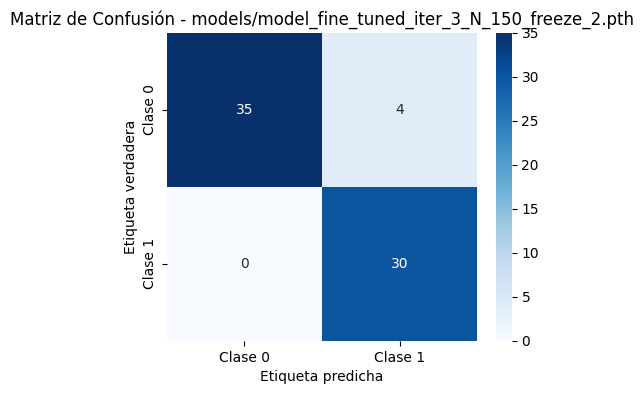

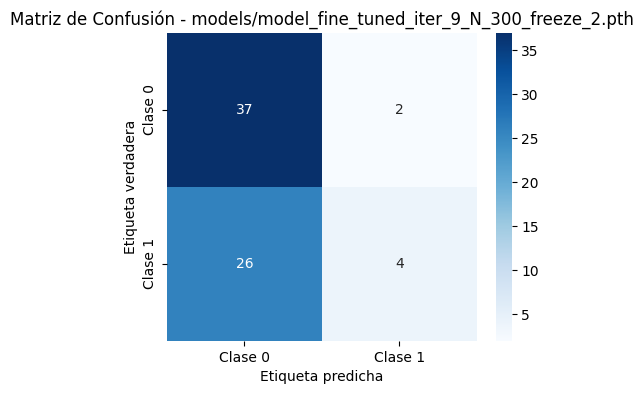

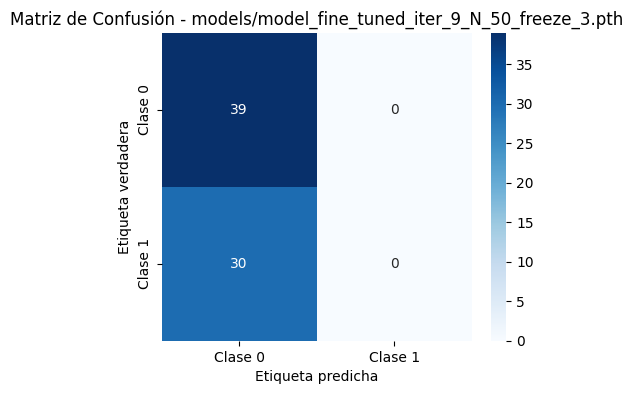

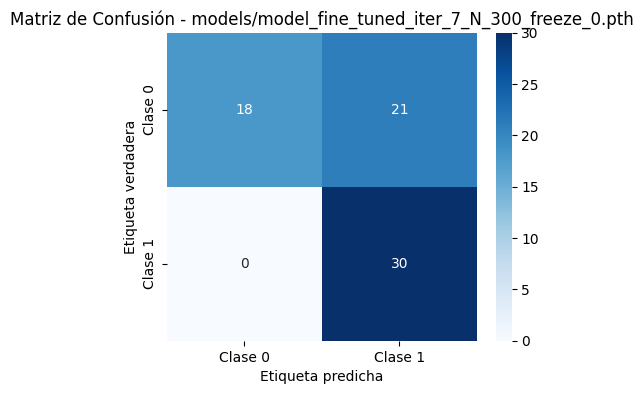

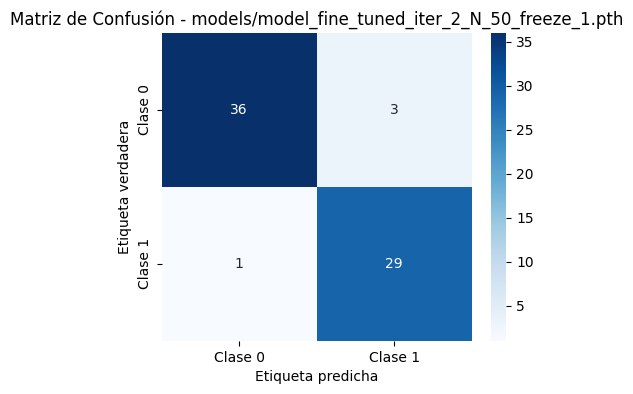

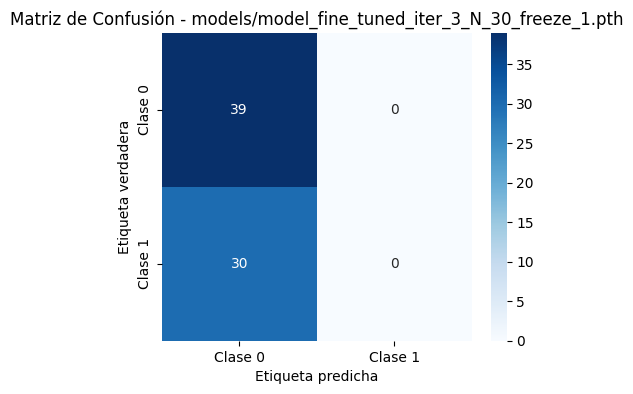

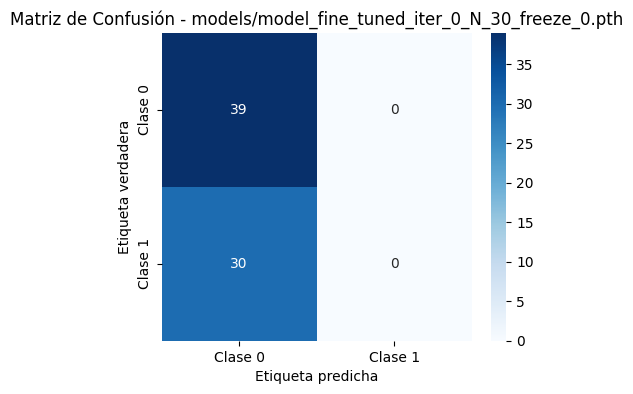

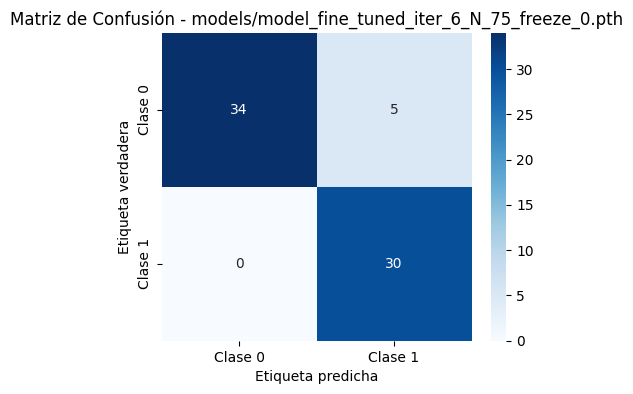

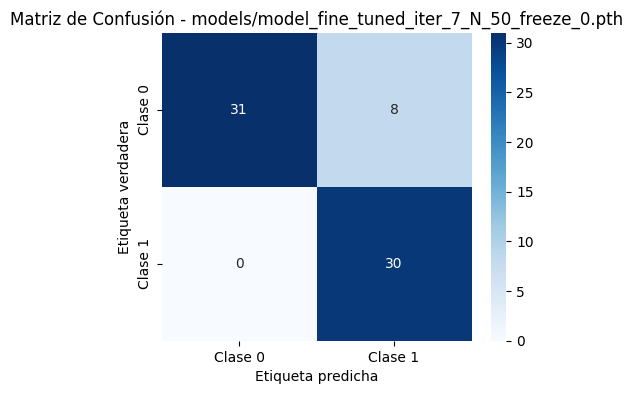

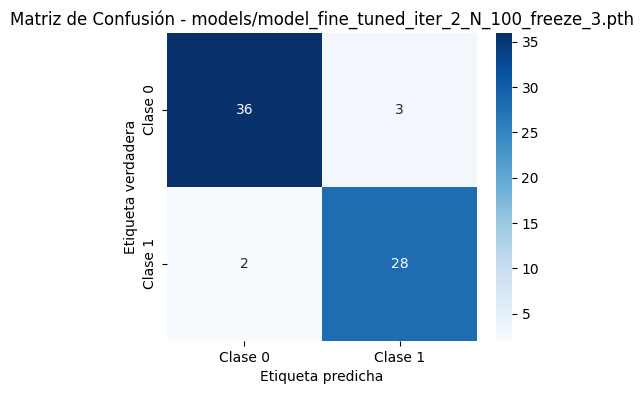

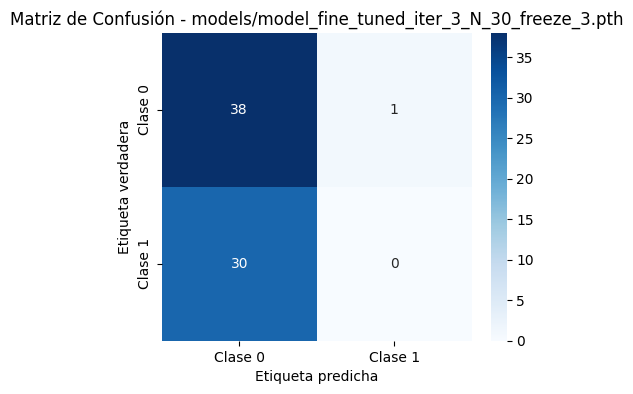

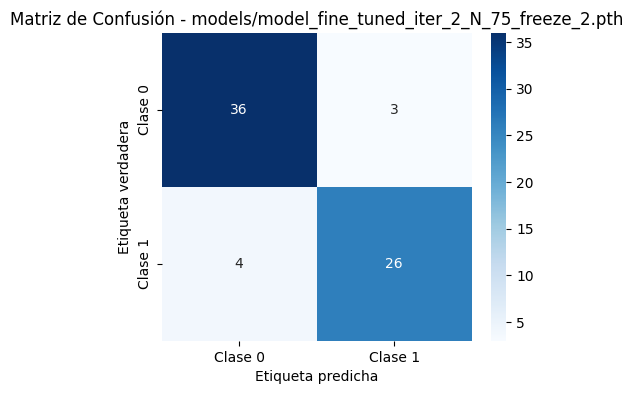

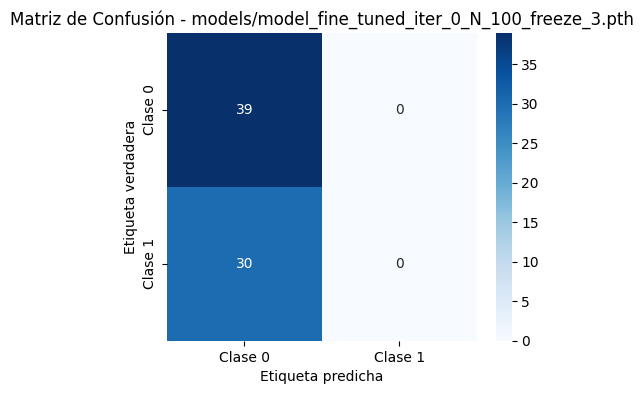

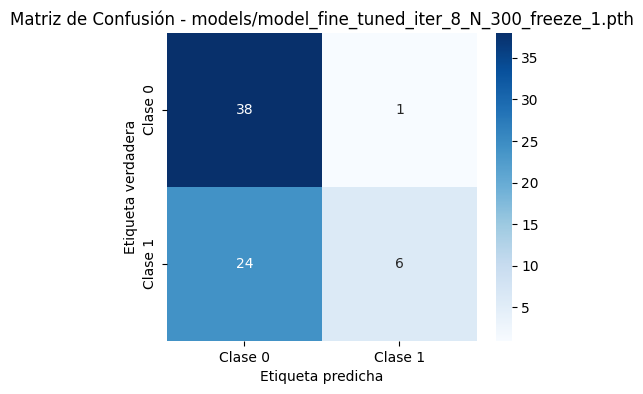

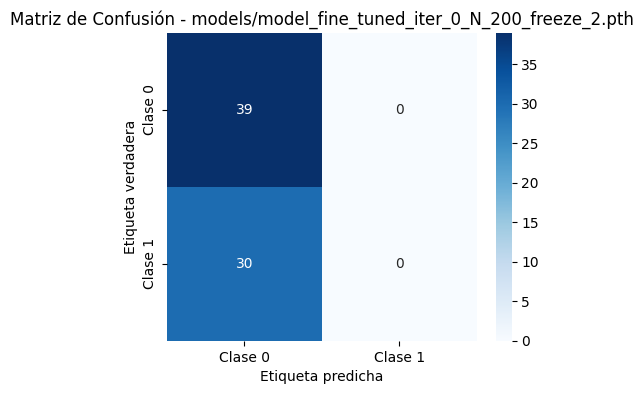

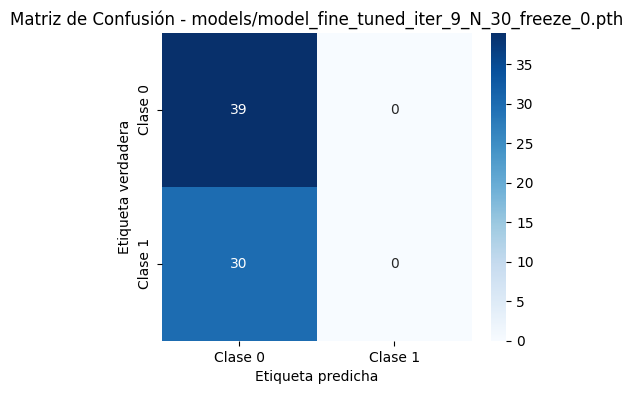

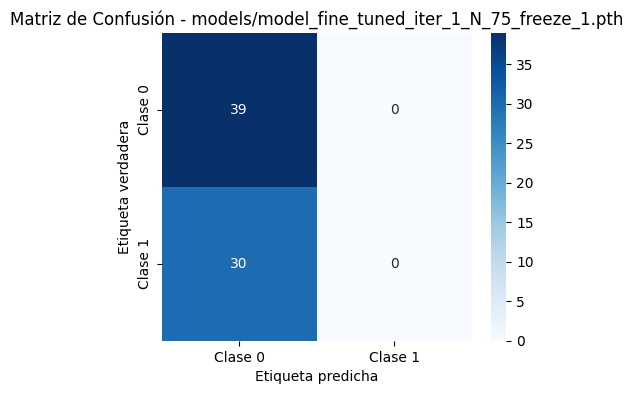

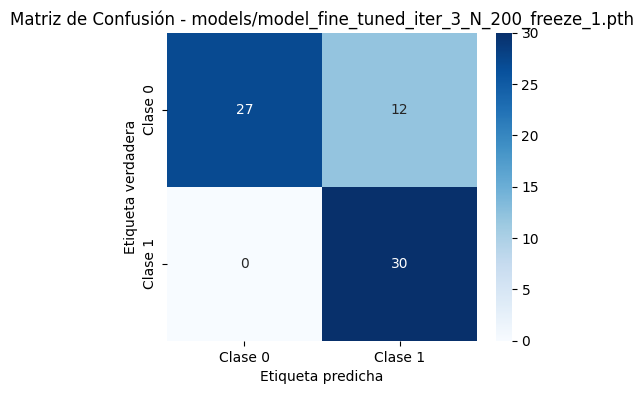

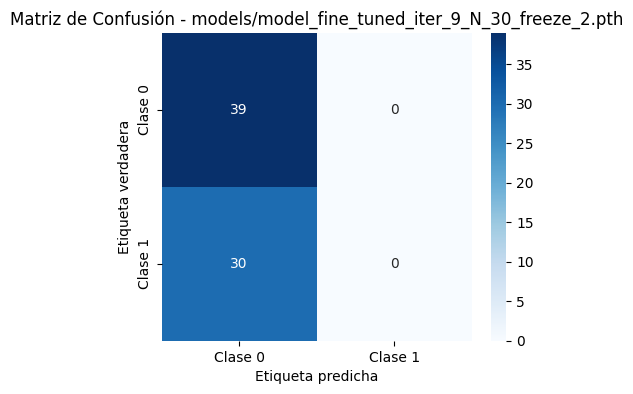

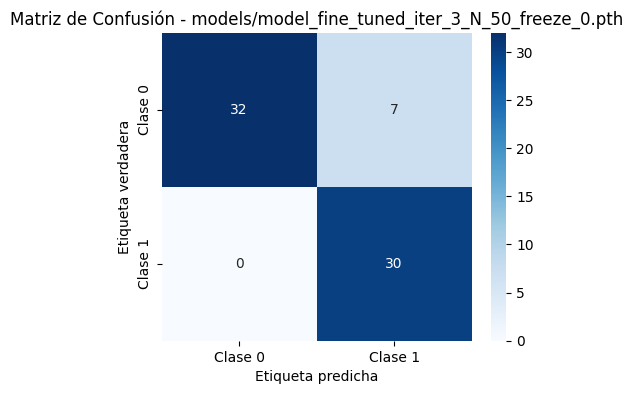

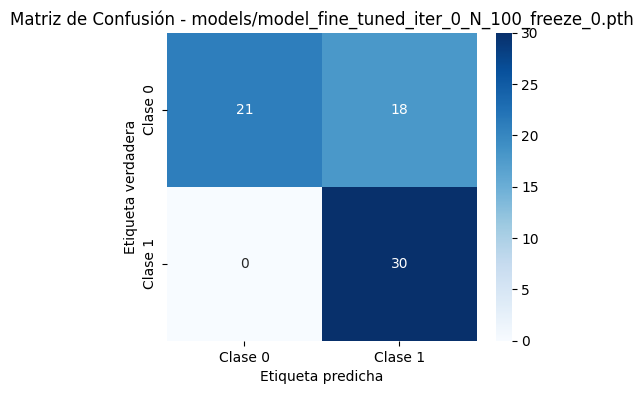

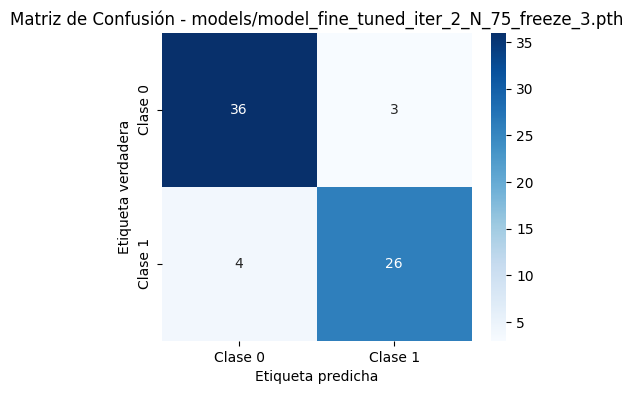

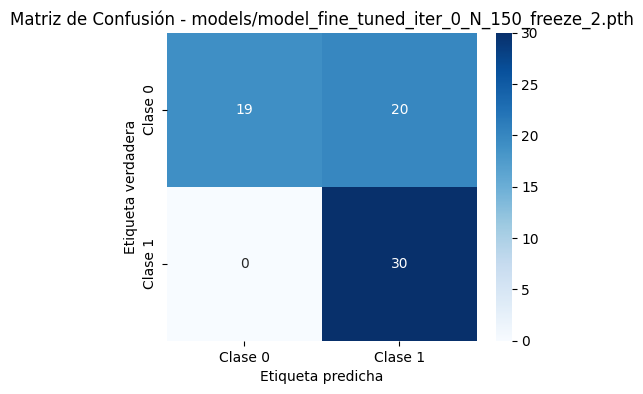

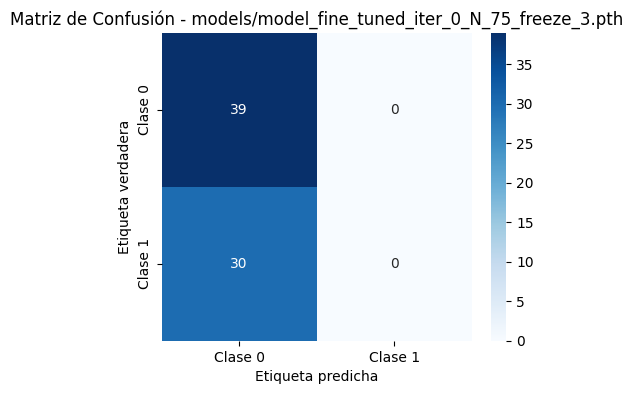

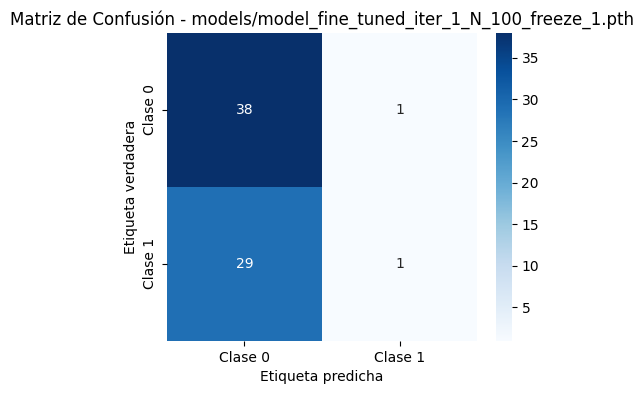

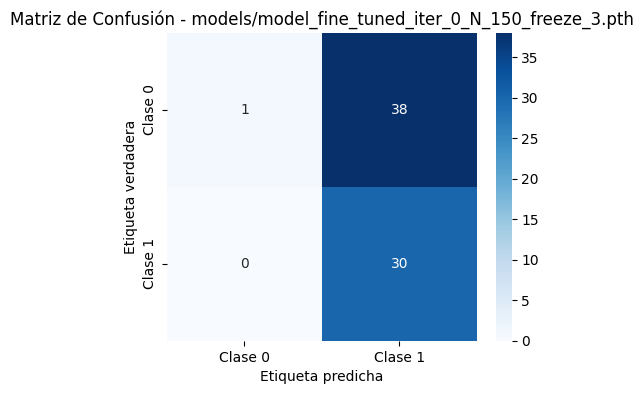

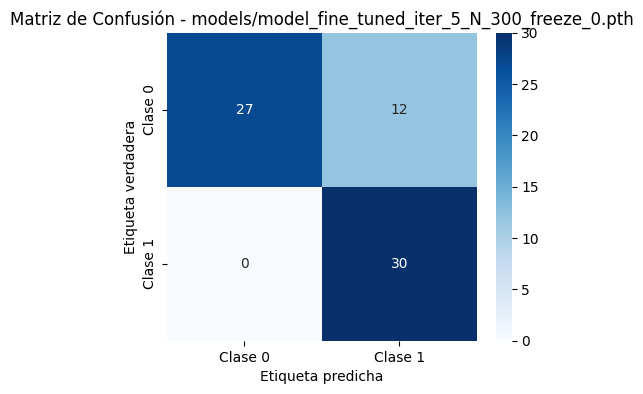

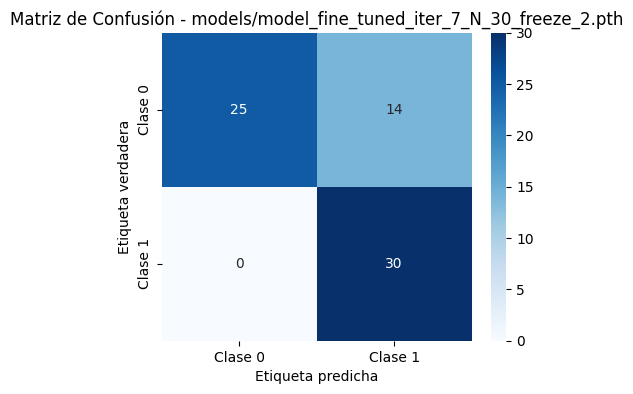

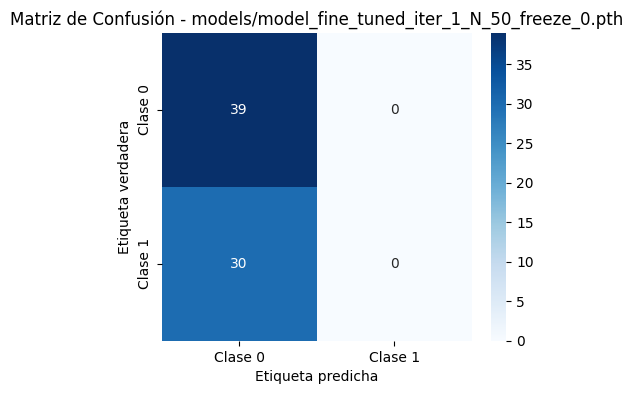

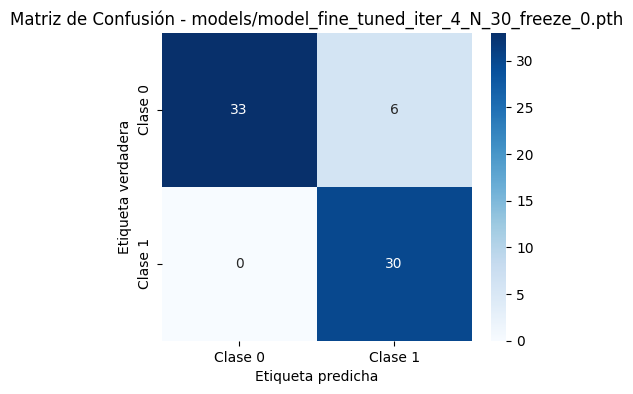

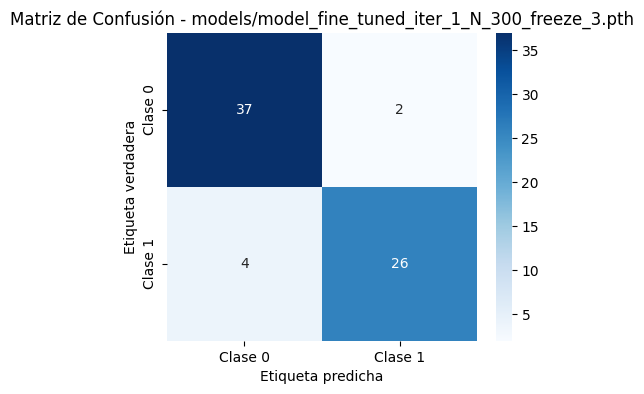

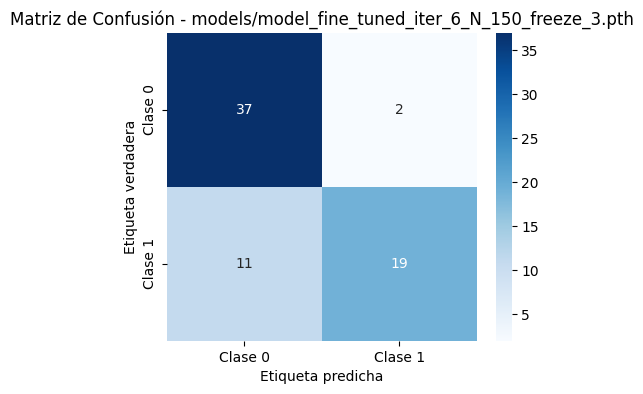

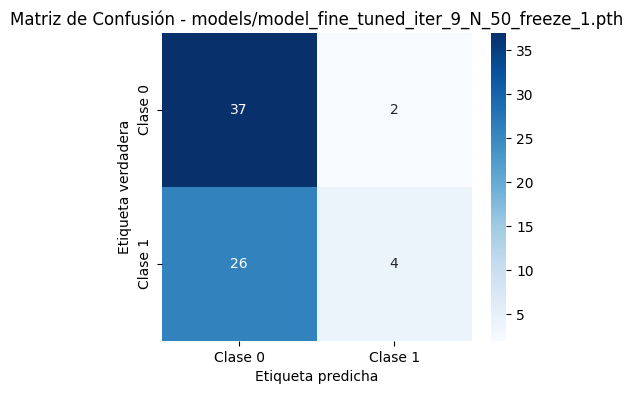

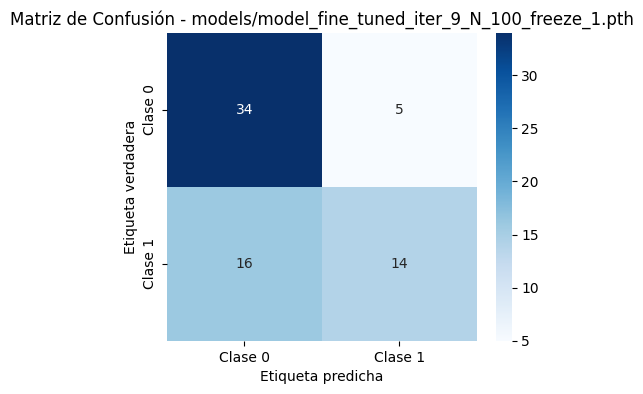

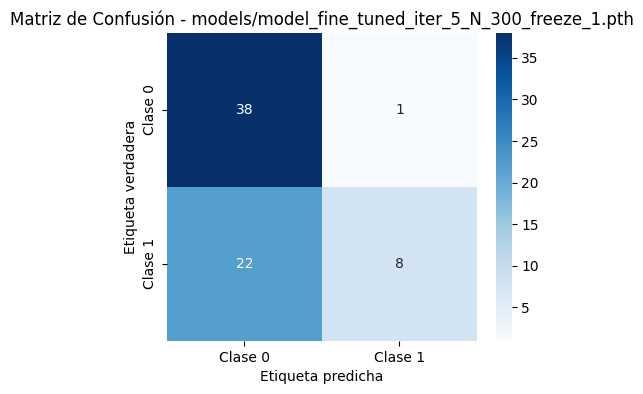

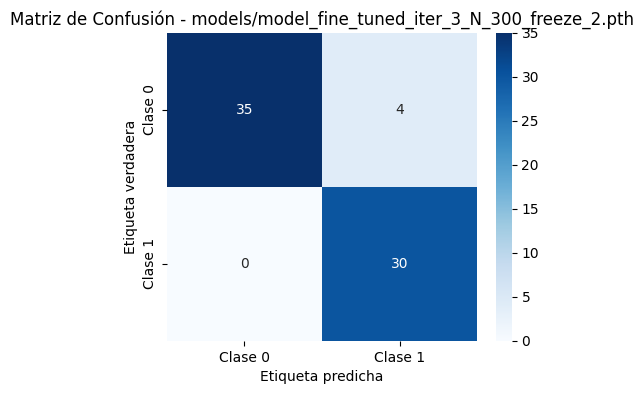

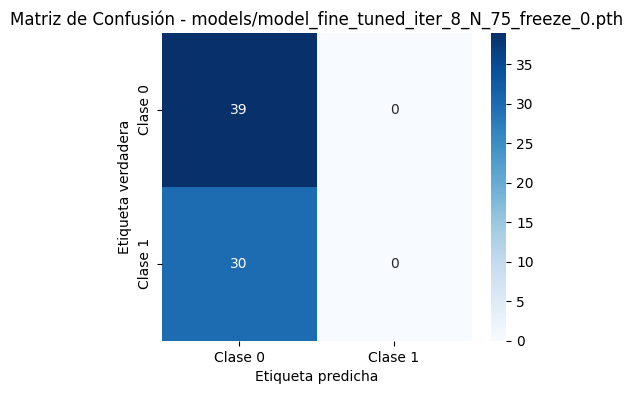

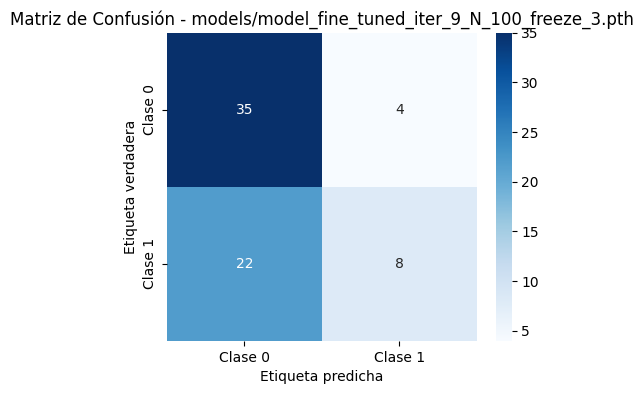

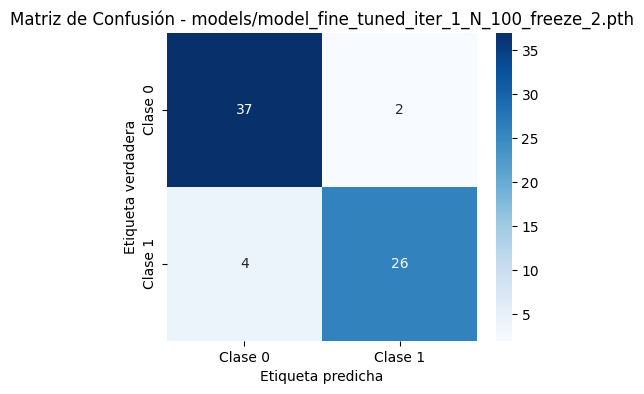

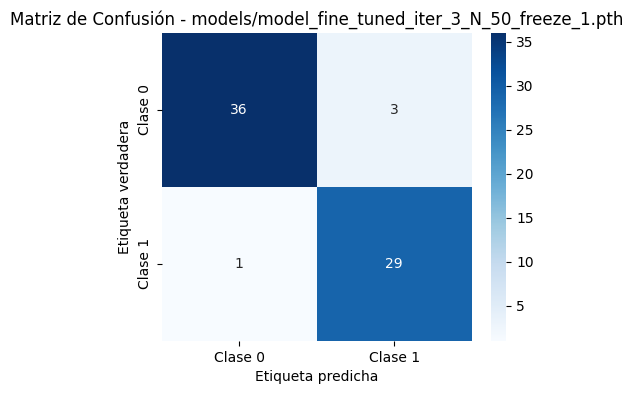

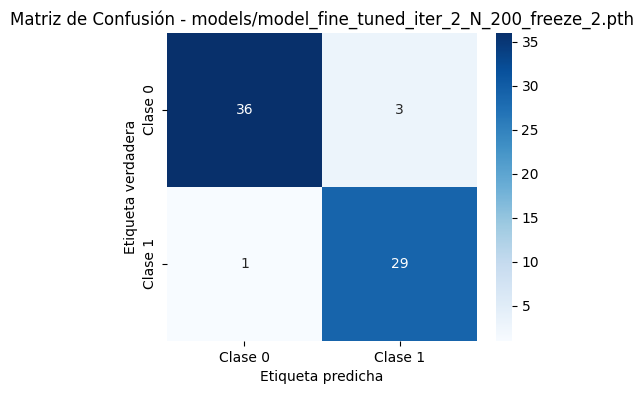

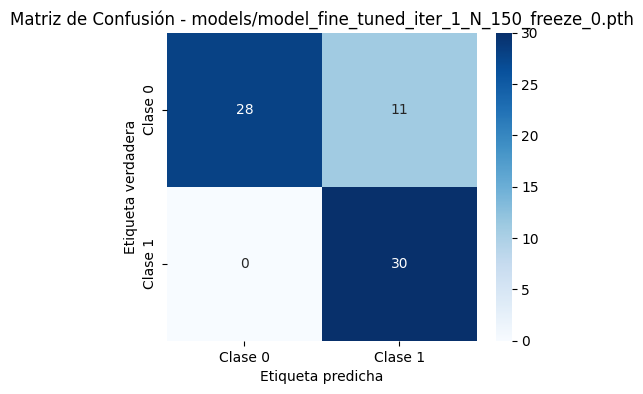

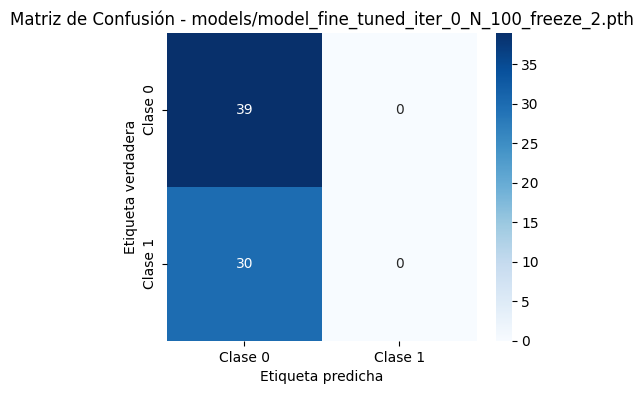

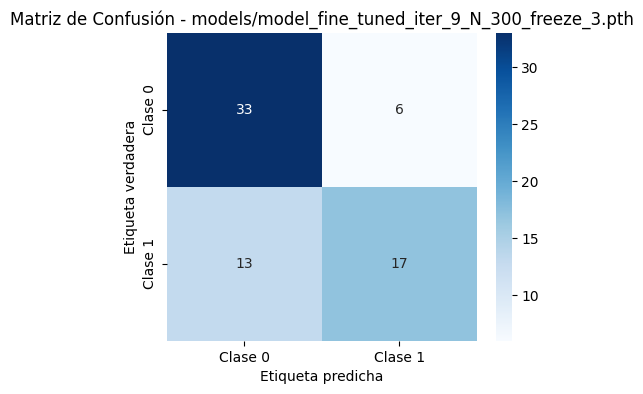

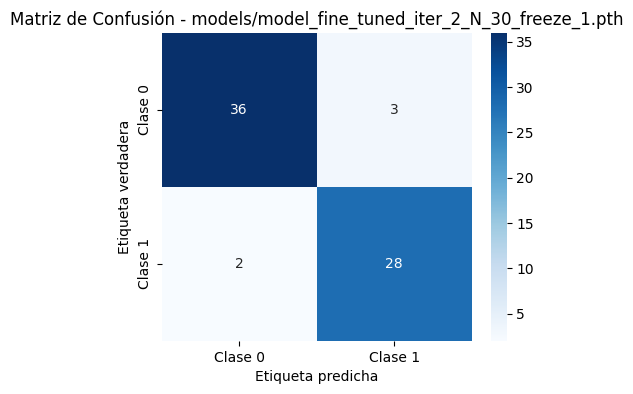

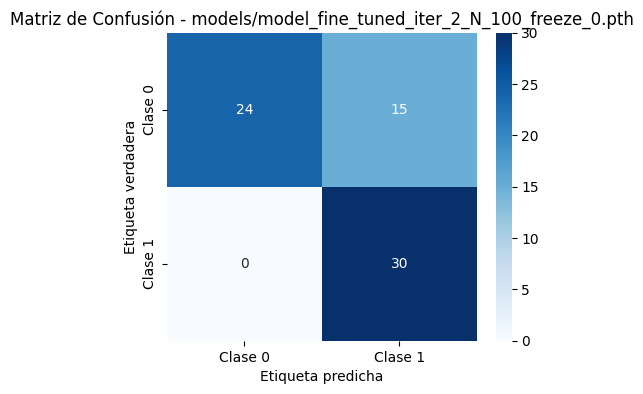

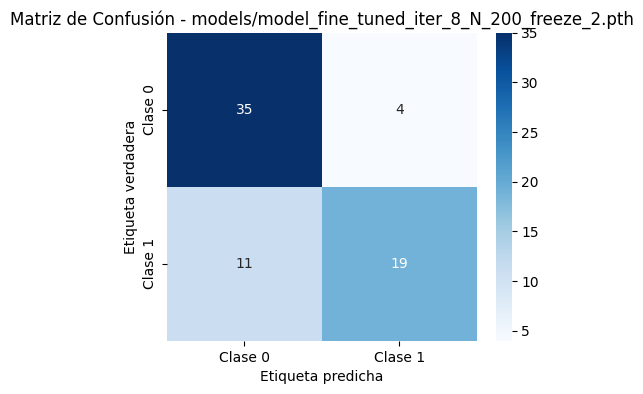

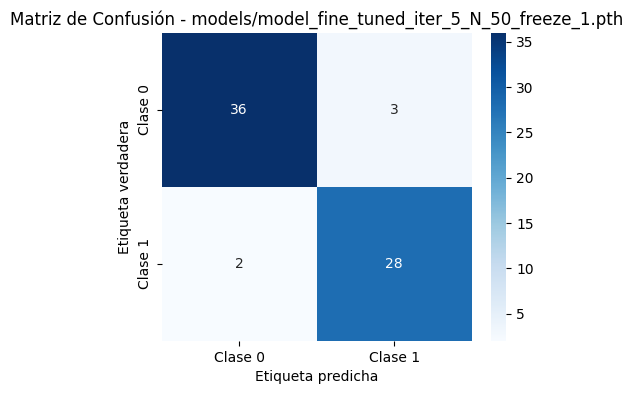

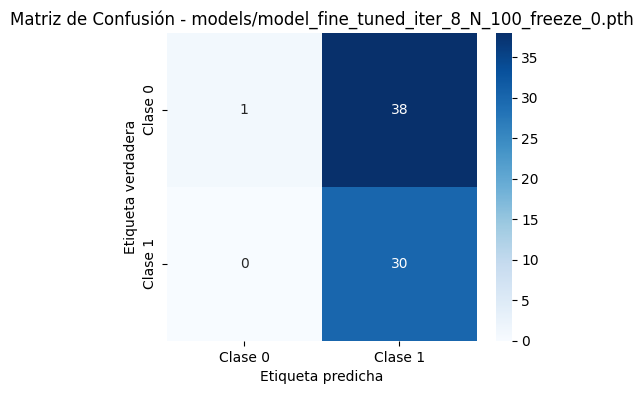

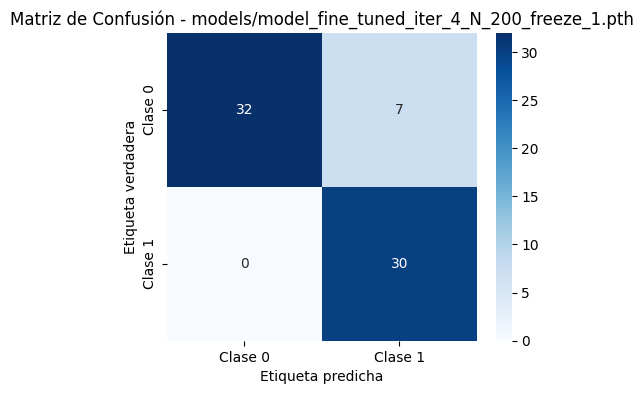

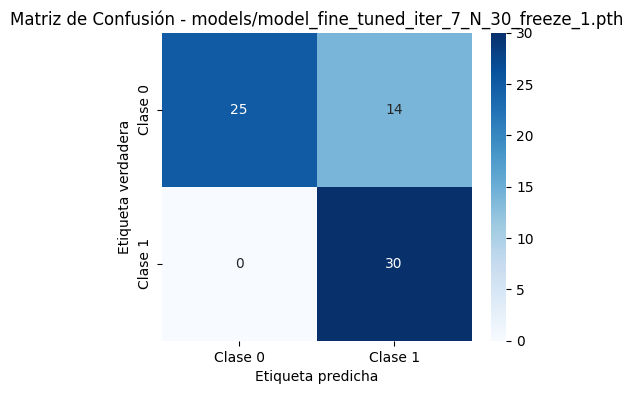

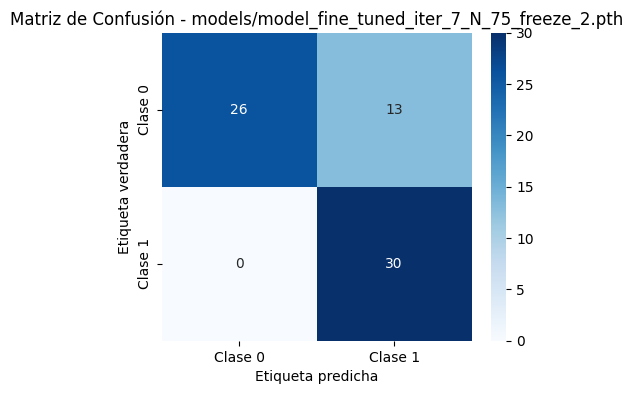

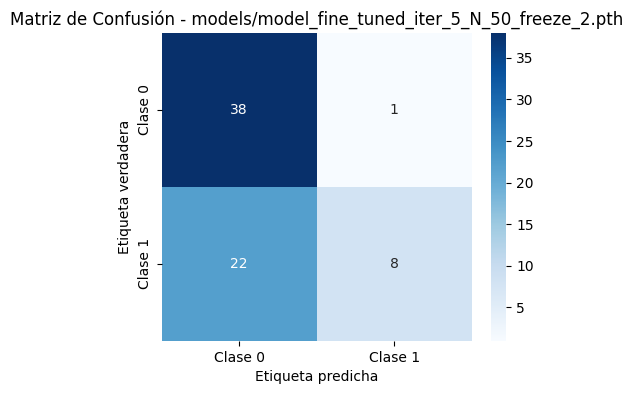

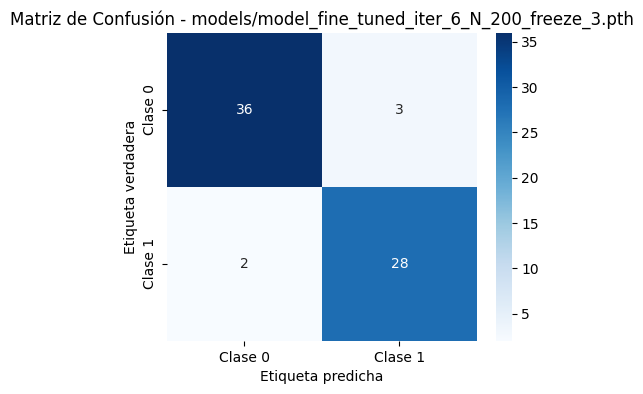

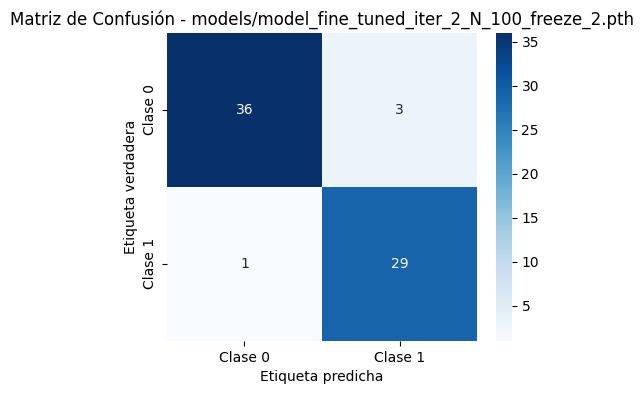

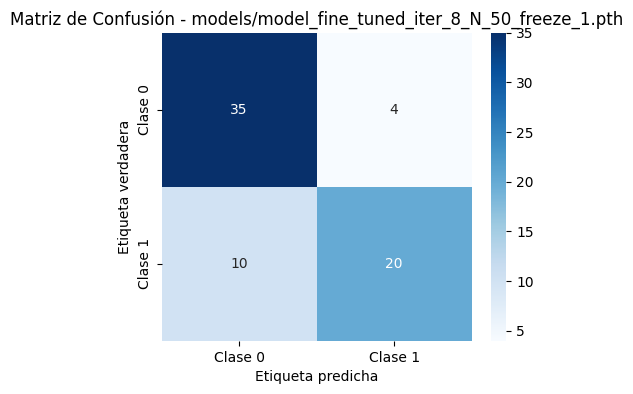

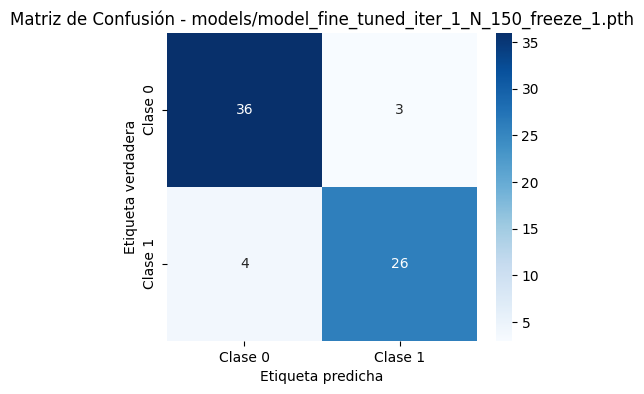

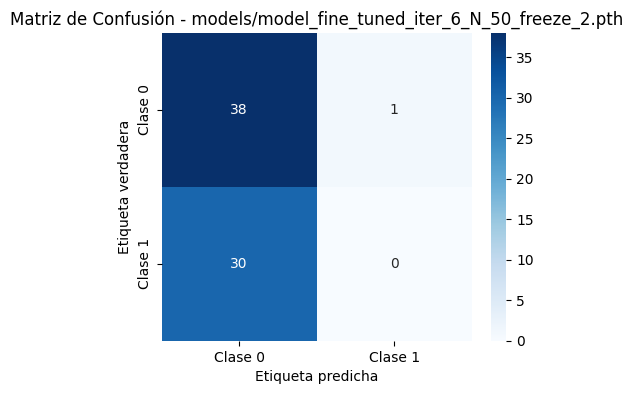

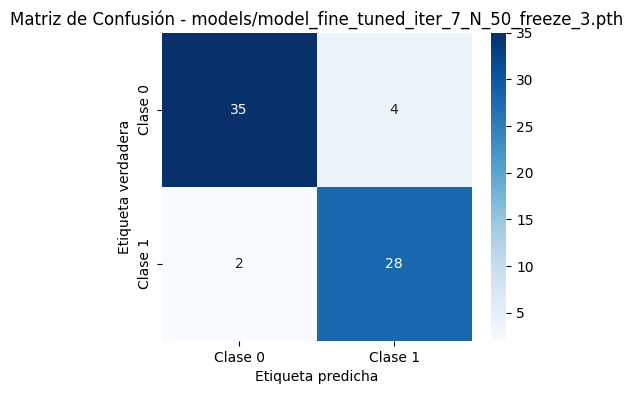

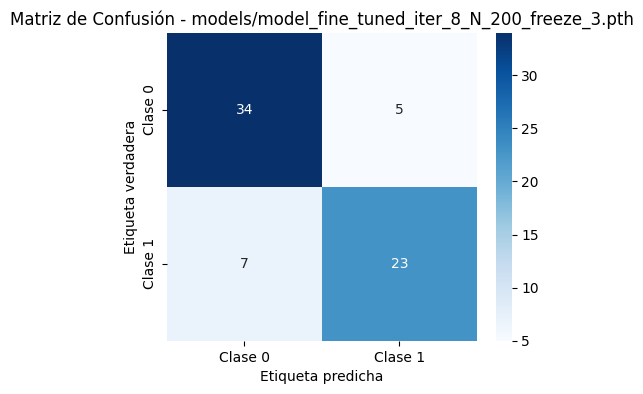

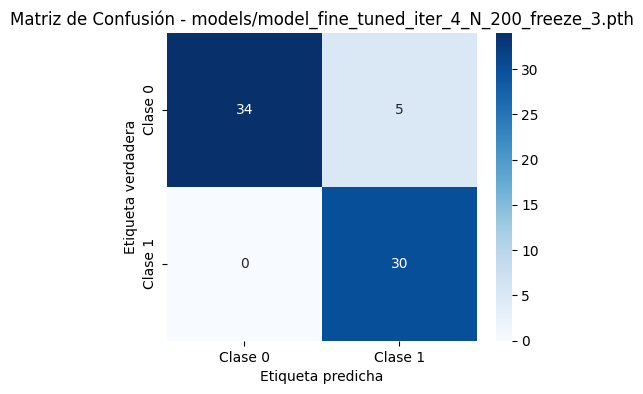

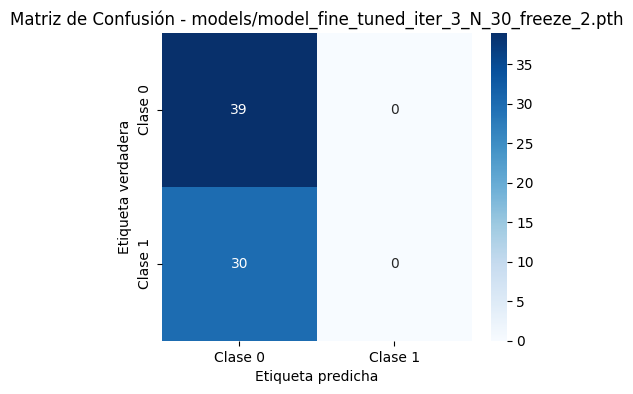

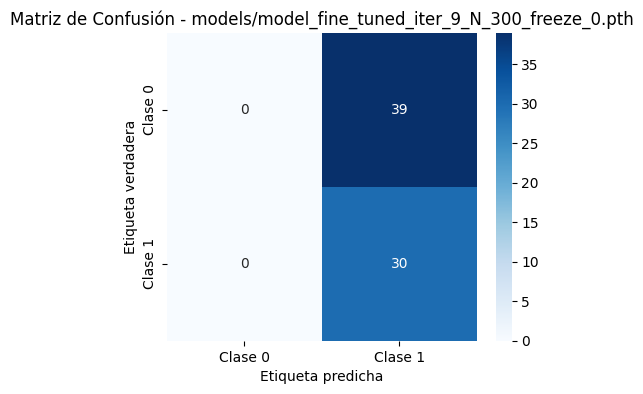

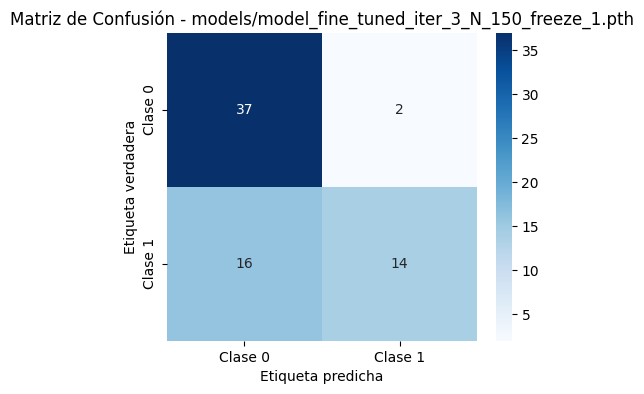

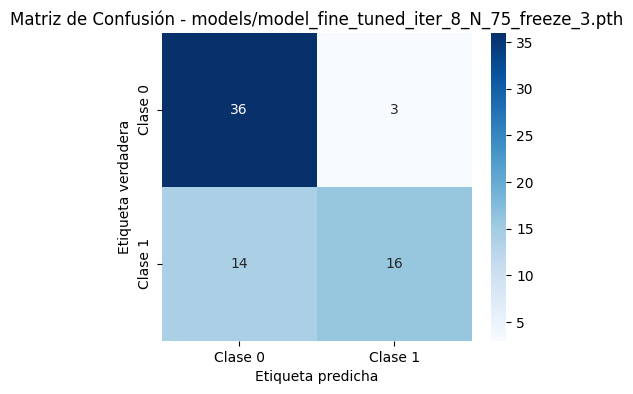

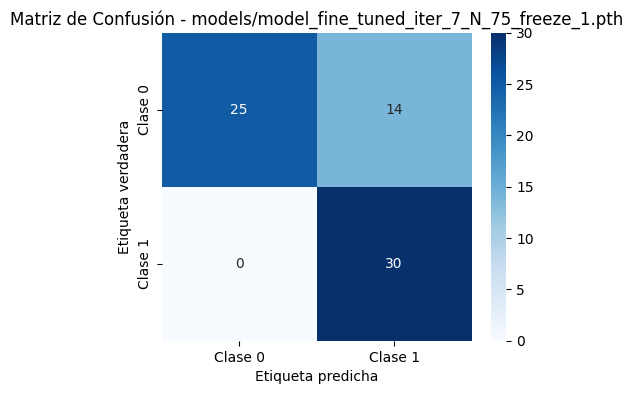

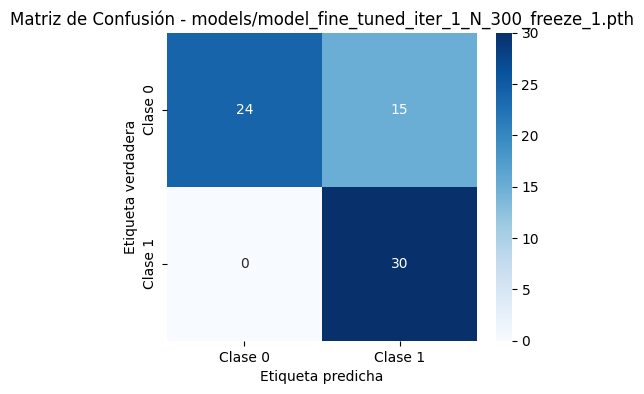

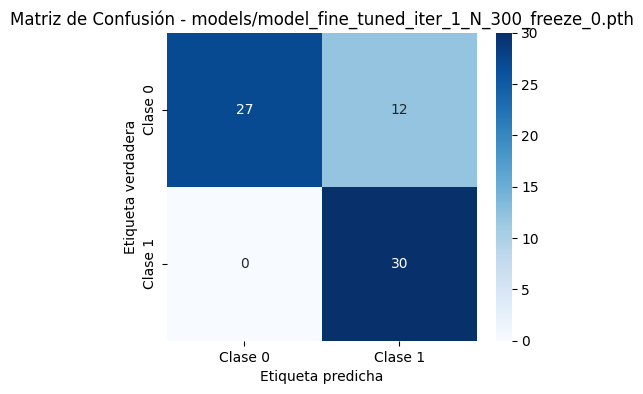

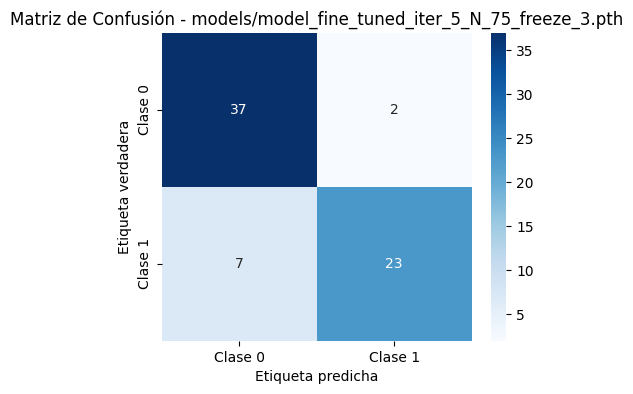

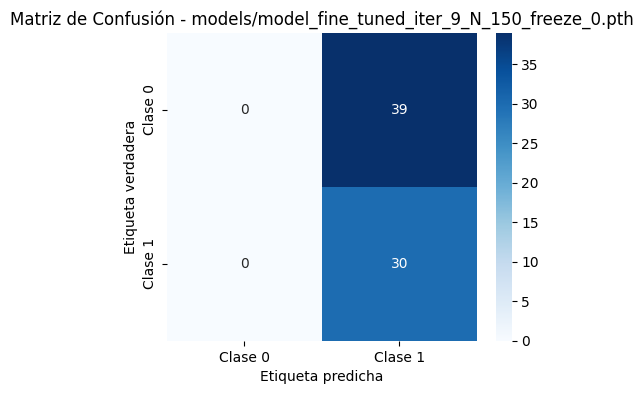

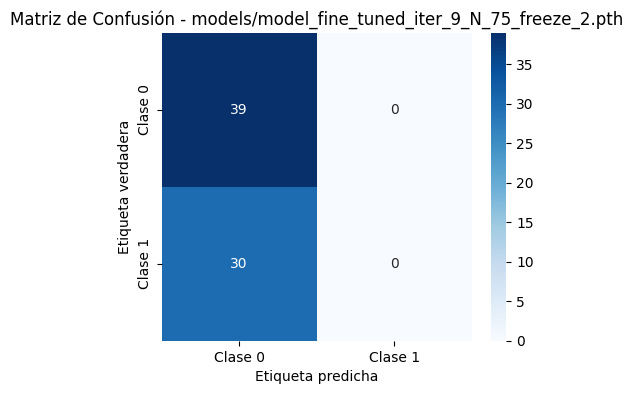

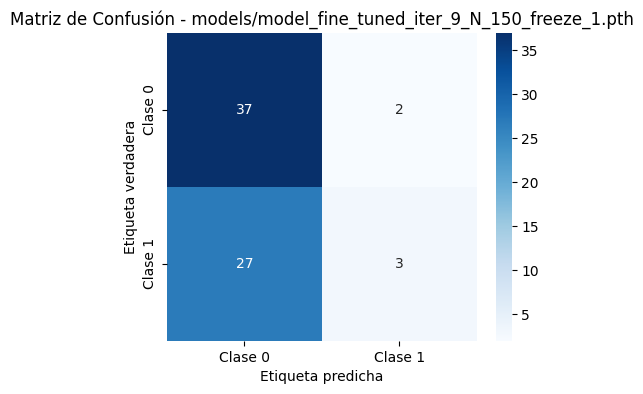

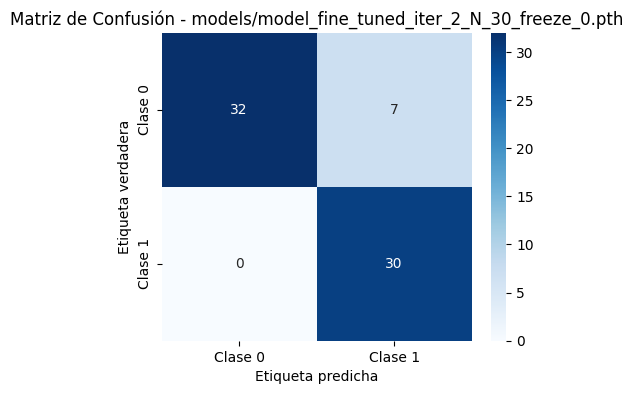

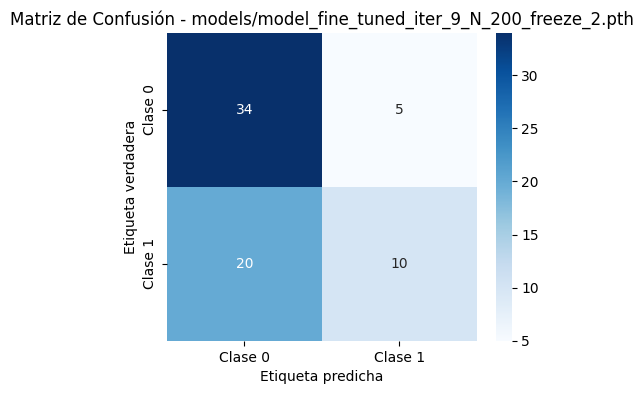

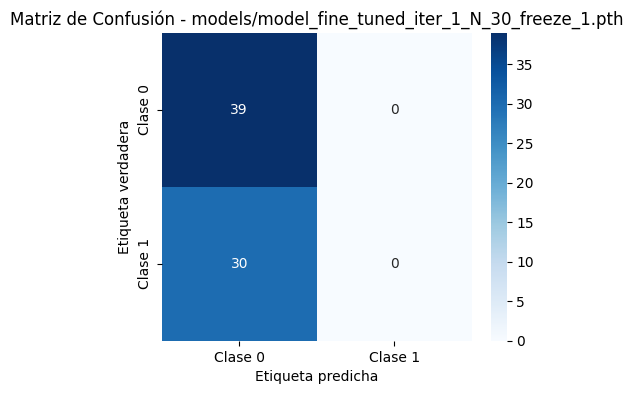

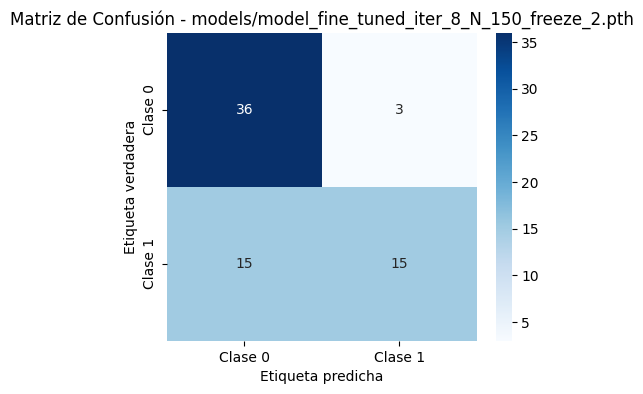

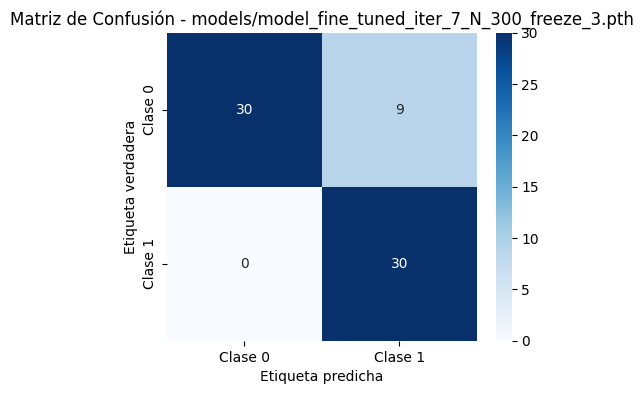

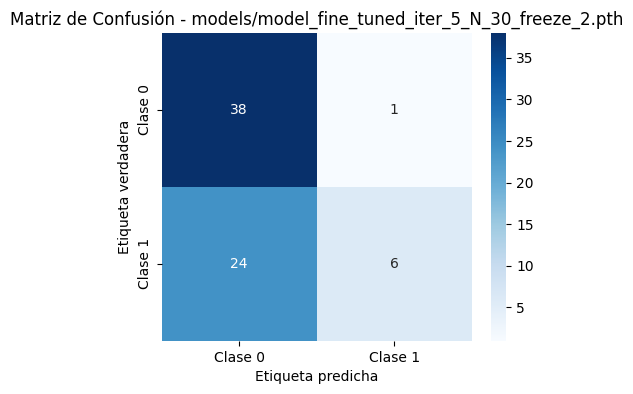

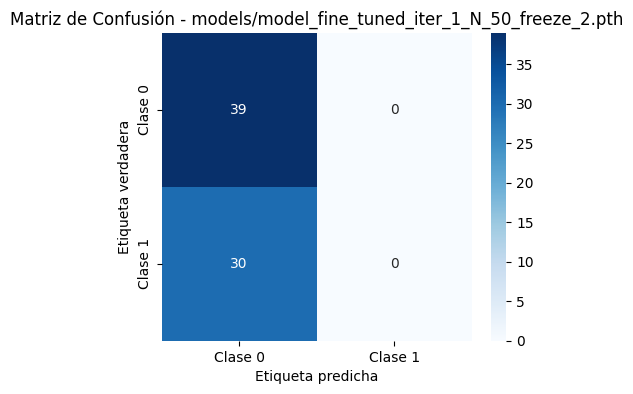

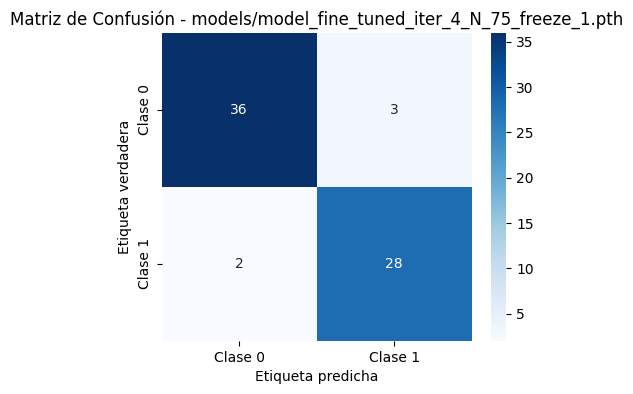

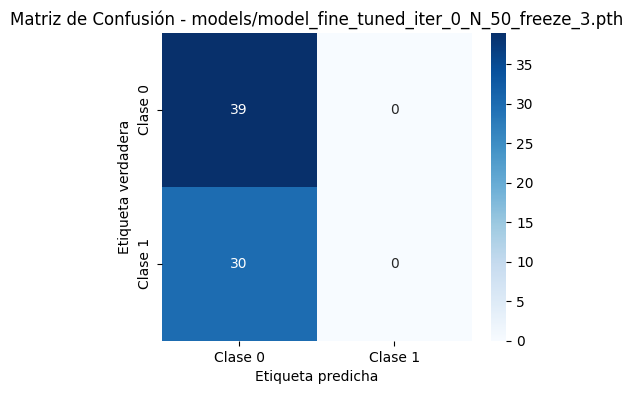

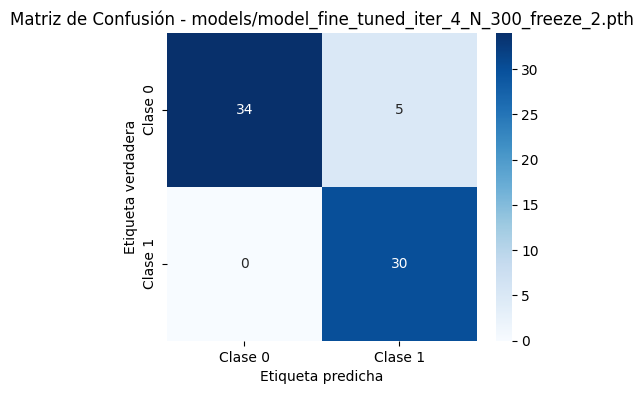

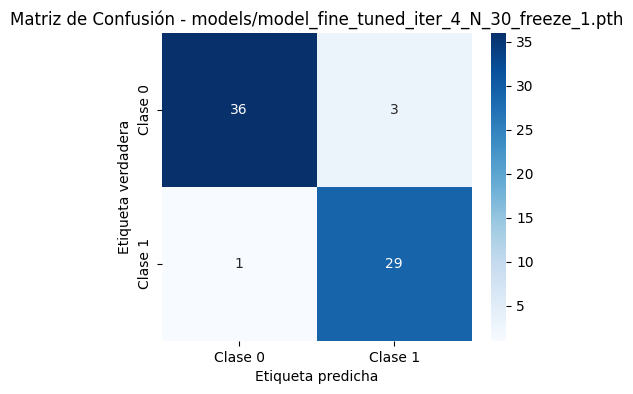

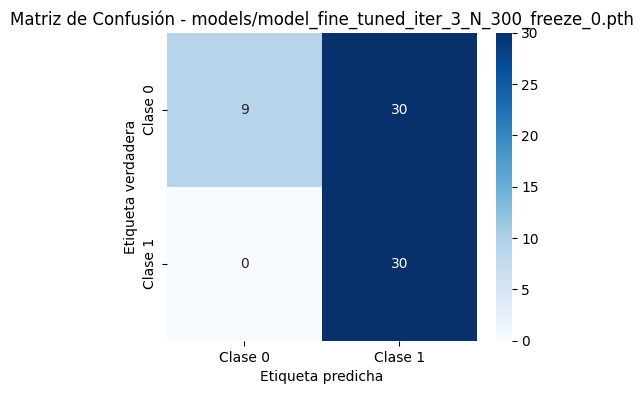

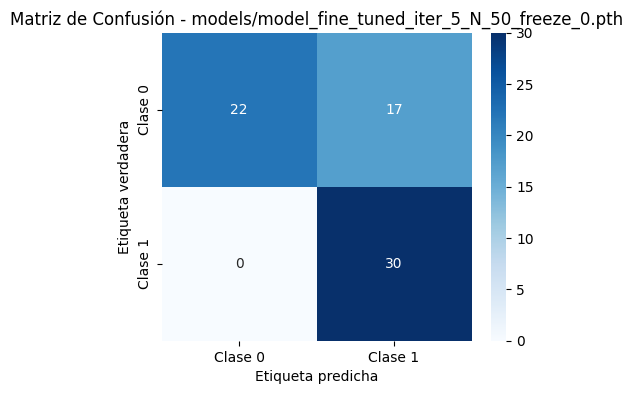

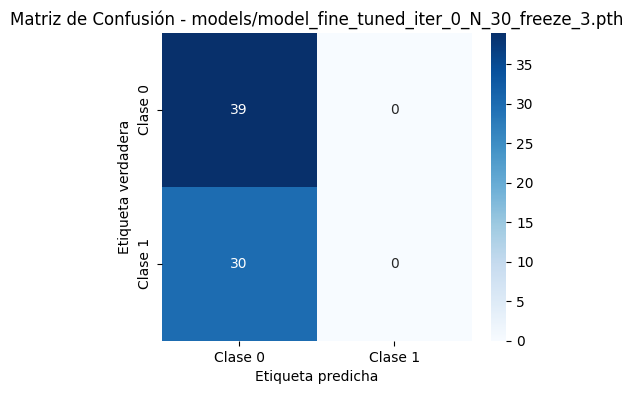

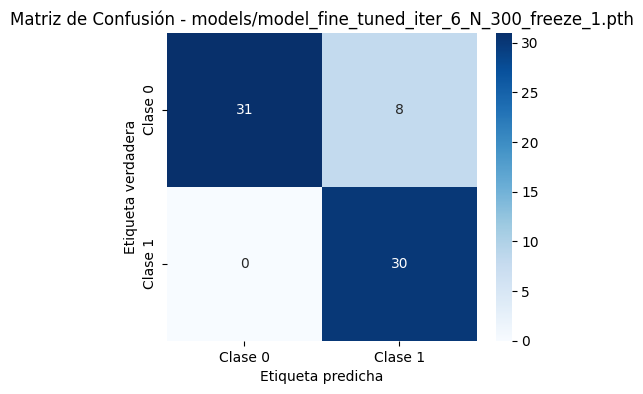

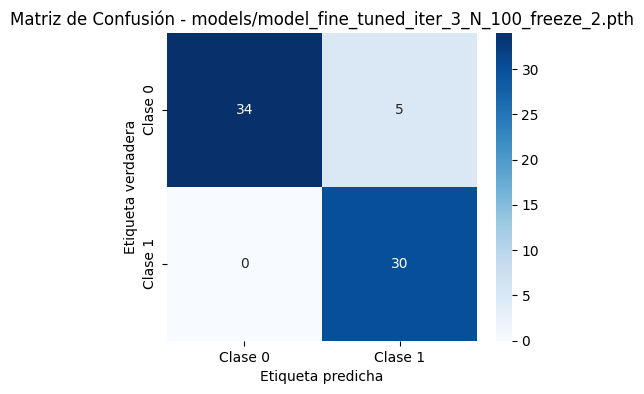

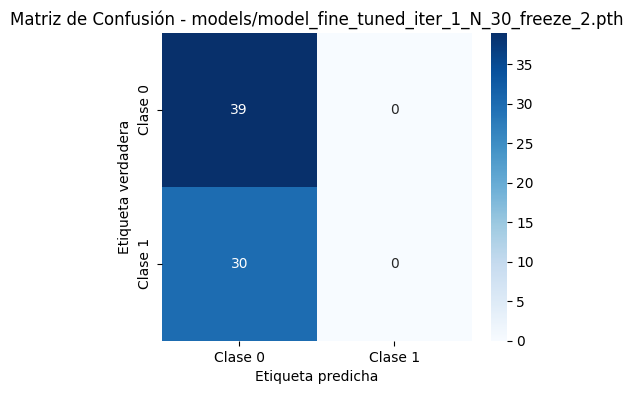

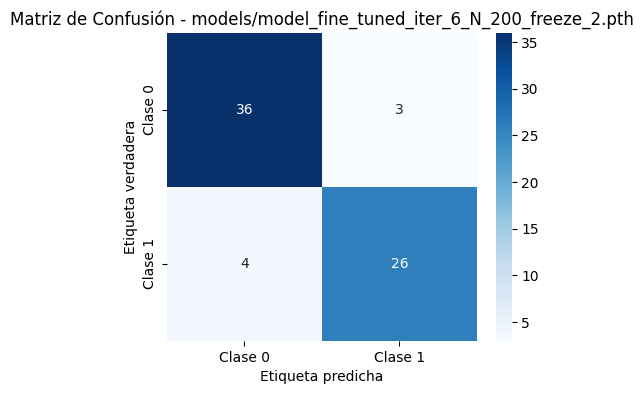

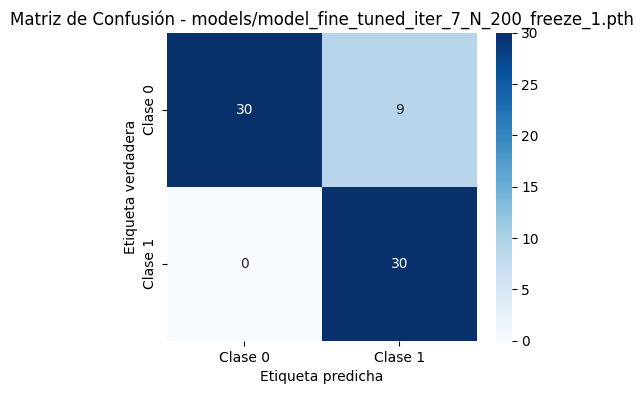

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualización de matrices de confusión
for cm_info in confusion_matrices:
    model_file = cm_info['model_file']
    cm = cm_info['confusion_matrix']

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
    plt.title(f"Matriz de Confusión - {model_file}")
    plt.ylabel('Etiqueta verdadera')
    plt.xlabel('Etiqueta predicha')
    plt.show()

In [37]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
input_size = data_peru_features.shape[1]  # Should be the same as data.shape[1]
model = MLP_2(input_size=input_size).to(device)

# Load the saved state_dict
model.load_state_dict(torch.load('models/model_fine_tuned_iter_5_N_200_freeze_0.pth'))


<ipython-input-37-c438b76f69dc>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/model_fine_tuned_iter_5_N_200_freeze_0.pth'))


<All keys matched successfully>

In [38]:
X_peru = torch.tensor(data_peru_features).to(device)
y_peru = torch.tensor(labels_peru).to(device)


In [39]:
model.eval()
with torch.no_grad():
    outputs = model(X_peru)
    _, preds = torch.max(outputs, 1)


In [40]:
correct_predictions = torch.sum(preds == y_peru)
acc_selected = accuracy_score(y_true, preds)
precision_selected = precision_score(y_true, preds, zero_division=0)
recall_selected = recall_score(y_true, preds, zero_division=0)
f1_selected = f1_score(y_true, preds, zero_division=0)
cm_selected = confusion_matrix(y_true, preds)


print(f"Accuracy on Peruvian data: {acc_selected:.4f}")
print(f"Precision on Peruvian data: {precision_selected:.4f}")
print(f"Recall on Peruvian data: {recall_selected:.4f}")
print(f"F1 Score on Peruvian data: {f1_selected:.4f}")
print("Confusion Matrix on Peruvian data:")
print(cm_selected)


Accuracy on Peruvian data: 0.9565
Precision on Peruvian data: 0.9355
Recall on Peruvian data: 0.9667
F1 Score on Peruvian data: 0.9508
Confusion Matrix on Peruvian data:
[[37  2]
 [ 1 29]]
